# Index

---

+ **Fer2013**  

    1. Loading and preprocessing data
    2. Insights
    3. ResNet transfer learning
    4. Fine tuning
    5. Customized CNN
    6. Data Augmentation
    7. Label smoothing
    8. Test Time Augmentation

+ **Fer2013+**  

    1. Preparing, loading and preprocessing data
    2. Insights
    3. ResNet transfer learning
    4. Fine tuning
    5. Customized CNN
    6. Data Augmentation
    7. Label smoothing
    8. Test Time Augmentation

# Environment

---

In [1]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import tensorflow as tf

# REVISE
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()


from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
from keras.models import load_model
import pickle
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import shap
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tqdm import tqdm
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Instructions for updating:
non-resource variables are not supported in the long term


# Fer2013

---

## Loading and preprocessing data

---

In [2]:
def convertToFloat(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

def getImages(row):
    return row[0]

def getNumpyArray(tf_dataset):
    X = list(tf_dataset)
    X = np.concatenate(list(map(getImages,X)))
    return X

def getLabel(row):
    return row[1]

def getLabels(tf_dataset):
    y = list(tf_dataset)
    y = np.concatenate(list(map(getLabel,y)))
    return y

def load_data(image_size=(48, 48),batch_size=64,label_mode='int',dataset=True):
    # Load training, validation and test sets
    ds_train = image_dataset_from_directory(
        'dataset/train',
        validation_split=0.2,
        seed=123,
        subset="training",
        image_size=image_size,
        batch_size = batch_size,
        interpolation = 'nearest',
        labels='inferred',
        shuffle=True,
        label_mode=label_mode
    )
    ds_val = image_dataset_from_directory(
        'dataset/train',
        validation_split=0.2,
        seed=123,
        subset="validation",
        image_size=image_size,
        batch_size = batch_size,
        interpolation = 'nearest',
        labels='inferred',
        shuffle=True,
        label_mode=label_mode
    )
    ds_test = image_dataset_from_directory(
        'dataset/test',
        image_size=image_size,
        batch_size = batch_size,
        interpolation = 'nearest',
        labels='inferred',
        shuffle=True,
        label_mode=label_mode
    )
    class_names = np.array(ds_train.class_names)
    ds_train = (
        ds_train
        .map(convertToFloat)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_val = (
        ds_val
        .map(convertToFloat)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_test = (
        ds_test
        .map(convertToFloat)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    return ds_train,ds_val,ds_test,class_names

In [3]:
ds_train,ds_val,ds_test,class_names = load_data(batch_size=128,label_mode='categorical')

Found 28708 files belonging to 7 classes.
Using 22967 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 28708 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [4]:
# to use the pretrained model
image_size = (224, 224)
ds_train_224,ds_val_224,ds_test_224,class_names = load_data(image_size=image_size)

Found 28708 files belonging to 7 classes.
Using 22967 files for training.
Found 28708 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [5]:
X_train = getNumpyArray(ds_train)
print(f"Data is already normalized: max is {np.ndarray.max(X_train)} and min is {np.ndarray.min(X_train)} with {np.ndarray.std(X_train):.2f} standard deviation")

Data is already normalized: max is 1.0 and min is 0.0 with 0.26 standard deviation


## Getting insights

---

In [6]:
print('There are\033[1m {}\033[0m classes:\033[1m'.format(len(class_names)))
for class_name in class_names:
    print('\t'+class_name.upper())
print("\033[0m", end="")

There are 7 classes:
	ANGRY
	DISGUST
	FEAR
	HAPPY
	NEUTRAL
	SAD
	SURPRISE


In [7]:
y_train = getLabels(ds_train)
y_val = getLabels(ds_val)
y_test = getLabels(ds_test)

y_train_224 = getLabels(ds_train_224)
y_val_224 = getLabels(ds_val_224)
y_test_224 = getLabels(ds_test_224)

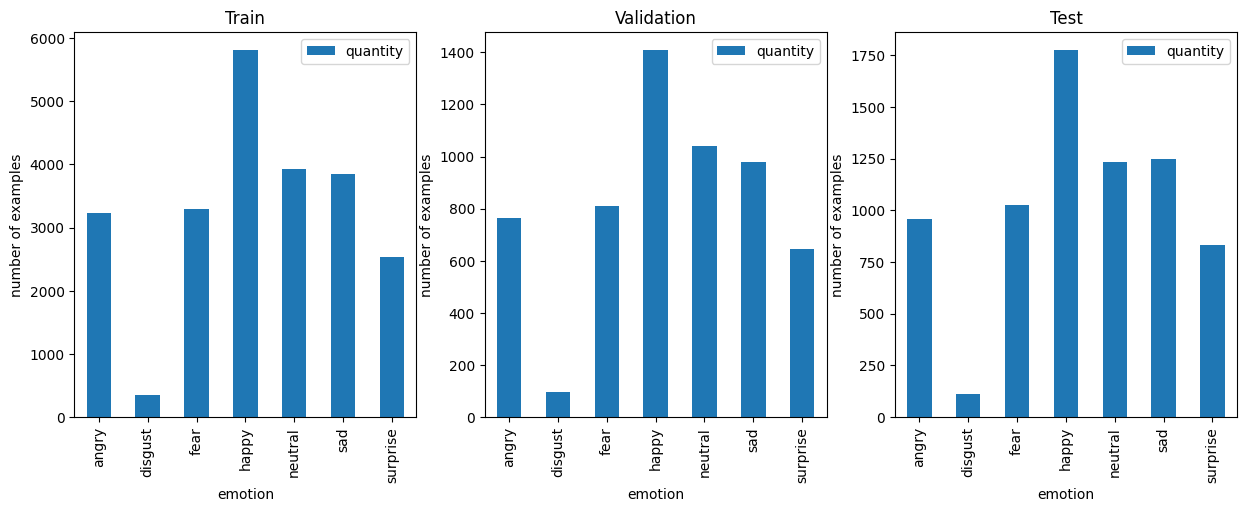

In [8]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
pd.DataFrame({'emotion':class_names[y_train_224], 'quantity': np.ones(y_train_224.shape)}).groupby('emotion').count().plot(ax=axes[0], kind='bar')
pd.DataFrame({'emotion':class_names[y_val_224], 'quantity': np.ones(y_val_224.shape)}).groupby('emotion').count().plot(ax=axes[1], kind='bar')
pd.DataFrame({'emotion':class_names[y_test_224], 'quantity': np.ones(y_test_224.shape)}).groupby('emotion').count().plot(ax=axes[2], kind='bar');

titles = ['Train','Validation','Test']
for i in range(3):
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('number of examples'); 

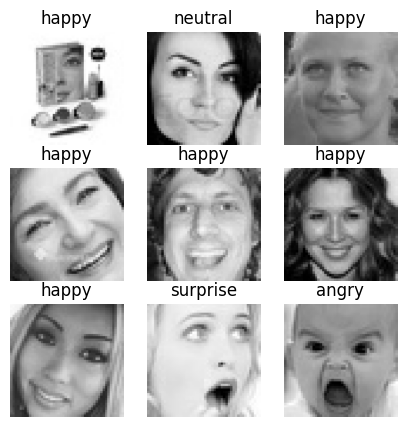

In [9]:
X_train_224 = getNumpyArray(ds_train_224)
plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train_224[i])
  plt.title(class_names[y_train_224[i]])
  plt.axis("off");

## ResNet transfer learning

---

In [11]:
model = tf.keras.Sequential([
                                # tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224))),
                                hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
                                            trainable=False),
                                tf.keras.layers.Dense(len(class_names), activation='softmax')
                            ])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  23561152  
                                                                 
 dense (Dense)               multiple                  14343     
                                                                 
Total params: 23,575,495
Trainable params: 14,343
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
# history = model.fit(
#     ds_train_224,
#     validation_data=ds_val_224,
#     epochs=10,
# )
# model.save('models/resnet.h5')
# with open('models/resnet.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [12]:
model = load_model('models/resnet.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_resnet.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [10]:
def evaluate(model,history,ds_train,ds_val,ds_test,shap_values=None,one_hot_encoded=False,class_names_variable=class_names,isPlus=False):
    y_train = getLabels(ds_train)
    y_val = getLabels(ds_val)
    y_test = getLabels(ds_test)

    f,axes = plt.subplots(1,2,figsize=(20,5))
    history_frame = pd.DataFrame(history)
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1]);

    if(one_hot_encoded):
        y_train = np.argmax(y_train,axis=1)
        y_val = np.argmax(y_val,axis=1)
        y_test = np.argmax(y_test,axis=1)
    print("Calculating training results:")
    y_train_predictions = np.argmax(model.predict(ds_train),axis=1)
    print("Calculating validation results:")
    y_val_predictions = np.argmax(model.predict(ds_val),axis=1)
    print("Calculating test results:")
    y_test_predictions = np.argmax(model.predict(ds_test),axis=1)

    if(isPlus):
        f, axes= plt.subplots(1,3,figsize=(30,15))
    else:
        f, axes= plt.subplots(1,3,figsize=(30,5))
    accuracies = []
    accuracies.append(round(100*accuracy_score(y_train, y_train_predictions),2))
    mat = confusion_matrix(y_train, y_train_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[0]);

    accuracies.append(round(100*accuracy_score(y_val, y_val_predictions),2))
    mat = confusion_matrix(y_val, y_val_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[1]);

    accuracies.append(round(100*accuracy_score(y_test, y_test_predictions),2))
    mat = confusion_matrix(y_test,y_test_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[2]);

    for i in range(3):
        axes[i].set_xlabel('Predicted emotions');axes[i].set_ylabel('True emotions'); 
        axes[i].set_title('Confusion Matrix '+titles[i]+ " (accuracy: {}%)".format(accuracies[i])); 
        axes[i].xaxis.set_ticklabels(class_names_variable); axes[i].yaxis.set_ticklabels(class_names_variable);
    if(shap_values is not None):
        fig,axes = plt.subplots(1,len(class_names_variable)+1,figsize=(20,3))
        axes[0].set_axis_off()
        axes[0].set_title("REAL CLASSES ->")
        image = plt.imread('images/predicted.png')
        axes[0].imshow(image)
        for i in range(1,len(class_names_variable)+1):
            axes[i].set_axis_off()
            axes[i].set_title(class_names_variable[i-1])
            axes[i].imshow(one_example_per_class[i-1])
        shap.image_plot(shap_values,one_example_per_class)

Calculating training results:
359/359 [==============================] - 185s 515ms/step
Calculating validation results:
90/90 [==============================] - 48s 544ms/step
Calculating test results:
113/113 [==============================] - 61s 543ms/step


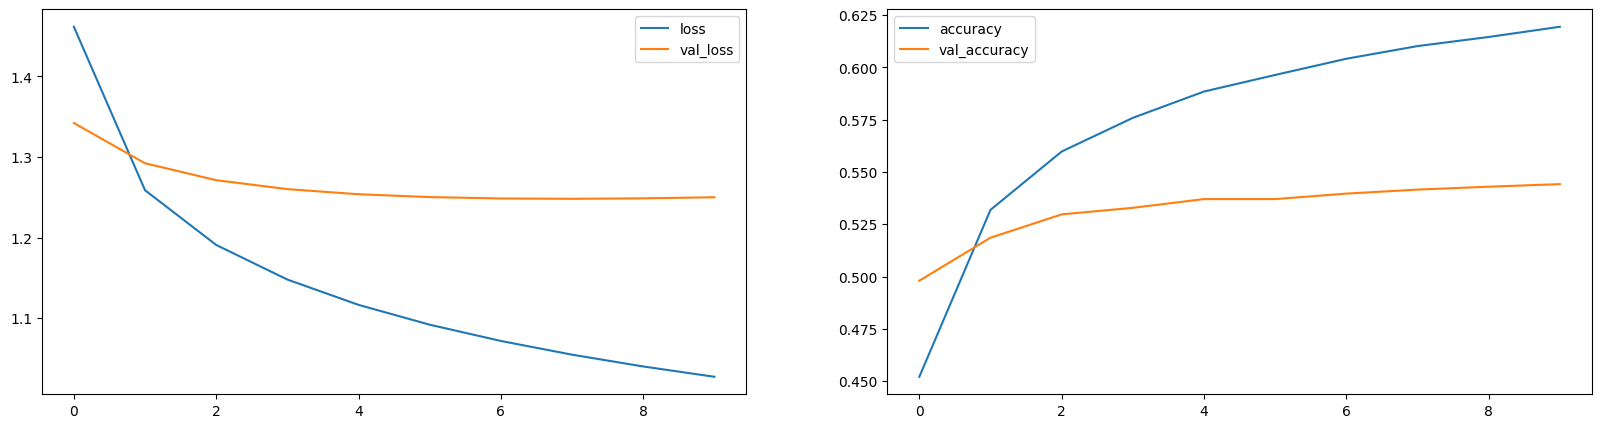

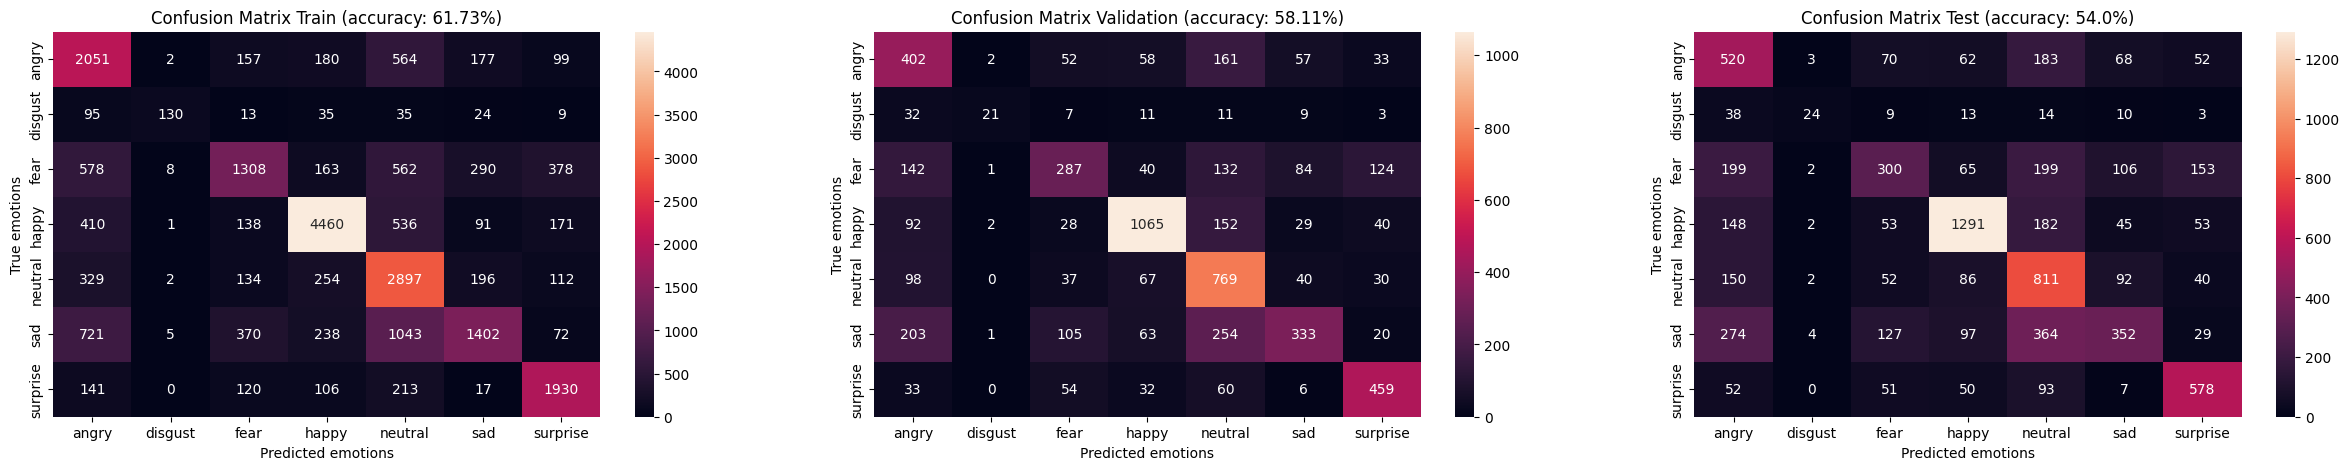

In [58]:
evaluate(model,history2,ds_train_224,ds_val_224,ds_test_224)

## Fine tuning

---

In [69]:
model = tf.keras.Sequential([
                                hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
                                            trainable=True),
                                tf.keras.layers.Dense(len(class_names), activation='softmax')
                            ])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  23561152  
                                                                 
 dense (Dense)               multiple                  14343     
                                                                 
Total params: 23,575,495
Trainable params: 23,522,375
Non-trainable params: 53,120
_________________________________________________________________


In [70]:
# history = model.fit(
#     ds_train_224,
#     validation_data=ds_val_224,
#     epochs=5,
# )
# model.save('models/resnet_fine_tuned.h5')
# with open('models/history_fine_tuned.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
359/359 [==============================] - 824s 2s/step - loss: 1.5464 - accuracy: 0.5229 - val_loss: 1.9892 - val_accuracy: 0.3654
Epoch 2/5
359/359 [==============================] - 890s 2s/step - loss: 1.3353 - accuracy: 0.6159 - val_loss: 1.6179 - val_accuracy: 0.5003
Epoch 3/5
359/359 [==============================] - 955s 3s/step - loss: 1.2442 - accuracy: 0.6661 - val_loss: 1.8818 - val_accuracy: 0.5017
Epoch 4/5
359/359 [==============================] - 947s 3s/step - loss: 1.2096 - accuracy: 0.7106 - val_loss: 2.1519 - val_accuracy: 0.4473
Epoch 5/5
359/359 [==============================] - 965s 3s/step - loss: 1.2006 - accuracy: 0.7510 - val_loss: 2.7472 - val_accuracy: 0.4144


In [73]:
model = load_model('models/resnet_fine_tuned.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_fine_tuned.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
359/359 [==============================] - 197s 547ms/step
Calculating validation results:
90/90 [==============================] - 52s 589ms/step
Calculating test results:
113/113 [==============================] - 67s 593ms/step


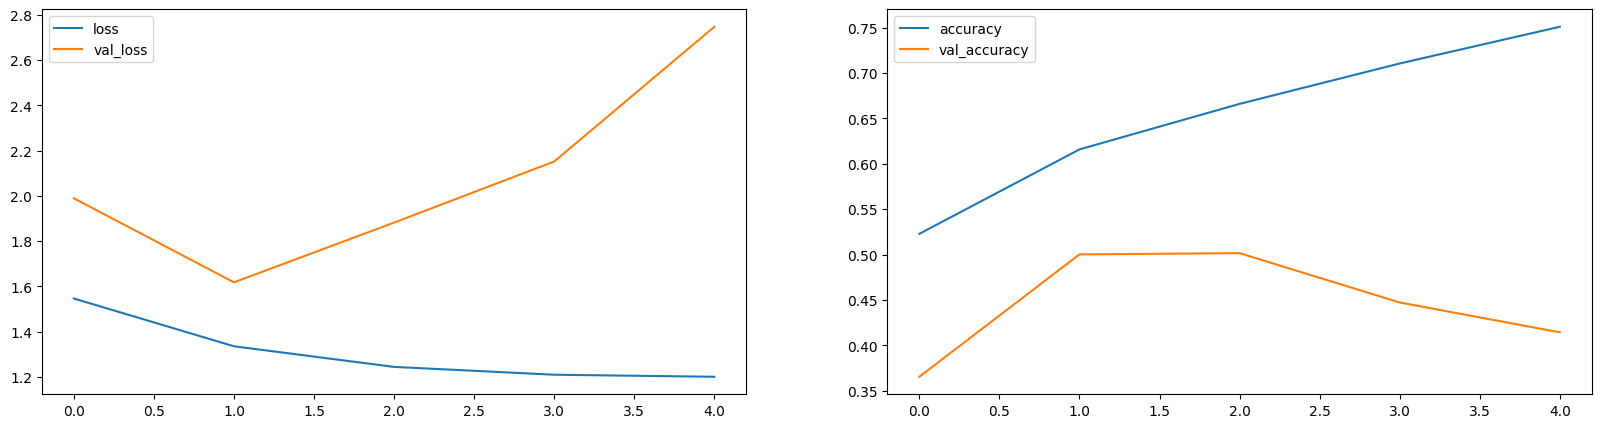

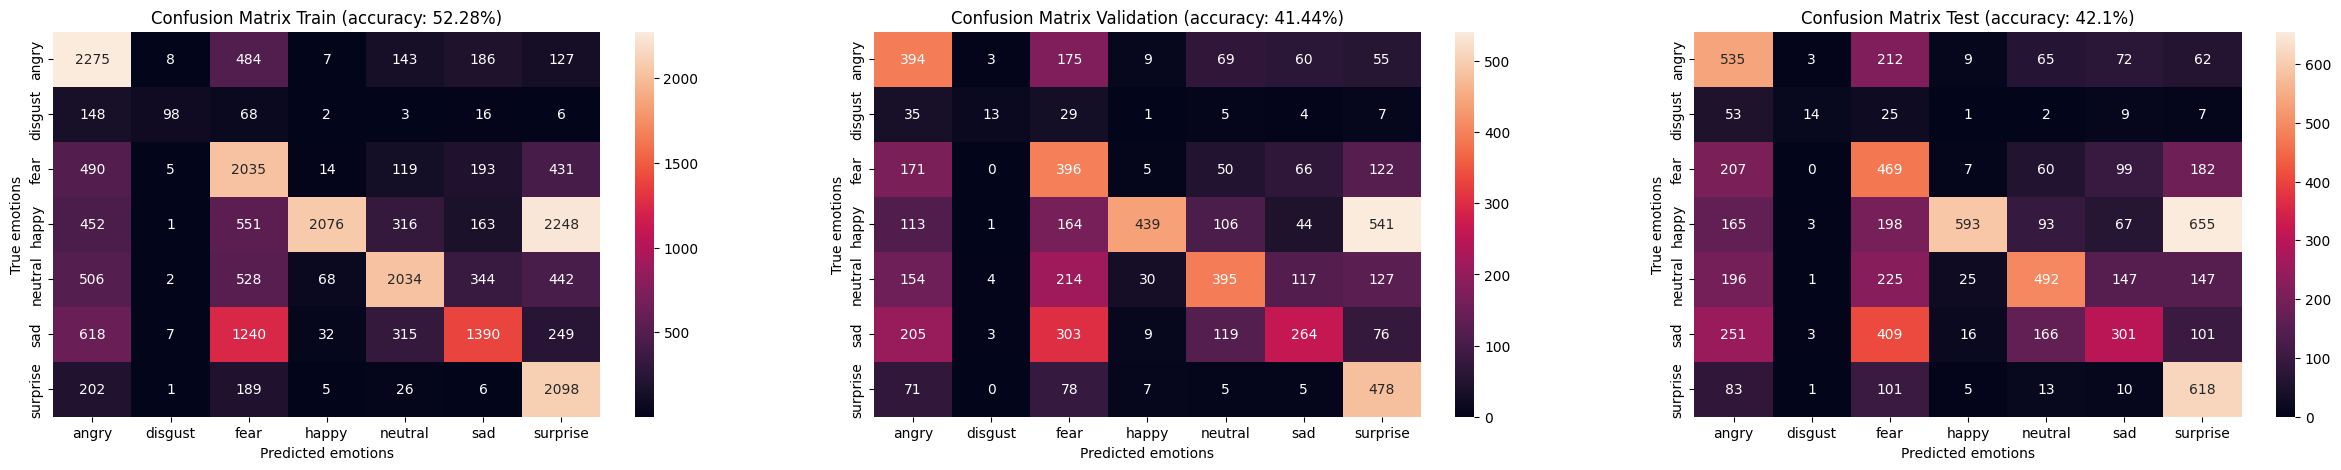

In [74]:
evaluate(model,history2,ds_train_224,ds_val_224,ds_test_224)

## Customized CNN

---

In [67]:
def createModel(loss='categorical_crossentropy'):
    tf.random.set_seed(1)
    model= tf.keras.models.Sequential([
        preprocessing.Normalization(),

        Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        Conv2D(64,(3,3), padding='same', activation='relu' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128,(5,5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
            
        Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256,activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),
            
        Dense(512,activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(7, activation='softmax')
    ])
    model.build([None, 48, 48, 3])
    model.compile(
        # its default learning rate is already 0.001
        optimizer=Adam(),
        loss=loss,
        metrics=['accuracy'],
    )
    return model

I'll search for the best learning rate posible with GridSearch

In [ ]:
# X_train = getNumpyArray(ds_train)
# y_train = getLabels(ds_train)
# X_val = getNumpyArray(ds_val)
# y_val = getLabels(ds_val)
# X = np.vstack((X_train,X_val))
# y = np.concatenate((y_train,y_val))

# model = KerasClassifier(model=createModel,batch_size=64, epochs=5)
# learn_rate = [0.001, 0.0001,0.00001]
# param_grid = dict(optimizer__learning_rate=learn_rate)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=3)
# grid_result = grid.fit(X,y)

# joblib.dump(grid.best_params_, 'best_learning_rate_custom_model.pkl')

In [ ]:
best_learning_rate = joblib.load('best_learning_rate_custom_model.pkl')
print(f"The best learning rate amongst the ones that have been tried is {best_learning_rate['optimizer__learning_rate']}")

In [45]:
model= createModel()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  multiple                 7         
 ion)                                                            
                                                                 
 conv2d_10 (Conv2D)          multiple                  896       
                                                                 
 conv2d_11 (Conv2D)          multiple                  18496     
                                                                 
 batch_normalization_12 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0         
 2D)                                                             
                                                      

In [ ]:
# history = model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=30,
# )
# model.save('models/custom.h5')
# with open('models/history_custom.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [51]:
model = load_model('models/custom.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_custom.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [49]:
one_example_per_class = np.empty((len(class_names),)+X_train[0].shape)
for i in range(len(class_names)):
    one_example_per_class[i] = X_train[np.where(y_train == i)[0][0]]

In [ ]:
# shapExplainer = shap.DeepExplainer(model,X_train[:100])
# shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
# shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.linearity_1d(0)
# shap_values = shapExplainer.shap_values(one_example_per_class)
# with open("shap_values", "wb") as fp:
#     pickle.dump(shap_values, fp)

In [53]:
with open("shap_values", "rb") as fp:
    shap_values = pickle.load(fp)

Calculating training results:
180/180 [==============================] - 12s 67ms/step
Calculating validation results:
45/45 [==============================] - 3s 67ms/step
Calculating test results:
57/57 [==============================] - 4s 66ms/step


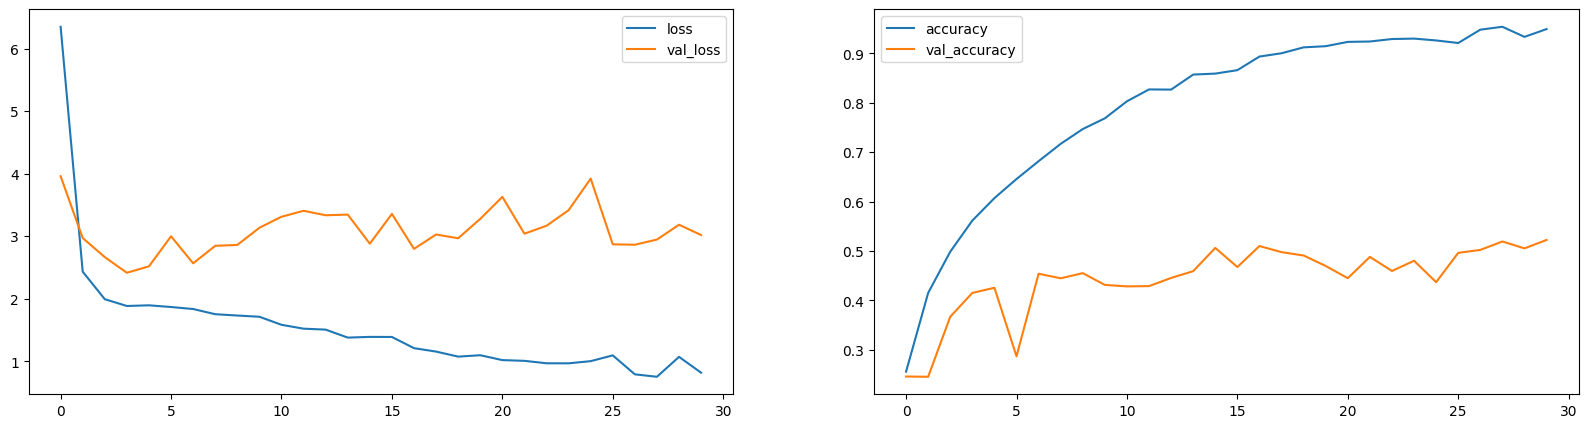

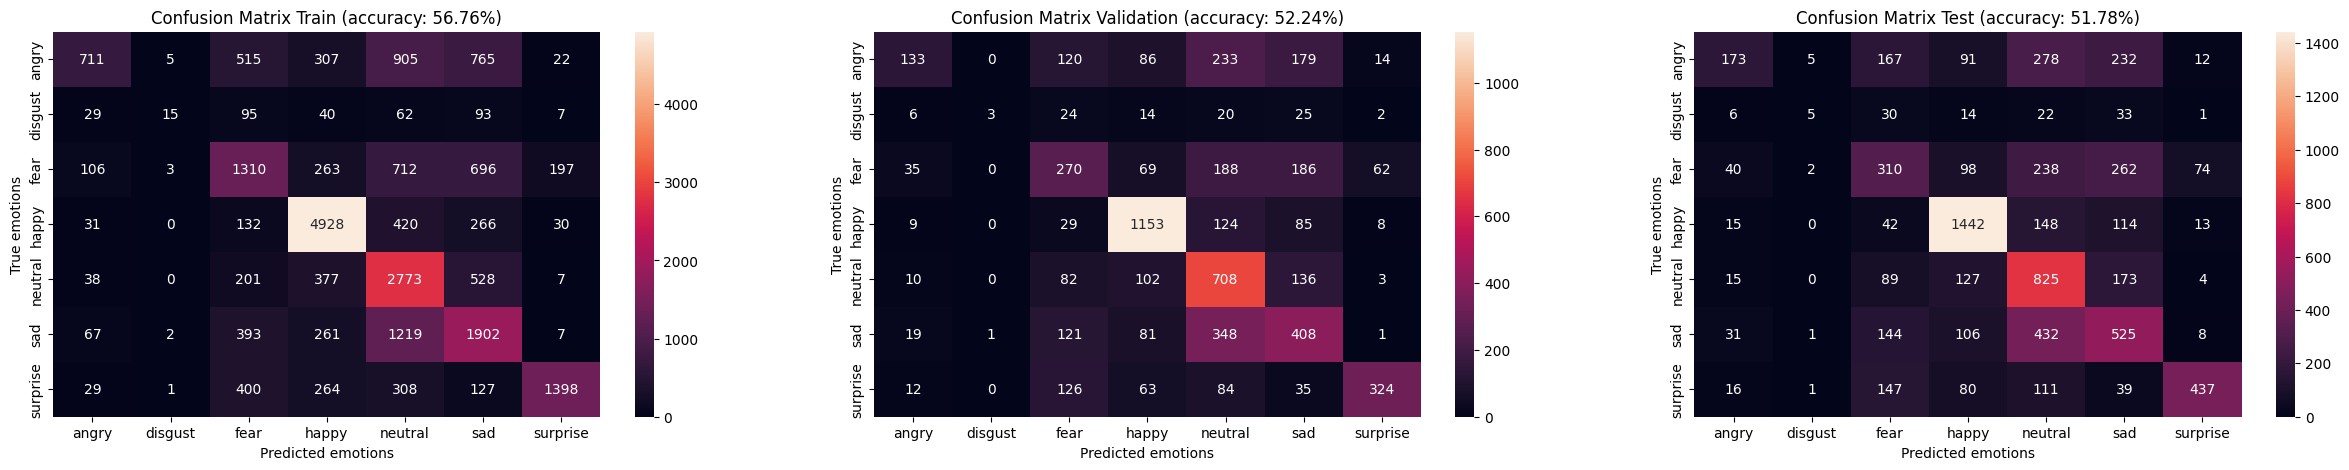

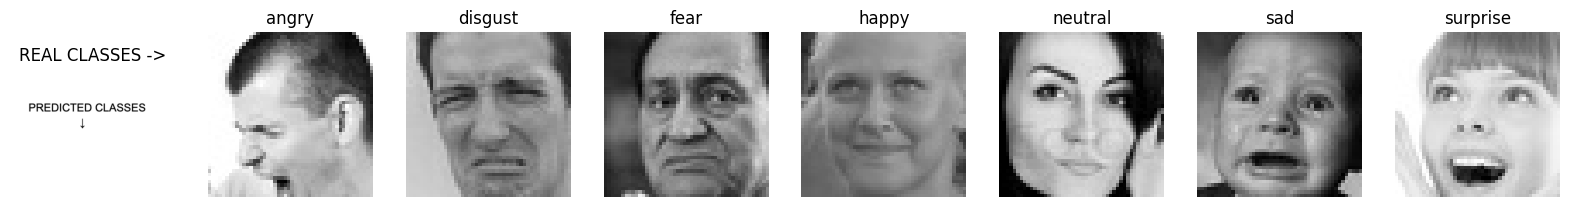

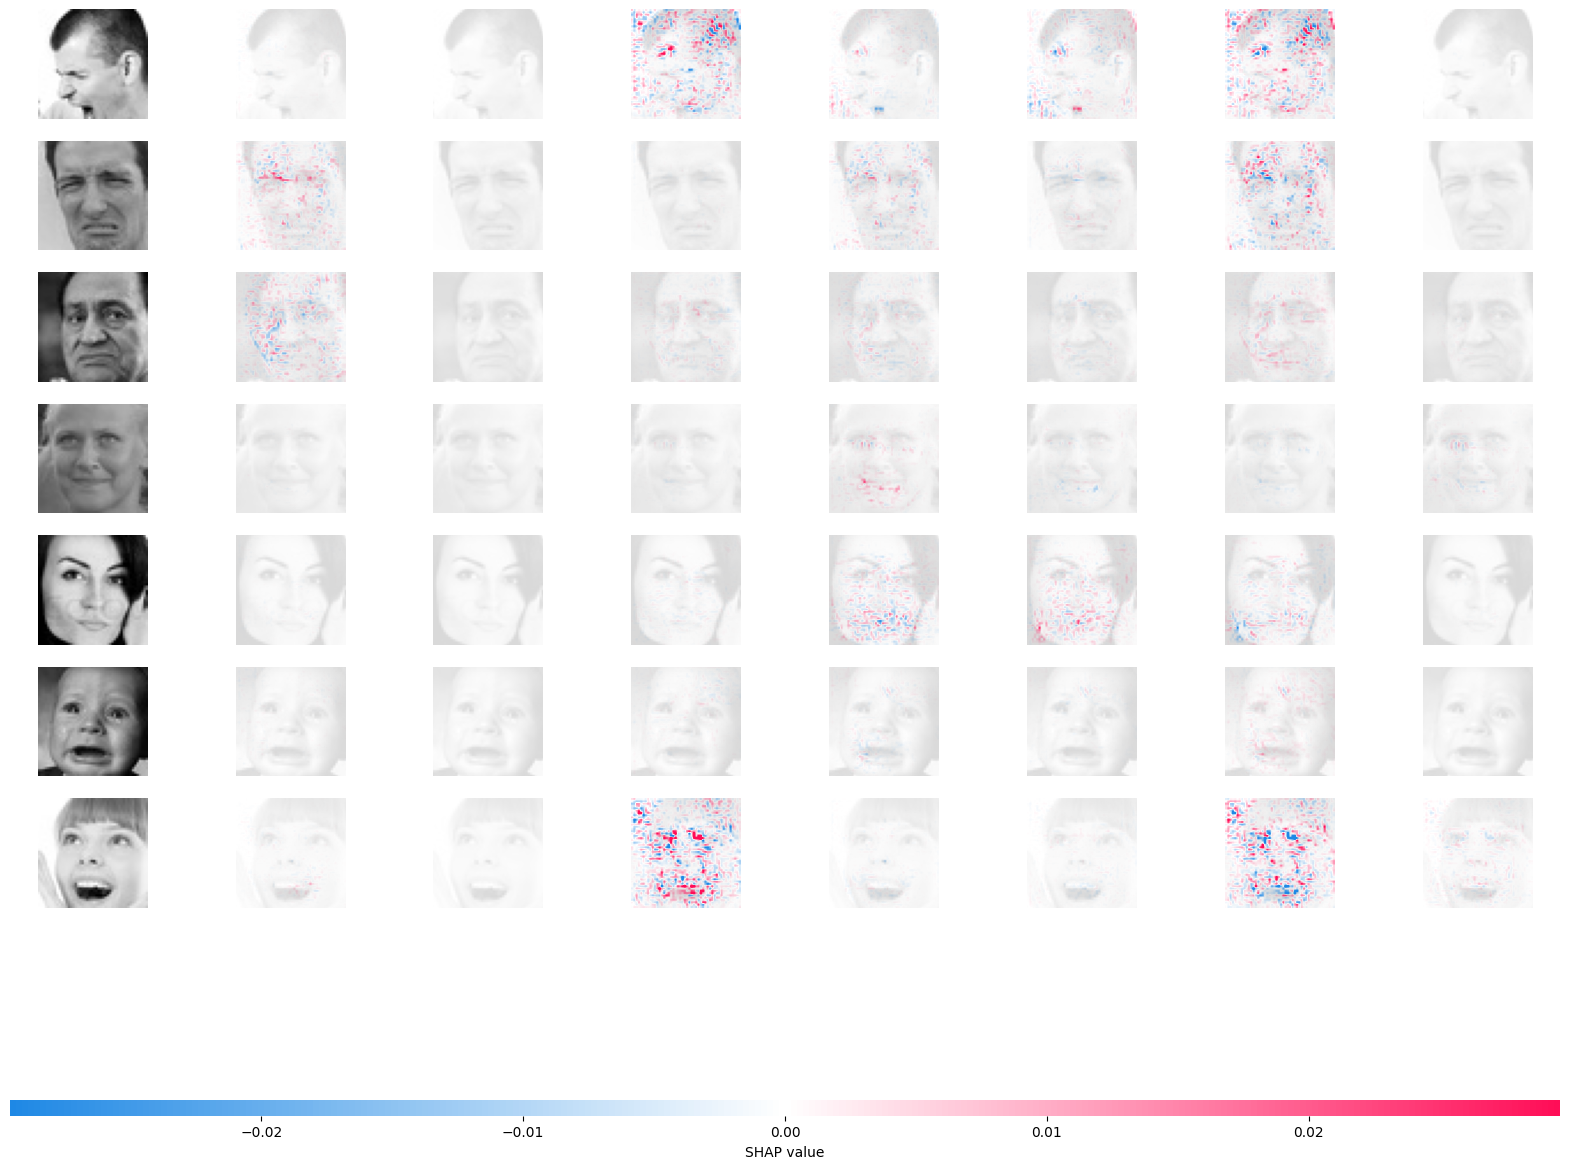

In [55]:
evaluate(model,history2,ds_train,ds_val,ds_test,shap_values=shap_values,one_hot_encoded=True)

## Data augmentation

---

In [13]:
X_train = getNumpyArray(ds_train)
X_val = getNumpyArray(ds_val)
X_test = getNumpyArray(ds_test)
y_train = getLabels(ds_train)
y_val = getLabels(ds_val)
y_test = getLabels(ds_test)

In [ ]:
# model = load_model('models/custom.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(horizontal_flip=True)
# train_datagen.fit(X_train)

# history = model.fit(train_datagen.flow(X_train, y_train),
#                               epochs=5,
#                               validation_data=ds_val)
# model.save('models/augmented.h5')
# with open('models/history_augmented.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [15]:
model = load_model('models/augmented.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
180/180 [==============================] - 12s 69ms/step
Calculating validation results:
45/45 [==============================] - 3s 70ms/step
Calculating test results:
57/57 [==============================] - 4s 69ms/step


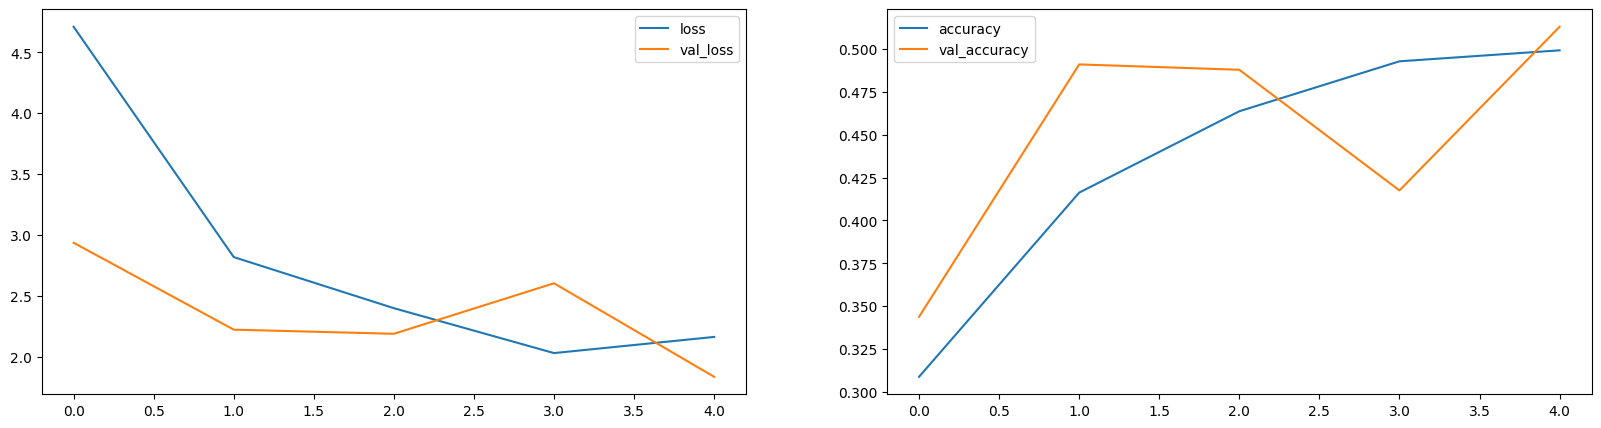

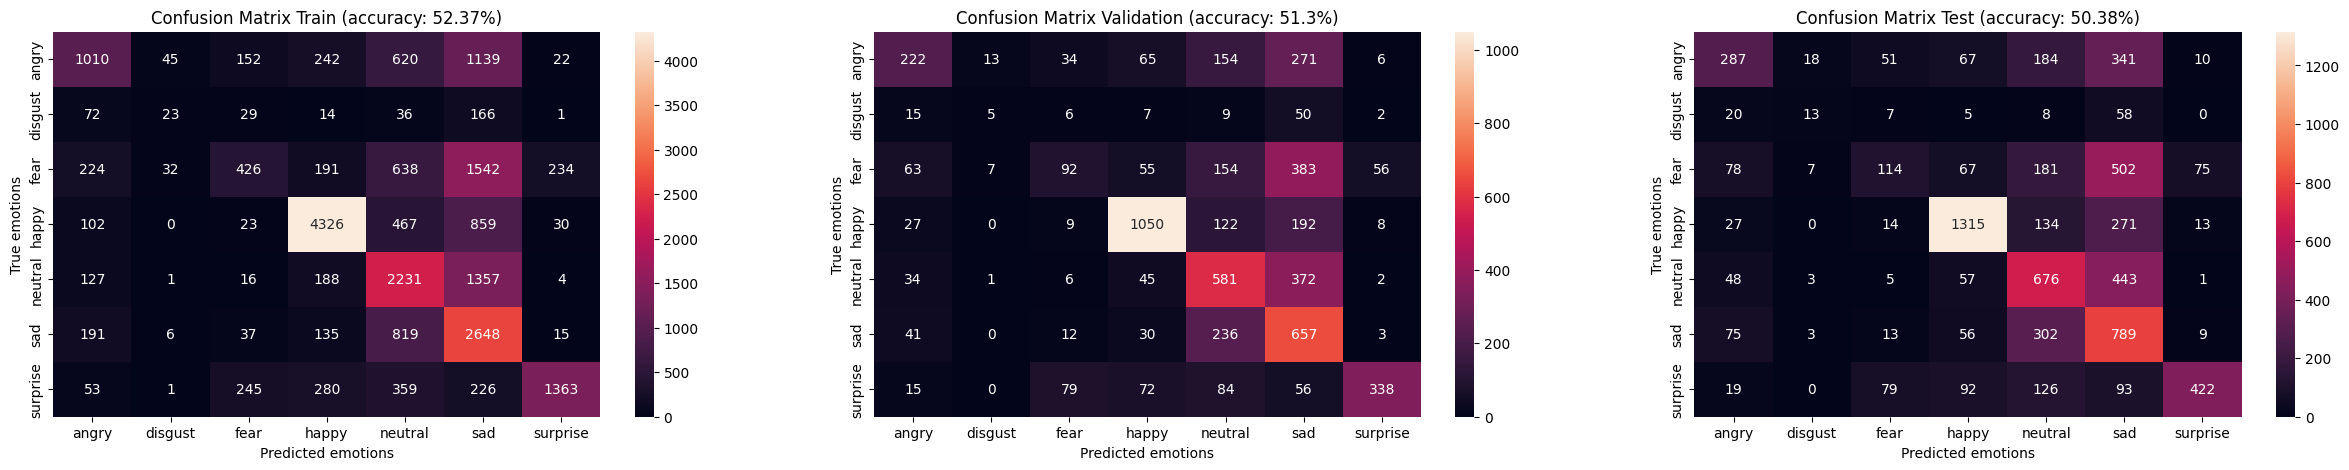

In [16]:
evaluate(model,history2,ds_train,ds_val,ds_test,one_hot_encoded=True)

In [ ]:
# model = load_model('models/custom.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(shear_range=5)
# train_datagen.fit(X_train)

# history = model.fit(train_datagen.flow(X_train, y_train),
#                               epochs=5,
#                               validation_data=ds_val)
# model.save('models/augmented2.h5')
# with open('models/history_augmented2.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [18]:
model = load_model('models/augmented2.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented2.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
180/180 [==============================] - 12s 68ms/step
Calculating validation results:
45/45 [==============================] - 3s 69ms/step
Calculating test results:
57/57 [==============================] - 4s 69ms/step


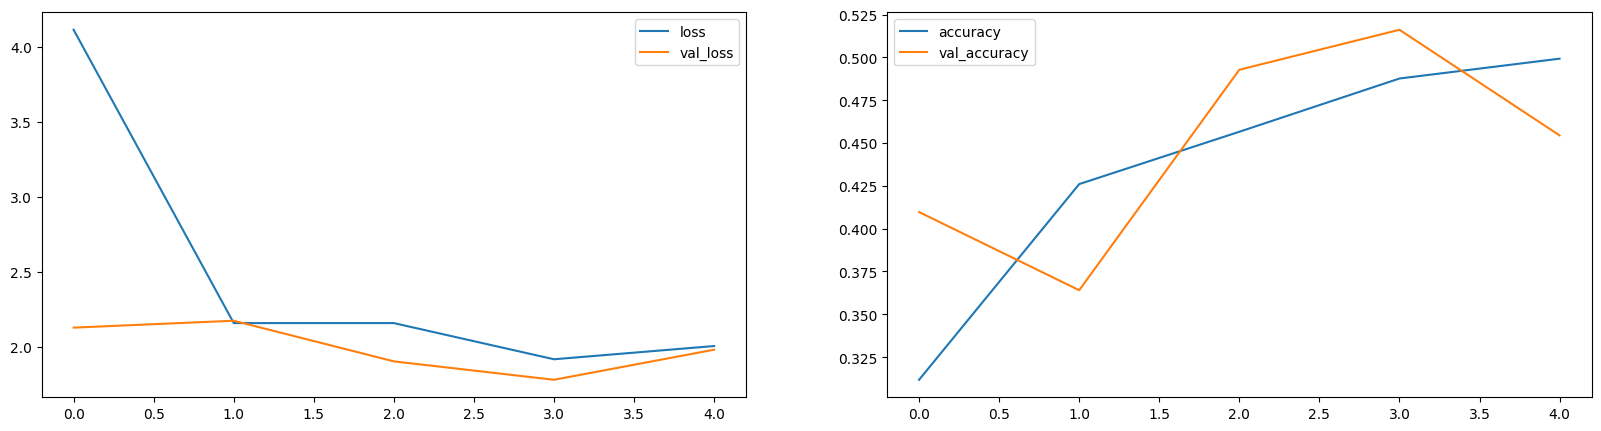

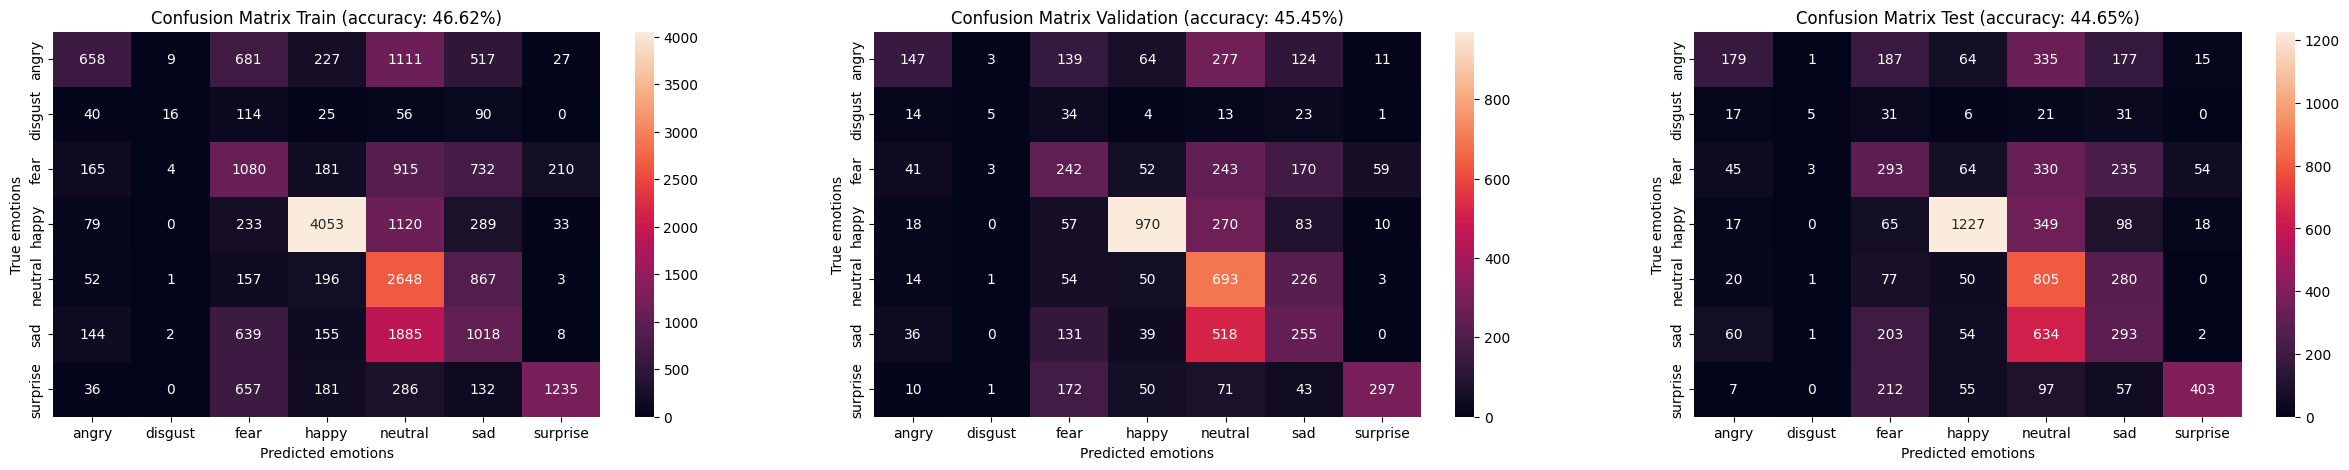

In [19]:
evaluate(model,history2,ds_train,ds_val,ds_test,one_hot_encoded=True)

In [ ]:
# model = load_model('models/custom.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(horizontal_flip=True,
#                                    shear_range=5)
# train_datagen.fit(X_train)

# history = model.fit(train_datagen.flow(X_train, y_train),
#                               epochs=5,
#                               validation_data=ds_val)
# model.save('models/augmented3.h5')
# with open('models/history_augmented3.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [63]:
model = load_model('models/augmented3.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented3.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
180/180 [==============================] - 13s 73ms/step
Calculating validation results:
45/45 [==============================] - 3s 71ms/step
Calculating test results:
57/57 [==============================] - 4s 75ms/step


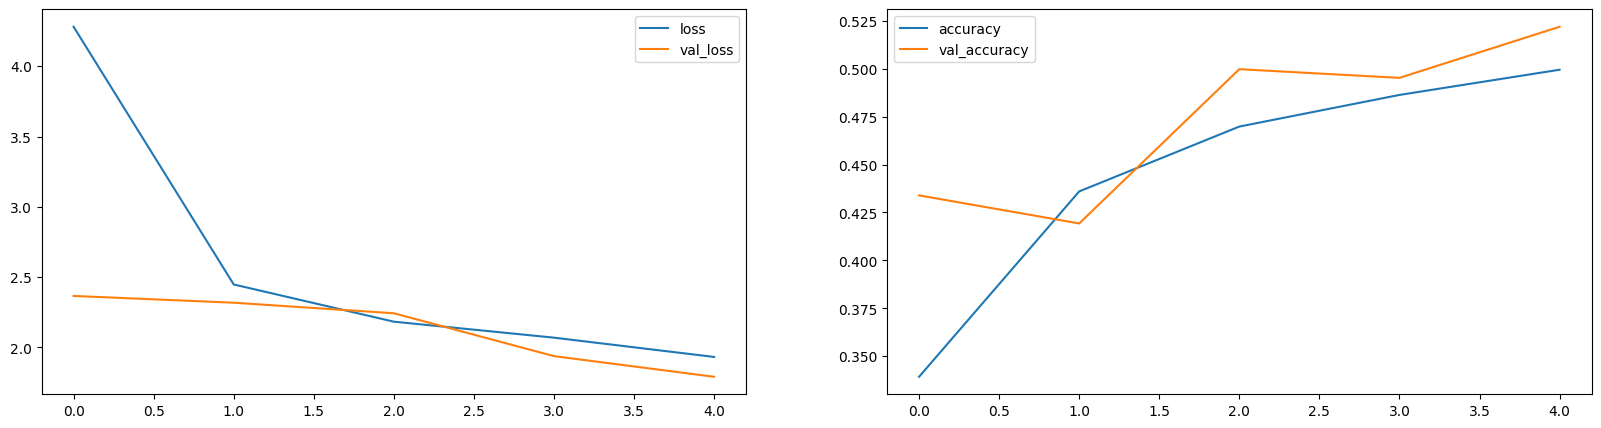

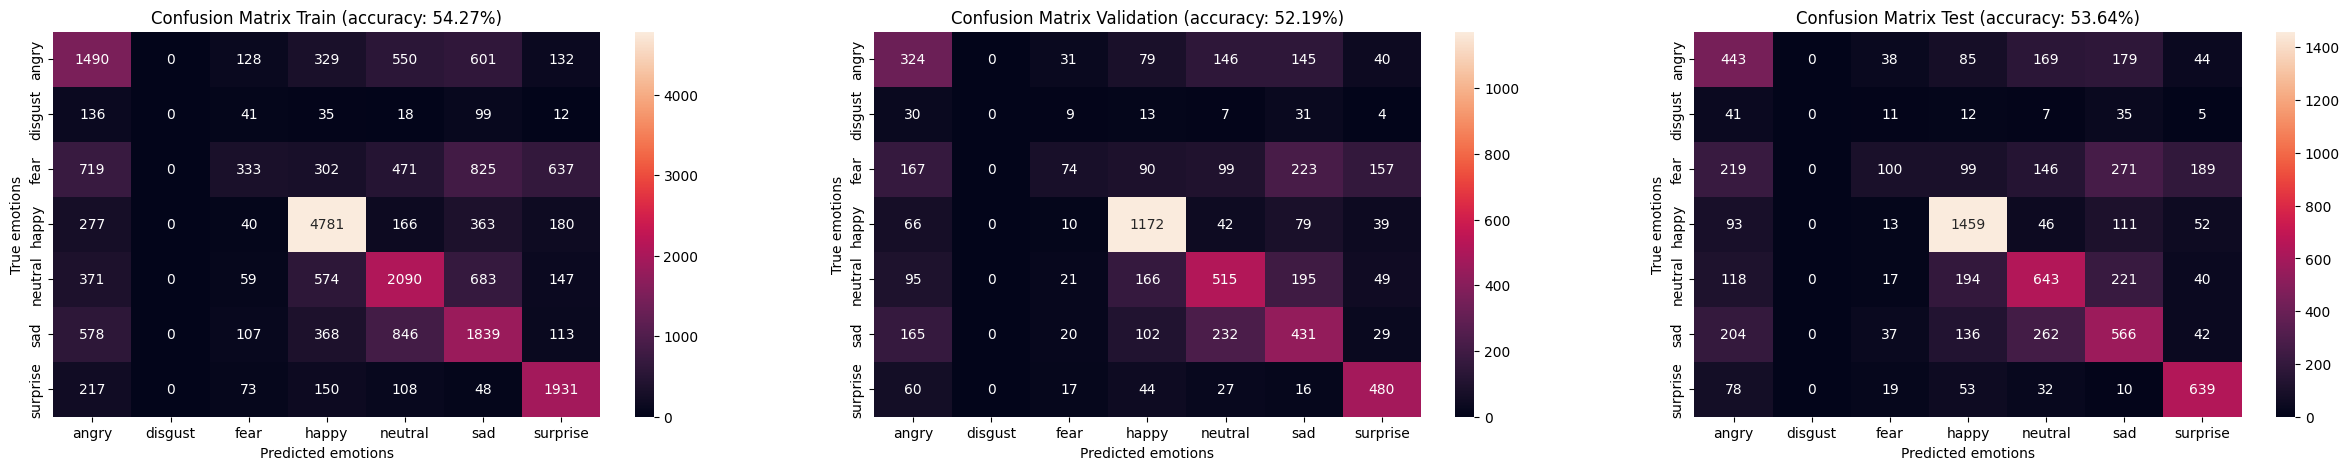

In [65]:
evaluate(model,history2,ds_train,ds_val,ds_test,one_hot_encoded=True)

In [ ]:
# model = load_model('models/custom.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(horizontal_flip=True,
#                                    shear_range=10)
# train_datagen.fit(X_train)

# history = model.fit(train_datagen.flow(X_train, y_train),
#                               epochs=5,
#                               validation_data=ds_val)
# model.save('models/augmented4.h5')
# with open('models/history_augmented4.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [23]:
model = load_model('models/augmented4.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented4.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
180/180 [==============================] - 12s 67ms/step
Calculating validation results:
45/45 [==============================] - 3s 69ms/step
Calculating test results:
57/57 [==============================] - 4s 68ms/step


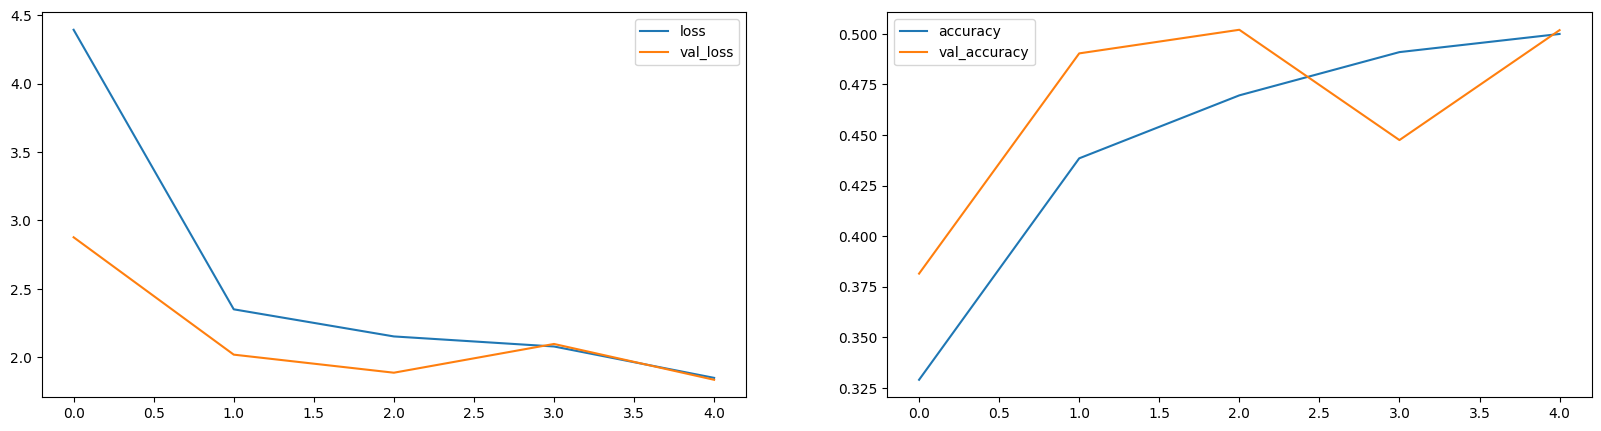

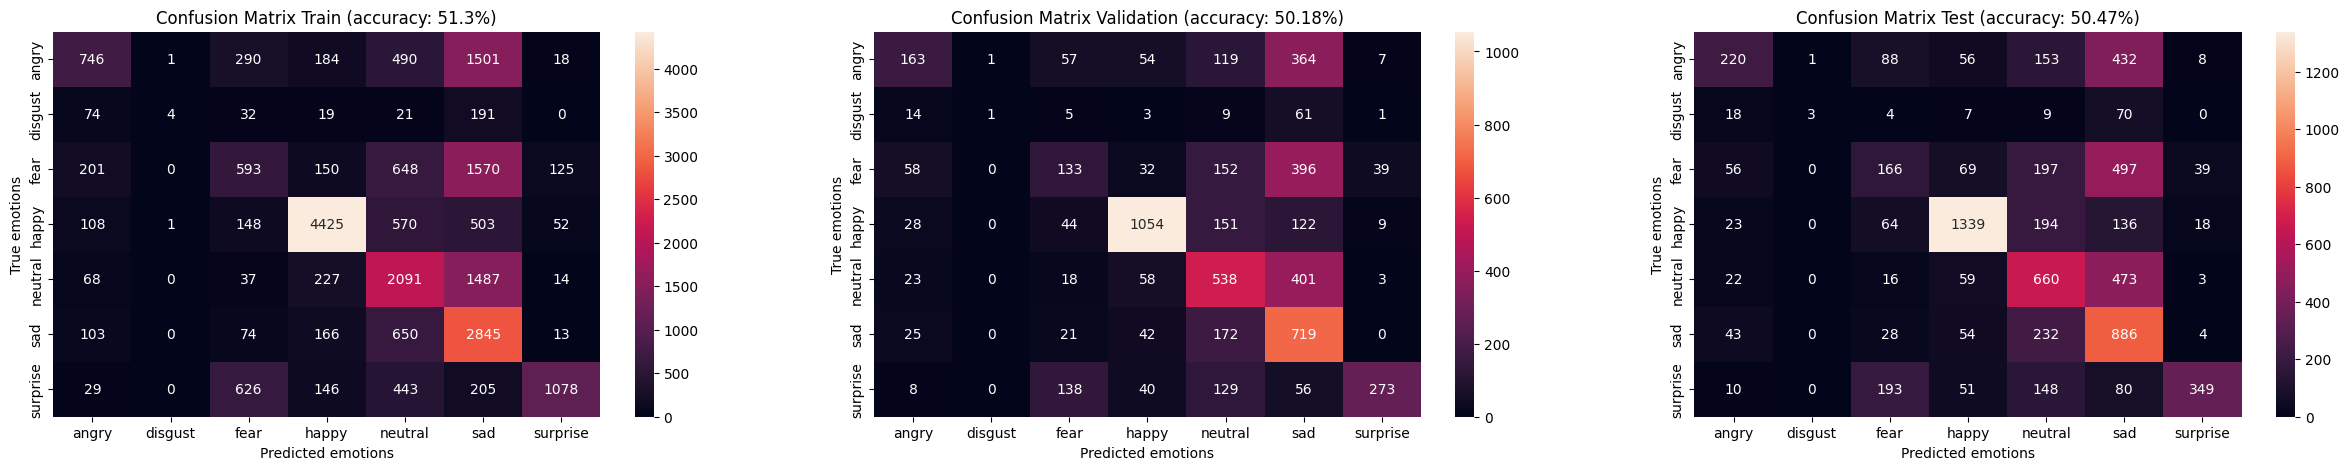

In [24]:
evaluate(model,history2,ds_train,ds_val,ds_test,one_hot_encoded=True)

## Label smoothing

---

In [28]:
model = load_model('models/augmented3.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy'],
)

In [ ]:
# history = model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=5,
# )
# model.save('models/label_smoothed.h5')
# with open('models/history_label_smoothed.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [75]:
model = load_model('models/label_smoothed.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_label_smoothed.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
180/180 [==============================] - 12s 67ms/step
Calculating validation results:
45/45 [==============================] - 3s 70ms/step
Calculating test results:
57/57 [==============================] - 4s 70ms/step


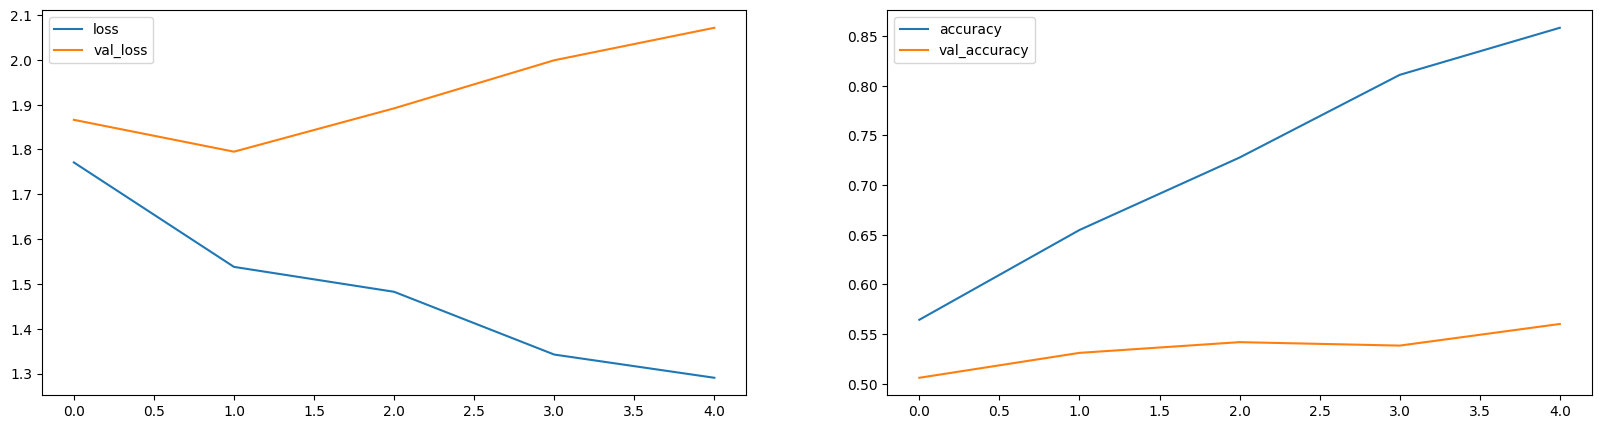

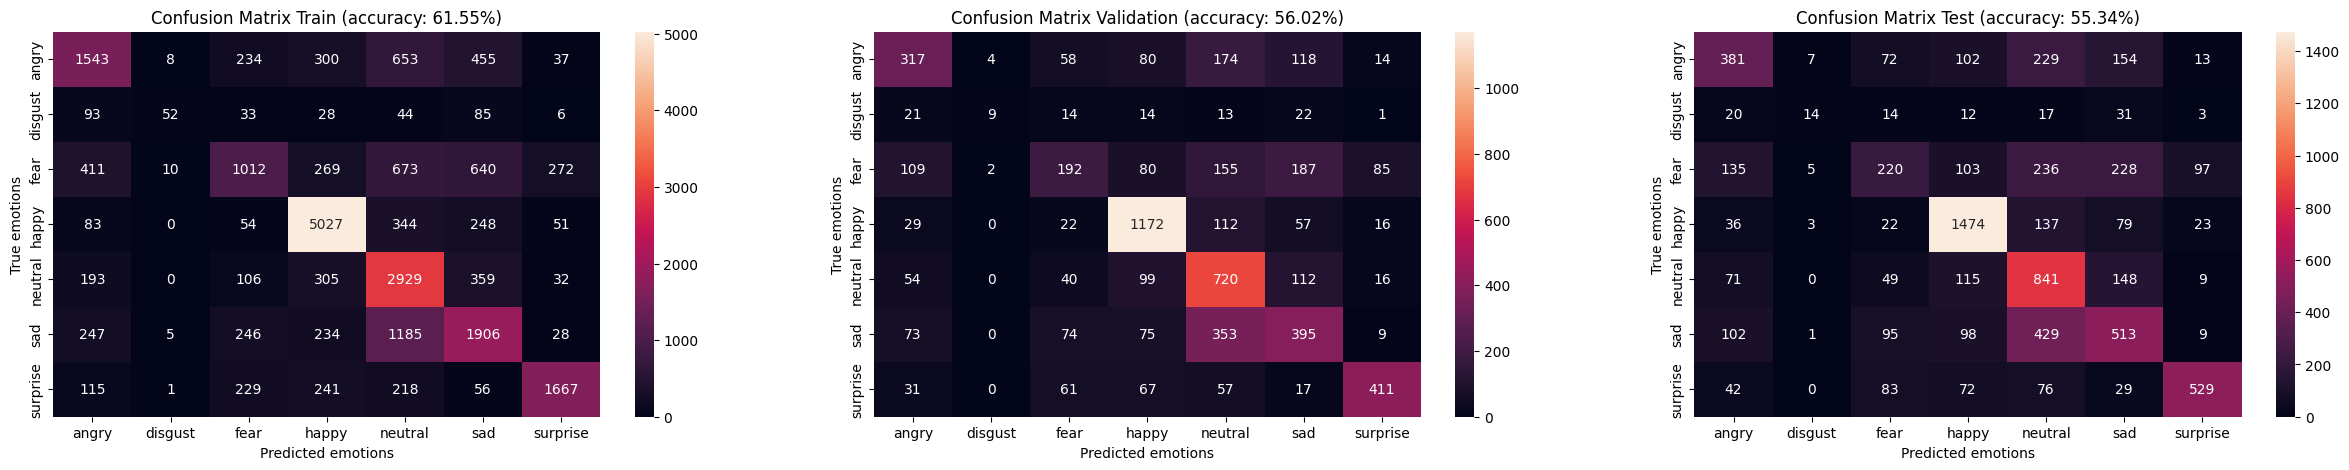

In [76]:
evaluate(model,history2,ds_train,ds_val,ds_test,one_hot_encoded=True)

In [29]:
model = load_model('models/augmented3.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss=CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy'],
)

In [30]:
# history = model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=5,
# )
# model.save('models/label_smoothed2.h5')
# with open('models/history_label_smoothed2.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
180/180 [==============================] - 48s 261ms/step - loss: 1.8823 - accuracy: 0.5346 - val_loss: 1.8491 - val_accuracy: 0.5058
Epoch 2/5
180/180 [==============================] - 45s 252ms/step - loss: 1.7073 - accuracy: 0.6007 - val_loss: 1.8271 - val_accuracy: 0.5452
Epoch 3/5
180/180 [==============================] - 45s 251ms/step - loss: 1.7086 - accuracy: 0.6455 - val_loss: 1.8719 - val_accuracy: 0.5365
Epoch 4/5
180/180 [==============================] - 46s 254ms/step - loss: 1.6835 - accuracy: 0.6877 - val_loss: 1.8971 - val_accuracy: 0.5482
Epoch 5/5
180/180 [==============================] - 46s 254ms/step - loss: 1.6158 - accuracy: 0.7357 - val_loss: 1.9655 - val_accuracy: 0.5513


In [31]:
model = load_model('models/label_smoothed2.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_label_smoothed2.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
180/180 [==============================] - 13s 68ms/step
Calculating validation results:
45/45 [==============================] - 3s 71ms/step
Calculating test results:
57/57 [==============================] - 4s 70ms/step


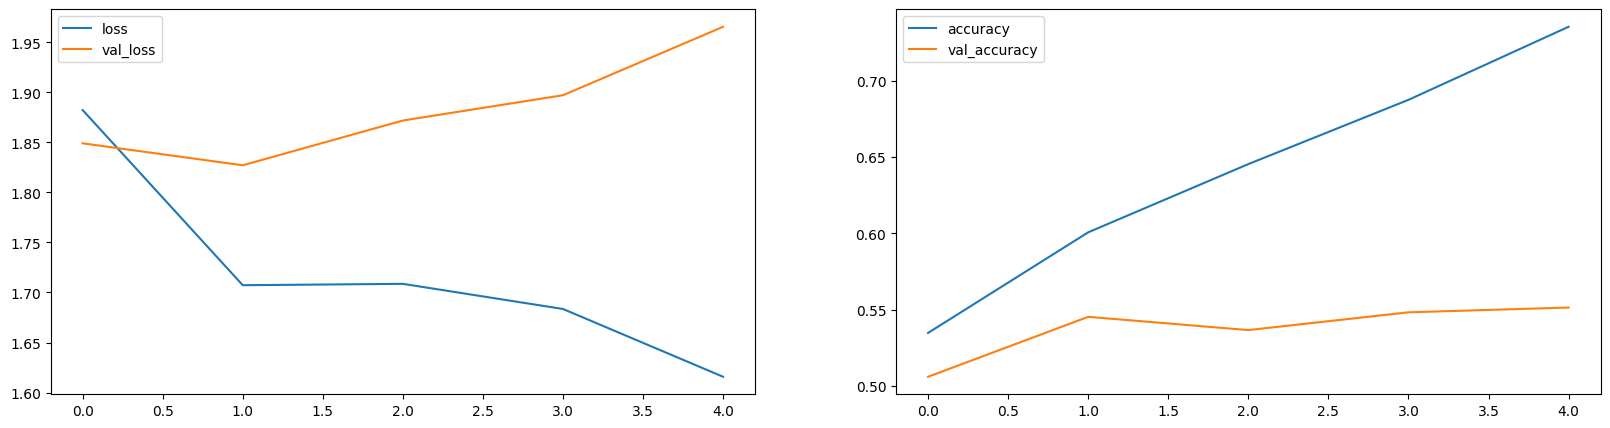

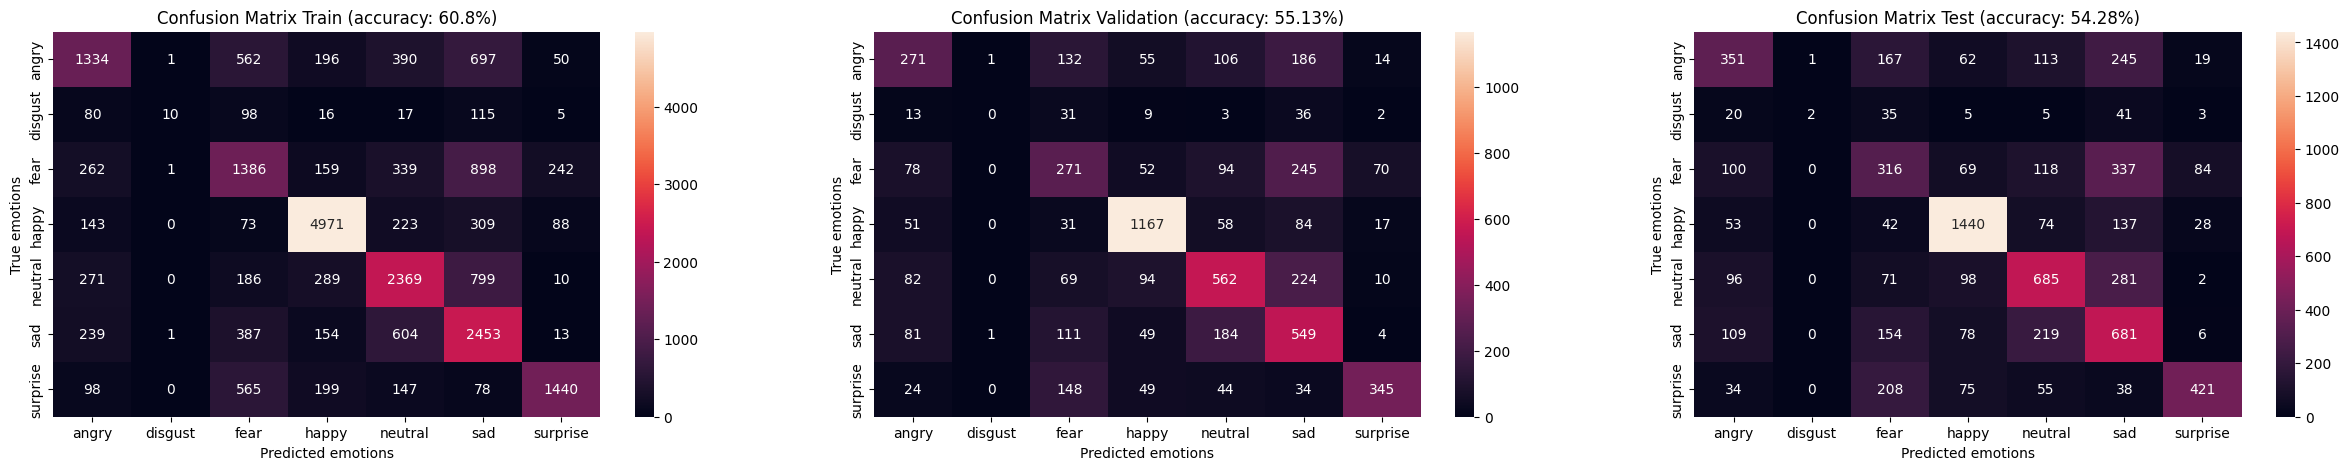

In [32]:
evaluate(model,history2,ds_train,ds_val,ds_test,one_hot_encoded=True)

In [34]:
model = load_model('models/augmented3.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss=CategoricalCrossentropy(label_smoothing=0.3),
    metrics=['accuracy'],
)

In [35]:
# history = model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=5,
# )
# model.save('models/label_smoothed3.h5')
# with open('models/history_label_smoothed3.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
180/180 [==============================] - 47s 255ms/step - loss: 1.9741 - accuracy: 0.5258 - val_loss: 2.0722 - val_accuracy: 0.4372
Epoch 2/5
180/180 [==============================] - 45s 252ms/step - loss: 1.8038 - accuracy: 0.5841 - val_loss: 1.8722 - val_accuracy: 0.5260
Epoch 3/5
180/180 [==============================] - 46s 254ms/step - loss: 1.7619 - accuracy: 0.6322 - val_loss: 1.8879 - val_accuracy: 0.5485
Epoch 4/5
180/180 [==============================] - 47s 261ms/step - loss: 1.7733 - accuracy: 0.6663 - val_loss: 1.9126 - val_accuracy: 0.5452
Epoch 5/5
180/180 [==============================] - 47s 263ms/step - loss: 1.7117 - accuracy: 0.7158 - val_loss: 2.0168 - val_accuracy: 0.5137


In [36]:
model = load_model('models/label_smoothed3.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_label_smoothed3.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
180/180 [==============================] - 13s 70ms/step
Calculating validation results:
45/45 [==============================] - 3s 72ms/step
Calculating test results:
57/57 [==============================] - 4s 72ms/step


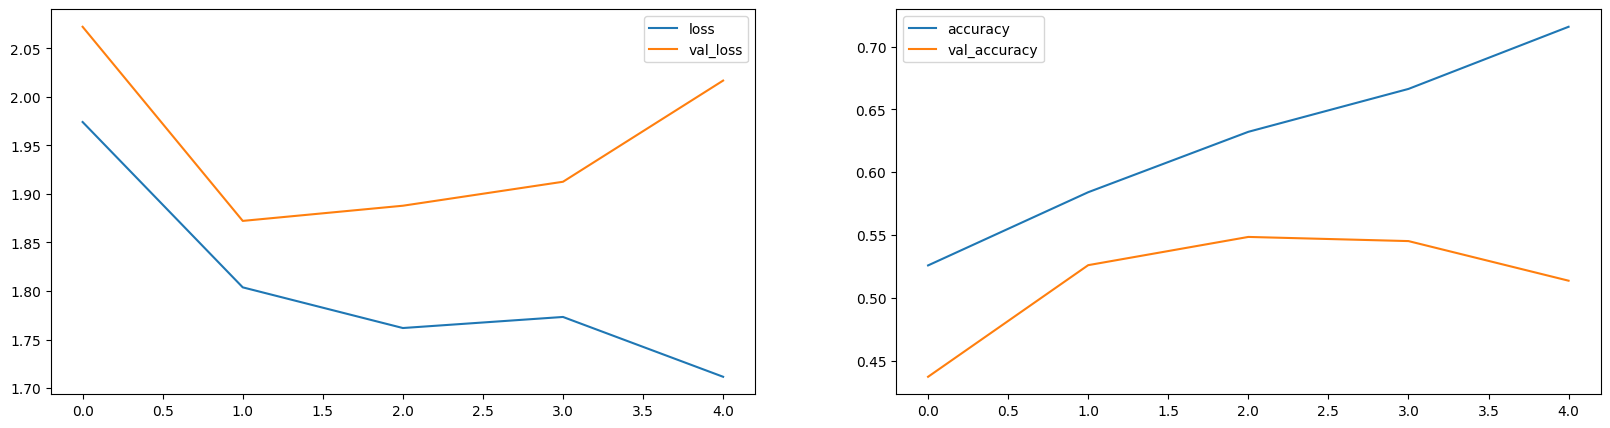

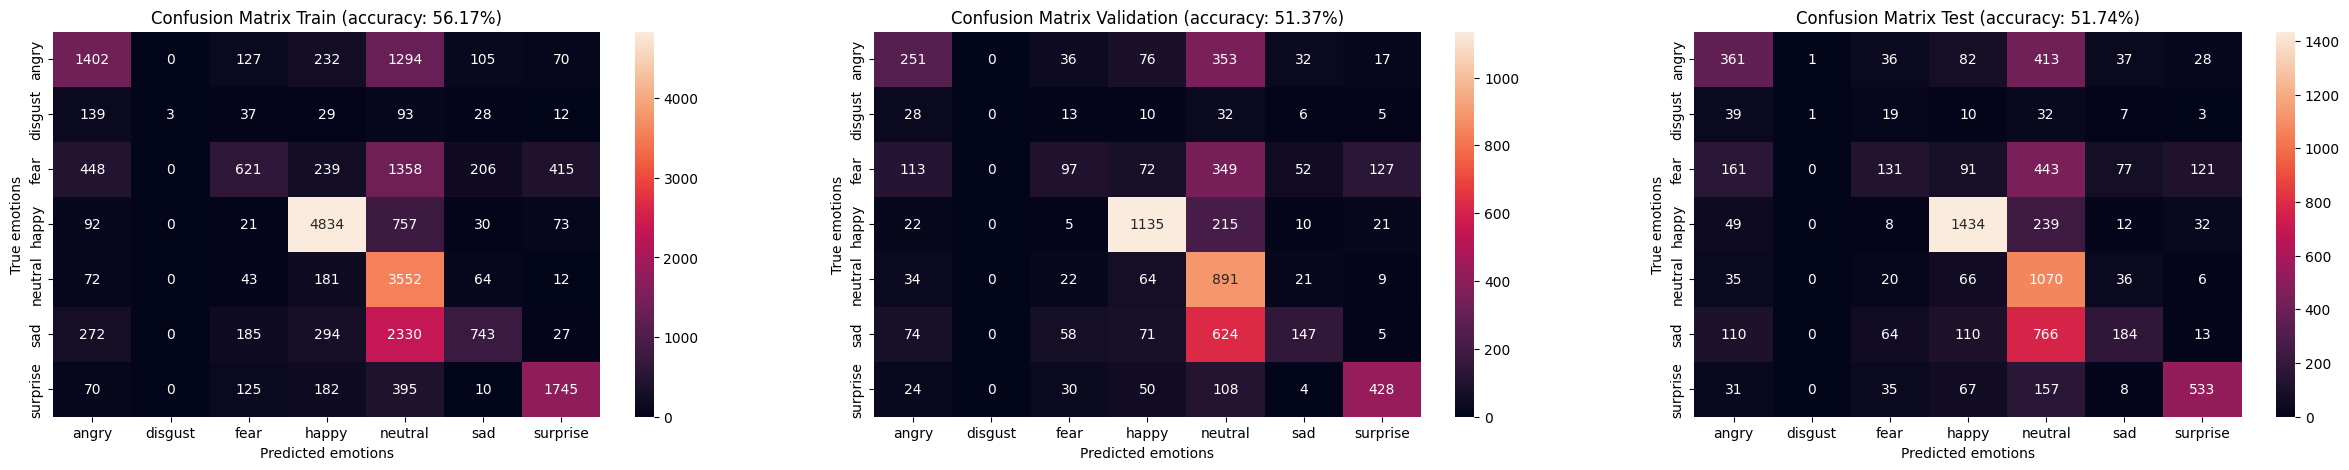

In [37]:
evaluate(model,history2,ds_train,ds_val,ds_test,one_hot_encoded=True)

## Test Time Augmentation

---

In [30]:
def predictWithTTA(test_set,model,data_generator,tta_steps=3,batch_size=128):
    x_test = getNumpyArray(test_set)
    predictions = []
    for i in tqdm(range(tta_steps)):
        preds = model.predict(data_generator.flow(x_test, batch_size=batch_size, shuffle=False), steps = len(x_test)/batch_size,verbose=0)
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)
    return predictions

def calculateAccuracyWithTTA(test_set,model,tta_steps=3):
    predictions = predictWithTTA(test_set,model,ImageDataGenerator(horizontal_flip=True,shear_range=5),tta_steps=tta_steps)
    int_predictions = np.argmax(predictions,axis=1)
    # print(f"Accuracy obtained with Test Time Augmentation is: {}%", flush=True)
    return round(100*accuracy_score(np.argmax(getLabels(test_set),axis=1), int_predictions),2)

In [42]:
model = load_model('models/label_smoothed.h5',custom_objects={'KerasLayer':hub.KerasLayer})
accuracy = calculateAccuracyWithTTA(ds_test,model)

100%|██████████| 3/3 [00:17<00:00,  5.95s/it]


In [43]:
print(f"Accuracy obtained with Test Time Augmentation is: {accuracy}%", flush=True)

Accuracy obtained with Test Time Augmentation is: 55.49%


In [40]:
model = load_model('models/label_smoothed.h5',custom_objects={'KerasLayer':hub.KerasLayer})
accuracy = calculateAccuracyWithTTA(ds_test,model,tta_steps=10)

100%|██████████| 10/10 [00:58<00:00,  5.84s/it]


In [41]:
print(f"Accuracy obtained with Test Time Augmentation is: {accuracy}%", flush=True)

Accuracy obtained with Test Time Augmentation is: 55.39%


In [44]:
model = load_model('models/label_smoothed.h5',custom_objects={'KerasLayer':hub.KerasLayer})
accuracy = calculateAccuracyWithTTA(ds_test,model,tta_steps=15)

100%|██████████| 15/15 [01:28<00:00,  5.88s/it]


In [45]:
print(f"Accuracy obtained with Test Time Augmentation is: {accuracy}%", flush=True)

Accuracy obtained with Test Time Augmentation is: 55.08%


In [46]:
model = load_model('models/label_smoothed.h5',custom_objects={'KerasLayer':hub.KerasLayer})
accuracy = calculateAccuracyWithTTA(ds_test,model,tta_steps=20)

100%|██████████| 20/20 [01:56<00:00,  5.84s/it]


In [47]:
print(f"Accuracy obtained with Test Time Augmentation is: {accuracy}%", flush=True)

Accuracy obtained with Test Time Augmentation is: 55.46%


# Fer2013+

---

## Preparing, loading and preprocessing data

---

joining both csv: fer2013 and fer2013 plus

In [ ]:
# fer = pd.read_csv('dataset_fer+/originals/fer2013.csv')
# fer_plus_labels = pd.read_csv('dataset_fer+/originals/fer2013new.csv')

# fer = fer.drop(['emotion','Usage'], axis=1)
# fer_plus_labels = fer_plus_labels.drop(['Image name'], axis=1)
# fer_plus = pd.concat([fer,fer_plus_labels], axis=1)
# training = fer_plus.loc[fer_plus['Usage'] == 'Training']
# validation = fer_plus.loc[fer_plus['Usage'] == 'PublicTest']
# test = fer_plus.loc[fer_plus['Usage'] == 'PrivateTest']
# training = training.drop(['Usage'], axis=1)
# validation = validation.drop(['Usage'], axis=1)
# test = test.drop(['Usage'], axis=1)

# training.to_csv("dataset_fer+/training.csv", index=False)
# validation.to_csv("dataset_fer+/validation.csv", index=False)
# test.to_csv("dataset_fer+/test.csv", index=False)

In [11]:
training = pd.read_csv('dataset_fer+/training.csv')
validation = pd.read_csv('dataset_fer+/validation.csv')
test = pd.read_csv('dataset_fer+/test.csv')

In [12]:
display(training)
display(validation)
display(test)

pixels  neutral  happiness  \
0      70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...        4          0   
1      151 150 147 155 148 133 111 140 170 174 182 15...        6          0   
2      231 212 156 164 174 138 161 173 182 200 106 38...        5          0   
3      24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...        4          0   
4      4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...        9          0   
...                                                  ...      ...        ...   
28704  84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...        0          0   
28705  114 112 113 113 111 111 112 113 115 113 114 11...        0          0   
28706  74 81 87 89 95 100 98 93 105 120 127 133 146 1...        0          0   
28707  222 227 203 90 86 90 84 77 94 87 99 119 134 14...        5          0   
28708  195 199 205 206 205 203 206 209 208 210 212 21...        7          0   

       surprise  sadness  anger  disgust  fear  contempt  unknown  NF  
0             0        1      3        2     0         0        0   0  
1             1        1      0        0     0         0        2   0  
2             0        3      1        0     0         0        1   0  
3             0        4      1        0     0         0        1   0  
4             0        1      0        0     0         0        0   0  
...         ...      ...    ...      ...   ...       ...      ...  ..  
28704         1        0      0        0     9         0        0   0  
28705         1        0      9        0     0         0        0   0  
28706         1        9      0        0     0         0        0   0  
28707         0        1      0        1     0         0        3   0  
28708         0        1      1        0     0         0        1   0  

[28709 rows x 11 columns]

pixels  neutral  happiness  \
0     254 254 254 254 254 249 255 160 2 58 53 70 77 ...        4          0   
1     156 184 198 202 204 207 210 212 213 214 215 21...        1          0   
2     69 118 61 60 96 121 103 87 103 88 70 90 115 12...        7          0   
3     205 203 236 157 83 158 120 116 94 86 155 180 2...        5          5   
4     87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...        0         10   
...                                                 ...      ...        ...   
3584  178 176 172 173 173 174 176 173 166 166 206 22...        3          0   
3585  25 34 42 44 42 47 57 59 59 58 54 51 50 56 63 6...        0         10   
3586  255 255 255 255 255 255 255 255 255 255 255 25...        4          0   
3587  33 25 31 36 36 42 69 103 132 163 175 183 187 1...        8          0   
3588  61 63 59 75 151 159 166 161 143 170 127 131 18...        8          0   

      surprise  sadness  anger  disgust  fear  contempt  unknown  NF  
0            0        0      1        0     0         4        1   0  
1            0        1      0        2     0         6        0   0  
2            0        0      2        0     0         1        0   0  
3            0        0      0        0     0         0        0   0  
4            0        0      0        0     0         0        0   0  
...        ...      ...    ...      ...   ...       ...      ...  ..  
3584         1        4      0        0     0         0        2   0  
3585         0        0      0        0     0         0        0   0  
3586         0        4      1        0     0         0        1   0  
3587         0        1      0        0     0         1        0   0  
3588         0        2      0        0     0         0        0   0  

[3589 rows x 11 columns]

pixels  neutral  happiness  \
0     170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...        0          0   
1     7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...        0          0   
2     232 240 241 239 237 235 246 117 24 24 22 13 12...        3          0   
3     200 197 149 139 156 89 111 58 62 95 113 117 11...        6          0   
4     40 28 33 56 45 33 31 78 152 194 200 186 196 20...        0          0   
...                                                 ...      ...        ...   
3584  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...        8          0   
3585  178 174 172 173 181 188 191 194 196 199 200 20...        0          0   
3586  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...        0          0   
3587  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...        0         10   
3588  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...        2          0   

      surprise  sadness  anger  disgust  fear  contempt  unknown  NF  
0            0        0      2        1     0         7        0   0  
1            0        0      0        0     0         0        0  10  
2            0        5      0        0     0         0        2   0  
3            1        2      0        0     0         0        1   0  
4            4        0      1        2     3         0        0   0  
...        ...      ...    ...      ...   ...       ...      ...  ..  
3584         0        2      0        0     0         0        0   0  
3585         0        0      0        0     0         0        0  10  
3586         0        0      7        1     0         2        0   0  
3587         0        0      0        0     0         0        0   0  
3588         0        5      1        1     0         0        1   0  

[3589 rows x 11 columns]

In [13]:
def convertPixelsAsStringWithSpacesToNumpyArrayOfInt(pixels):
    pixels = pixels.split(" ")
    pixels = np.array(list(map(int, pixels))).reshape(48,48)
    pixels = np.dstack((pixels,pixels,pixels))
    return pixels

splits = [training,validation,test]
for split in splits:
    for n_image in tqdm(range(split.shape[0])):
        split.iloc[n_image,0] = [convertPixelsAsStringWithSpacesToNumpyArrayOfInt(split.iloc[n_image,0])]

100%|██████████| 3589/3589 [00:01<00:00, 3391.80it/s]


In [14]:
def getInside(list):
    return list[0]

In [15]:
training = training[training.unknown == 0]
training = training[training.NF == 0]
validation = validation[validation.unknown == 0]
validation = validation[validation.NF == 0]
test = test[test.unknown == 0]
test = test[test.NF == 0]

X_train_plus = np.array(list(training.iloc[:,0].map(getInside)))/255
X_val_plus = np.array(list(validation.iloc[:,0].map(getInside)))/255
X_test_plus = np.array(list(test.iloc[:,0].map(getInside)))/255
class_names_plus = list(training.iloc[:,-10:-2].columns)

In [16]:
bs = 64
ds_train_plus = tf.data.Dataset.from_tensor_slices((X_train_plus, training.iloc[:,-10:-2])).batch(bs)
ds_val_plus = tf.data.Dataset.from_tensor_slices((X_val_plus, validation.iloc[:,-10:-2])).batch(bs)
ds_test_plus = tf.data.Dataset.from_tensor_slices((X_test_plus, test.iloc[:,-10:-2])).batch(bs)

ds_train_plus = (
    ds_train_plus
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_val_plus = (
    ds_val_plus
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test_plus = (
    ds_test_plus
    .map(convertToFloat)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Insights

---

## ResNet transfer learning

---

In [43]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224))),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
                                            trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names_plus), activation='softmax')
])

model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             multiple                  0         
                                                                 
 keras_layer (KerasLayer)    multiple                  23561152  
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               multiple                  524544    
                                                                 
 dropout (Dropout)           multiple                  0         
                                                        

In [44]:
# history = model.fit(
#     ds_train_plus,
#     validation_data=ds_val_plus,
#     epochs=30,
# )
# model.save('models/resnet+.h5')
# with open('models/history_resnet+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/30
297/297 [==============================] - 174s 575ms/step - loss: 15.9421 - accuracy: 0.5099 - val_loss: 11.5430 - val_accuracy: 0.6649
Epoch 2/30
297/297 [==============================] - 179s 604ms/step - loss: 10.2775 - accuracy: 0.7329 - val_loss: 10.7477 - val_accuracy: 0.6972
Epoch 3/30
297/297 [==============================] - 184s 621ms/step - loss: 8.4304 - accuracy: 0.8230 - val_loss: 10.3625 - val_accuracy: 0.7099
Epoch 4/30
297/297 [==============================] - 186s 627ms/step - loss: 7.4518 - accuracy: 0.8729 - val_loss: 10.4510 - val_accuracy: 0.7050
Epoch 5/30
297/297 [==============================] - 187s 630ms/step - loss: 7.0984 - accuracy: 0.8883 - val_loss: 10.3830 - val_accuracy: 0.7091
Epoch 6/30
297/297 [==============================] - 194s 653ms/step - loss: 6.8511 - accuracy: 0.8951 - val_loss: 10.3233 - val_accuracy: 0.7185
Epoch 7/30
297/297 [==============================] - 195s 657ms/step - loss: 6.5476 - accuracy: 0.9084 - val_loss: 

In [45]:
model = load_model('models/resnet+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_resnet+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 150s 502ms/step
Calculating validation results:
42/42 [==============================] - 22s 526ms/step
Calculating test results:
33/33 [==============================] - 18s 553ms/step


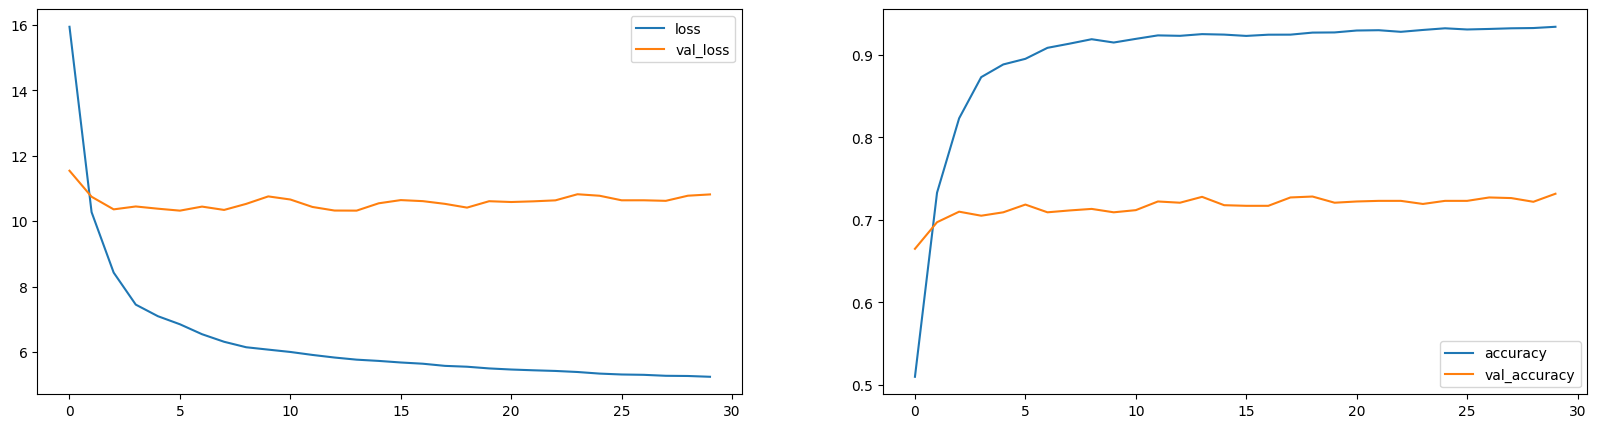

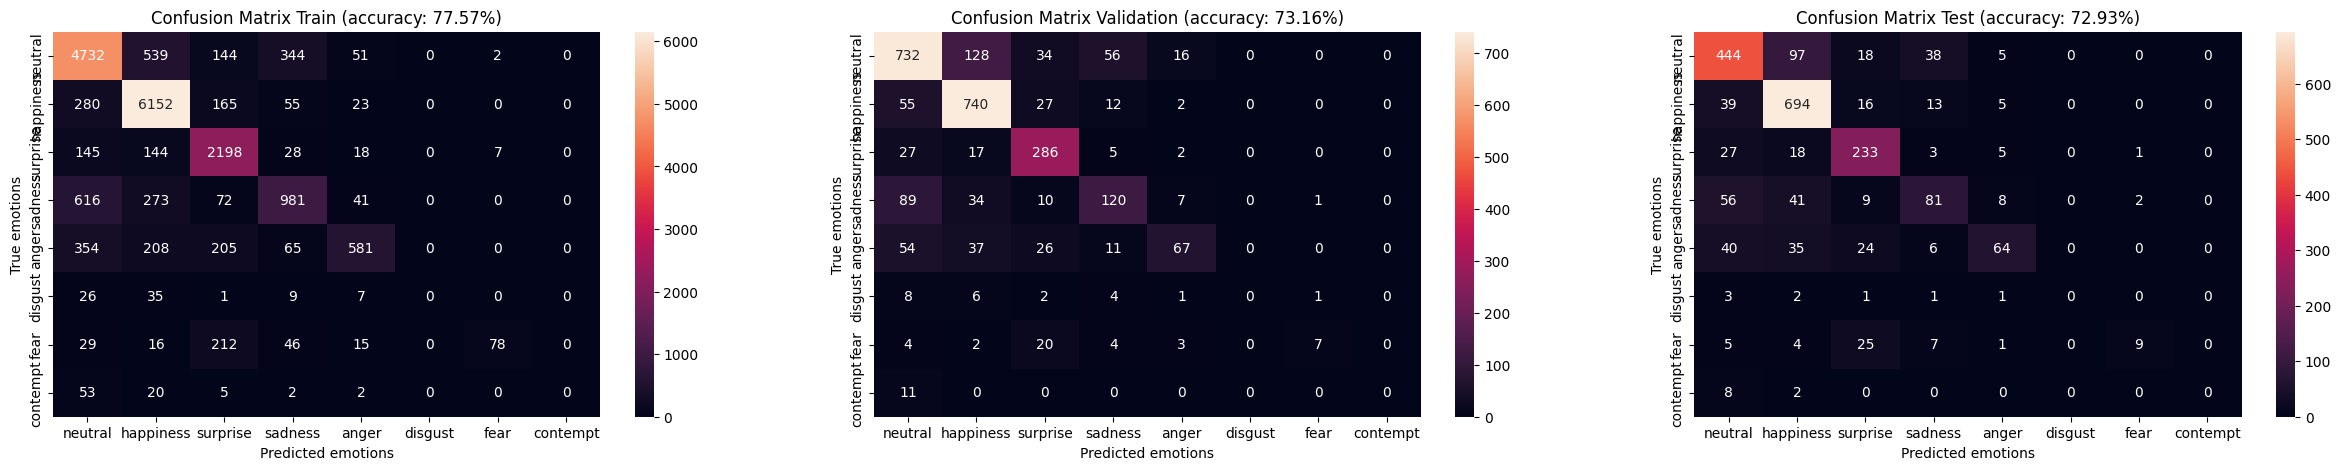

In [46]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,class_names_variable=class_names_plus,one_hot_encoded=True)

## Fine tuning

---

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224))),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
                                            trainable=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names_plus), activation='softmax')
])

model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           multiple                  0         
                                                                 
 keras_layer_1 (KerasLayer)  multiple                  23561152  
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 batch_normalization_4 (Batc  multiple                 8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             multiple                  524544    
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                      

In [48]:
# history = model.fit(
#     ds_train_plus,
#     validation_data=ds_val_plus,
#     epochs=5,
# )
# model.save('models/resnet_fine_tuned+.h5')
# with open('models/history_resnet_fine_tuned+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
297/297 [==============================] - 724s 2s/step - loss: 15.3407 - accuracy: 0.5629 - val_loss: 12.2011 - val_accuracy: 0.6717
Epoch 2/5
297/297 [==============================] - 716s 2s/step - loss: 10.4924 - accuracy: 0.7400 - val_loss: 10.5093 - val_accuracy: 0.7020
Epoch 3/5
297/297 [==============================] - 733s 2s/step - loss: 9.1273 - accuracy: 0.8019 - val_loss: 9.6650 - val_accuracy: 0.7541
Epoch 4/5
297/297 [==============================] - 765s 3s/step - loss: 8.3721 - accuracy: 0.8359 - val_loss: 10.5880 - val_accuracy: 0.6709
Epoch 5/5
297/297 [==============================] - 774s 3s/step - loss: 7.9022 - accuracy: 0.8583 - val_loss: 8.6232 - val_accuracy: 0.7950


In [49]:
model = load_model('models/resnet_fine_tuned+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_resnet_fine_tuned+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 149s 499ms/step
Calculating validation results:
42/42 [==============================] - 21s 517ms/step
Calculating test results:
33/33 [==============================] - 17s 539ms/step


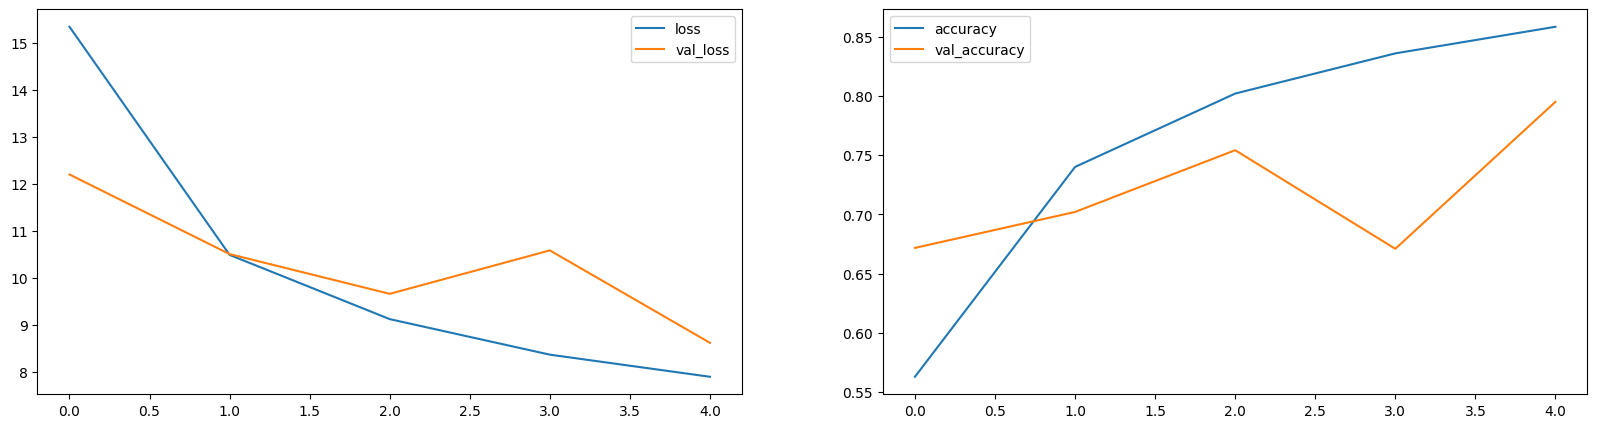

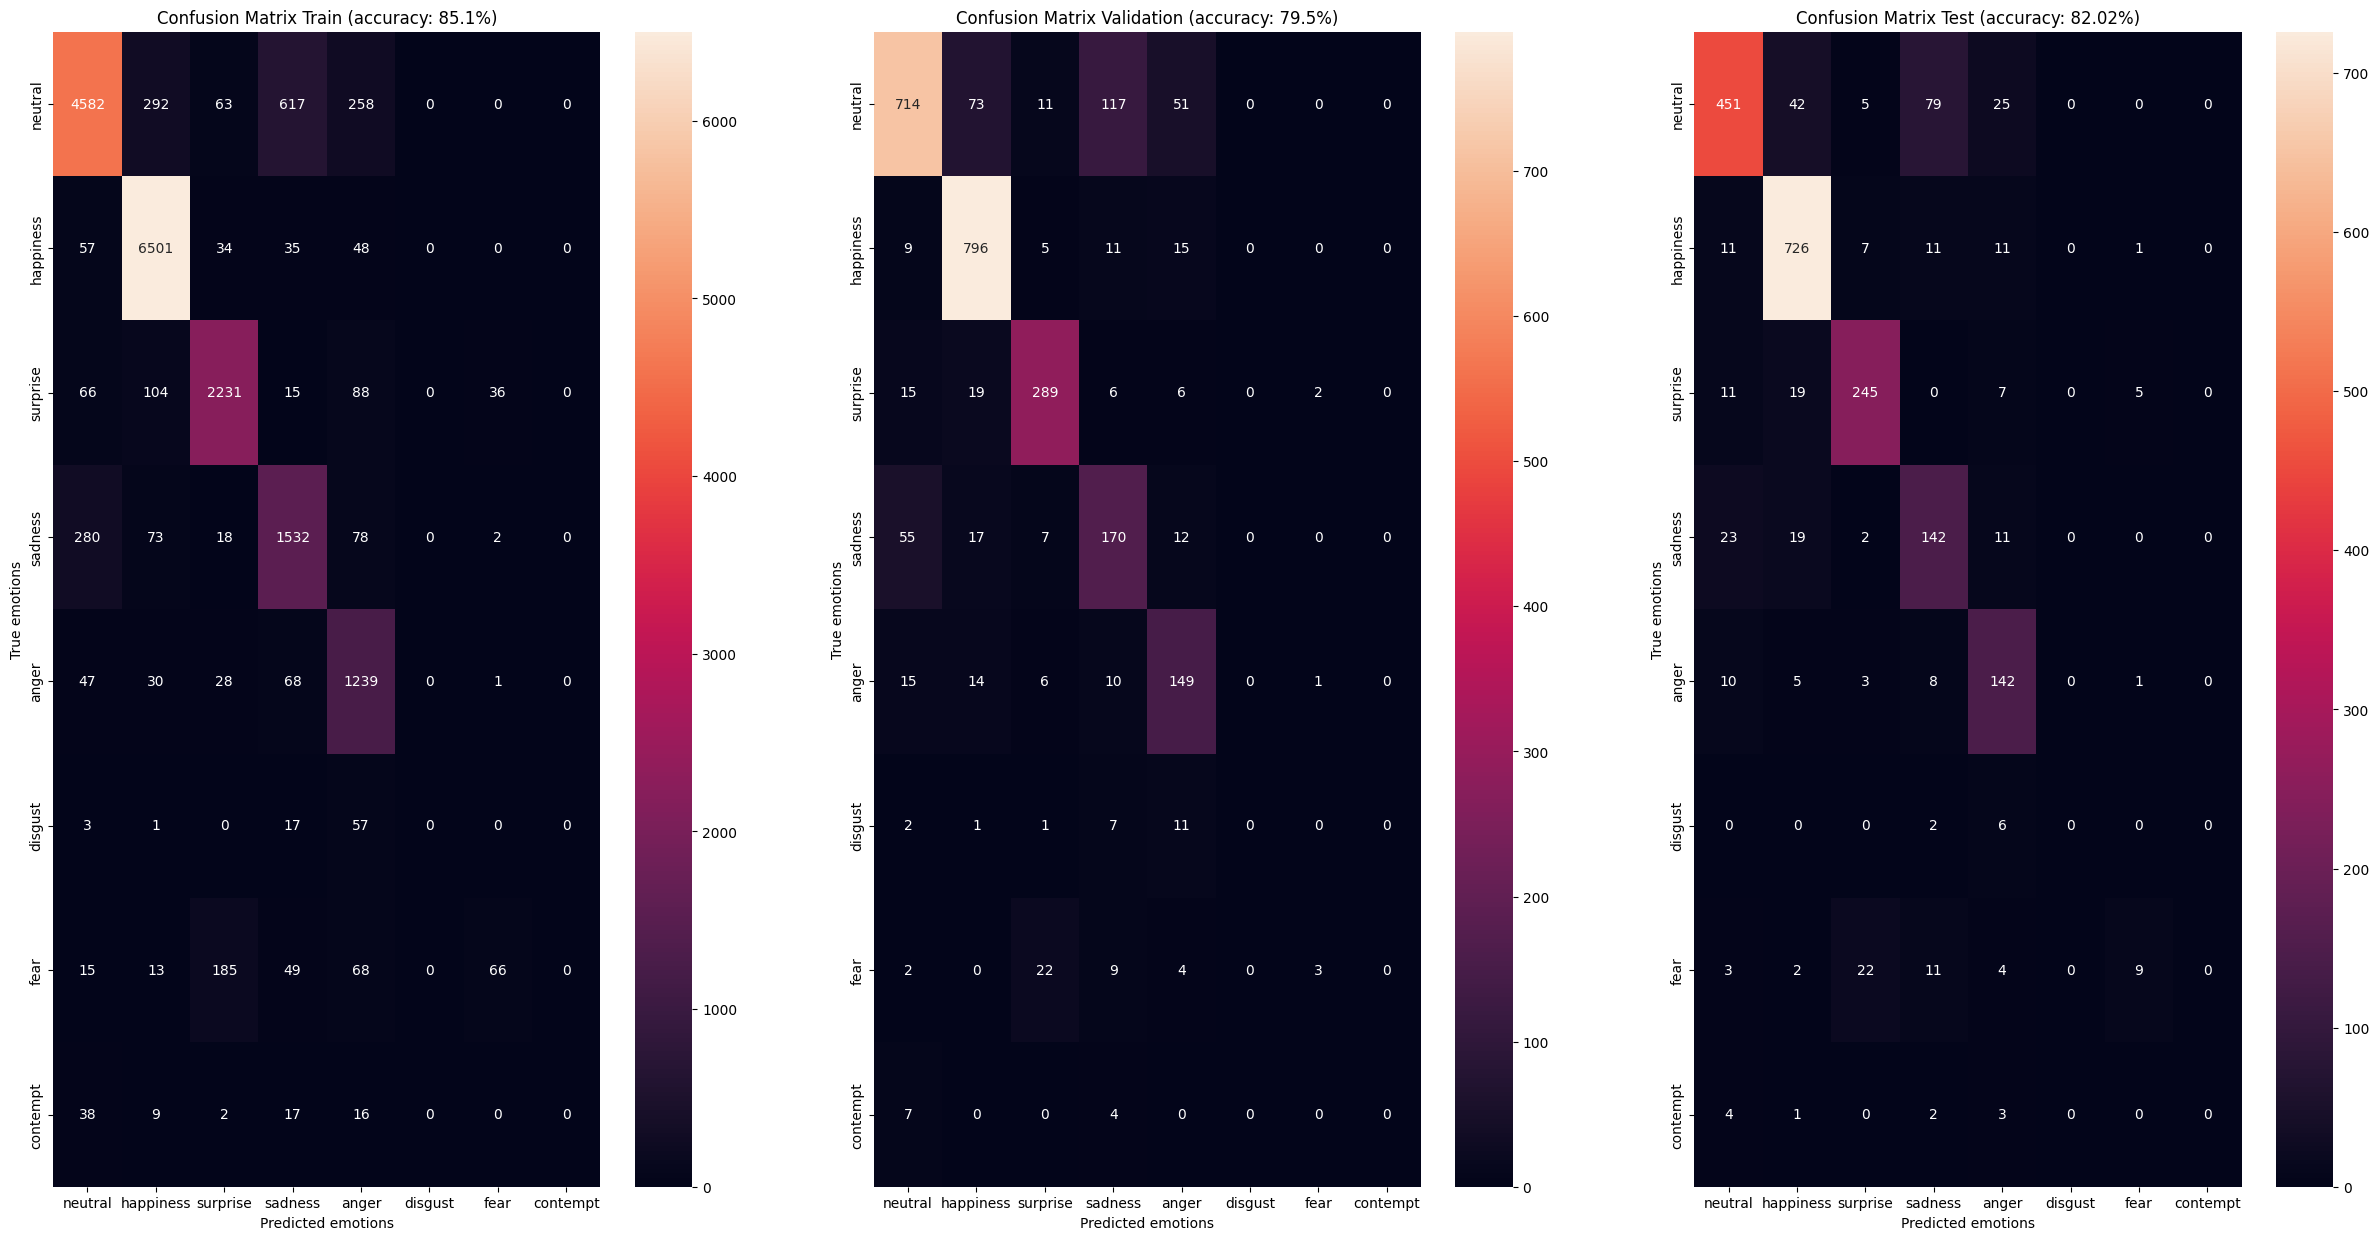

In [50]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,class_names_variable=class_names_plus,one_hot_encoded=True,isPlus=True)

## Customized CNN

---

In [19]:
tf.random.set_seed(1)
model= tf.keras.models.Sequential([
    preprocessing.Normalization(),

    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(64,(3,3), padding='same', activation='relu' ),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128,(5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
        
    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),
        
    Dense(512,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(len(class_names_plus), activation='softmax')
])
model.build([None, 48, 48, 3])
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
# history = model.fit(
#     ds_train_plus,
#     validation_data=ds_val_plus,
#     epochs=30,
# )
# model.save('models/custom+.h5')
# with open('models/history_custom+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [26]:
model = load_model('models/custom+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_custom+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 12s 40ms/step
Calculating validation results:
42/42 [==============================] - 2s 41ms/step
Calculating test results:
33/33 [==============================] - 1s 42ms/step


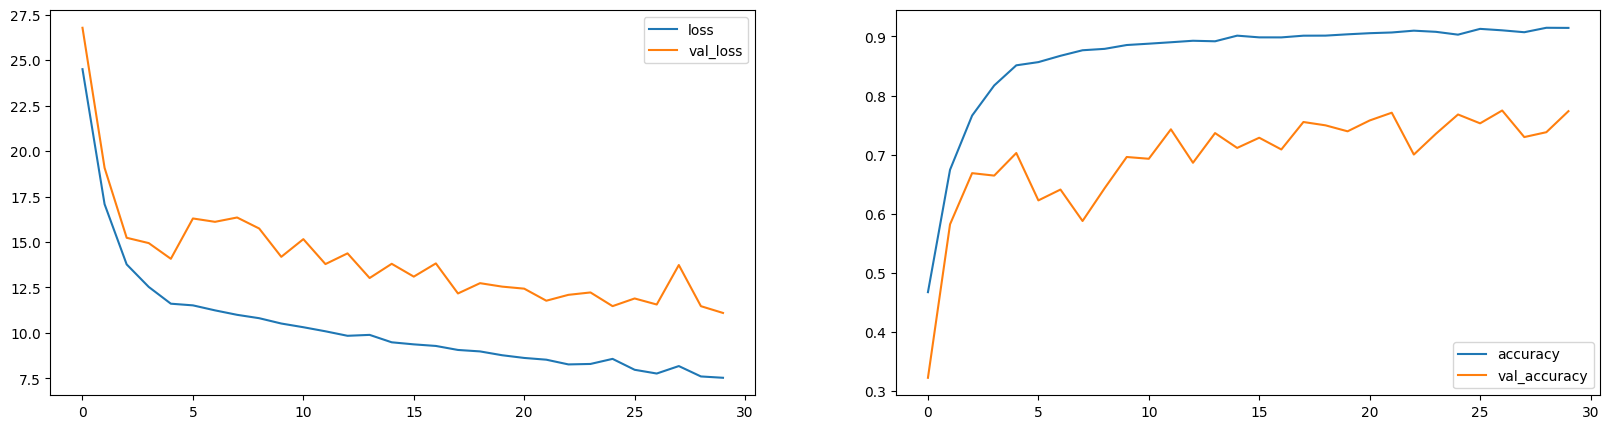

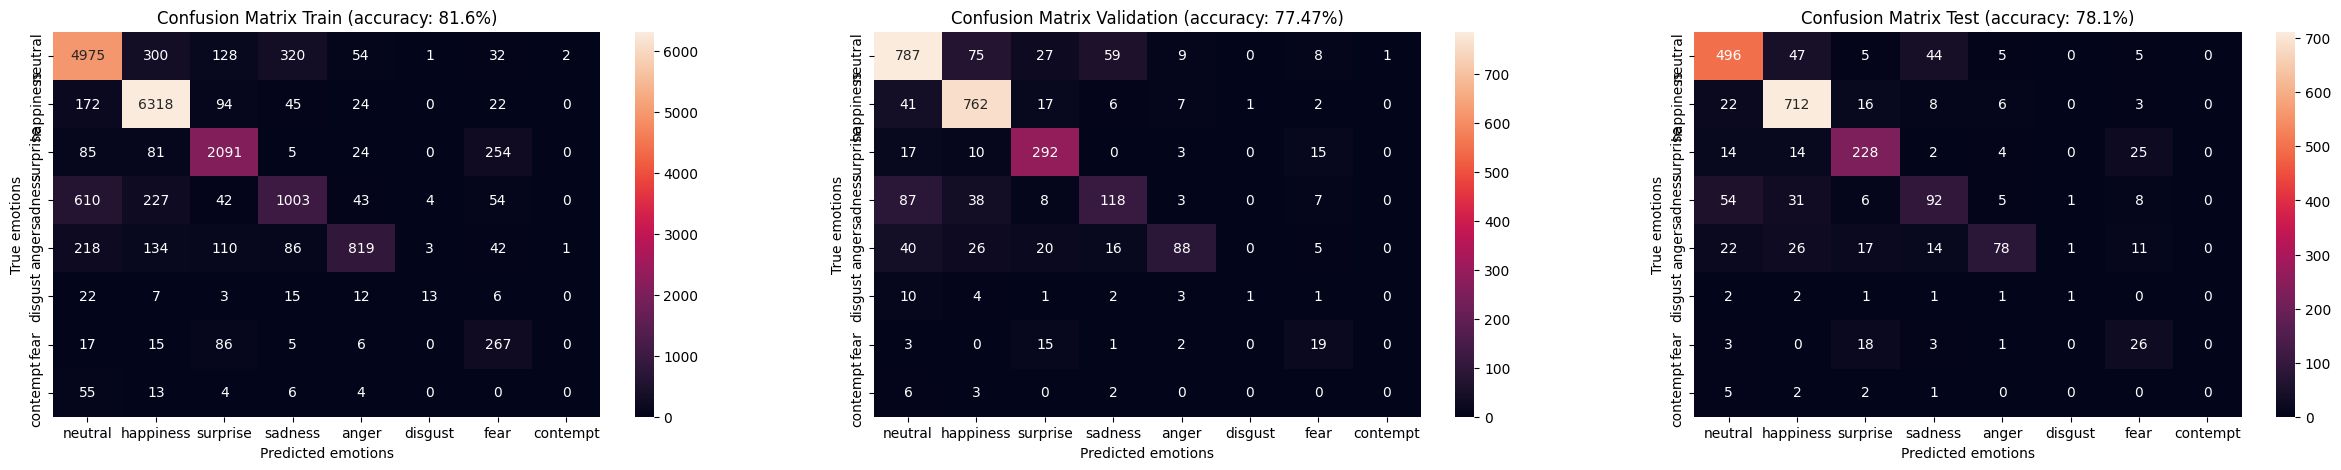

In [55]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,class_names_variable=class_names_plus,one_hot_encoded=True)

## Data Augmentation

---

In [18]:
y_train_plus = getLabels(ds_train_plus)
y_val_plus = getLabels(ds_val_plus)
y_test_plus = getLabels(ds_test_plus)

In [59]:
# model = load_model('models/custom+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(horizontal_flip=True,
#                                    shear_range=5)
# train_datagen.fit(X_train_plus)

# history = model.fit(train_datagen.flow(X_train_plus, y_train_plus),
#                               epochs=5,
#                               validation_data=ds_val_plus)
# model.save('models/augmented+.h5')
# with open('models/history_augmented+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [60]:
model = load_model('models/augmented+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 12s 40ms/step
Calculating validation results:
42/42 [==============================] - 2s 42ms/step
Calculating test results:
33/33 [==============================] - 1s 43ms/step


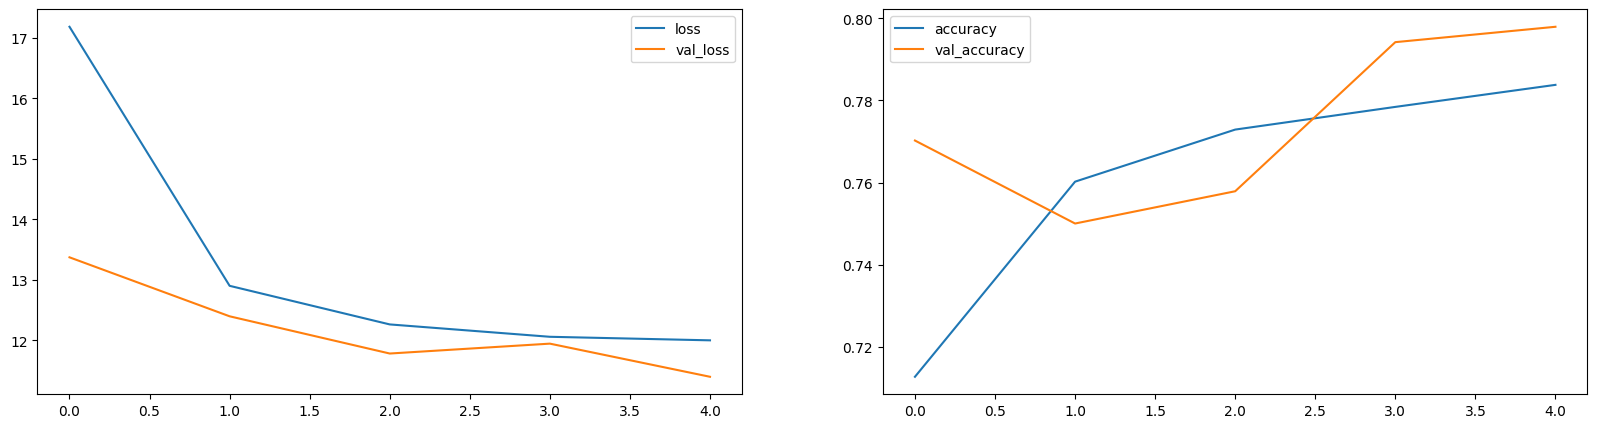

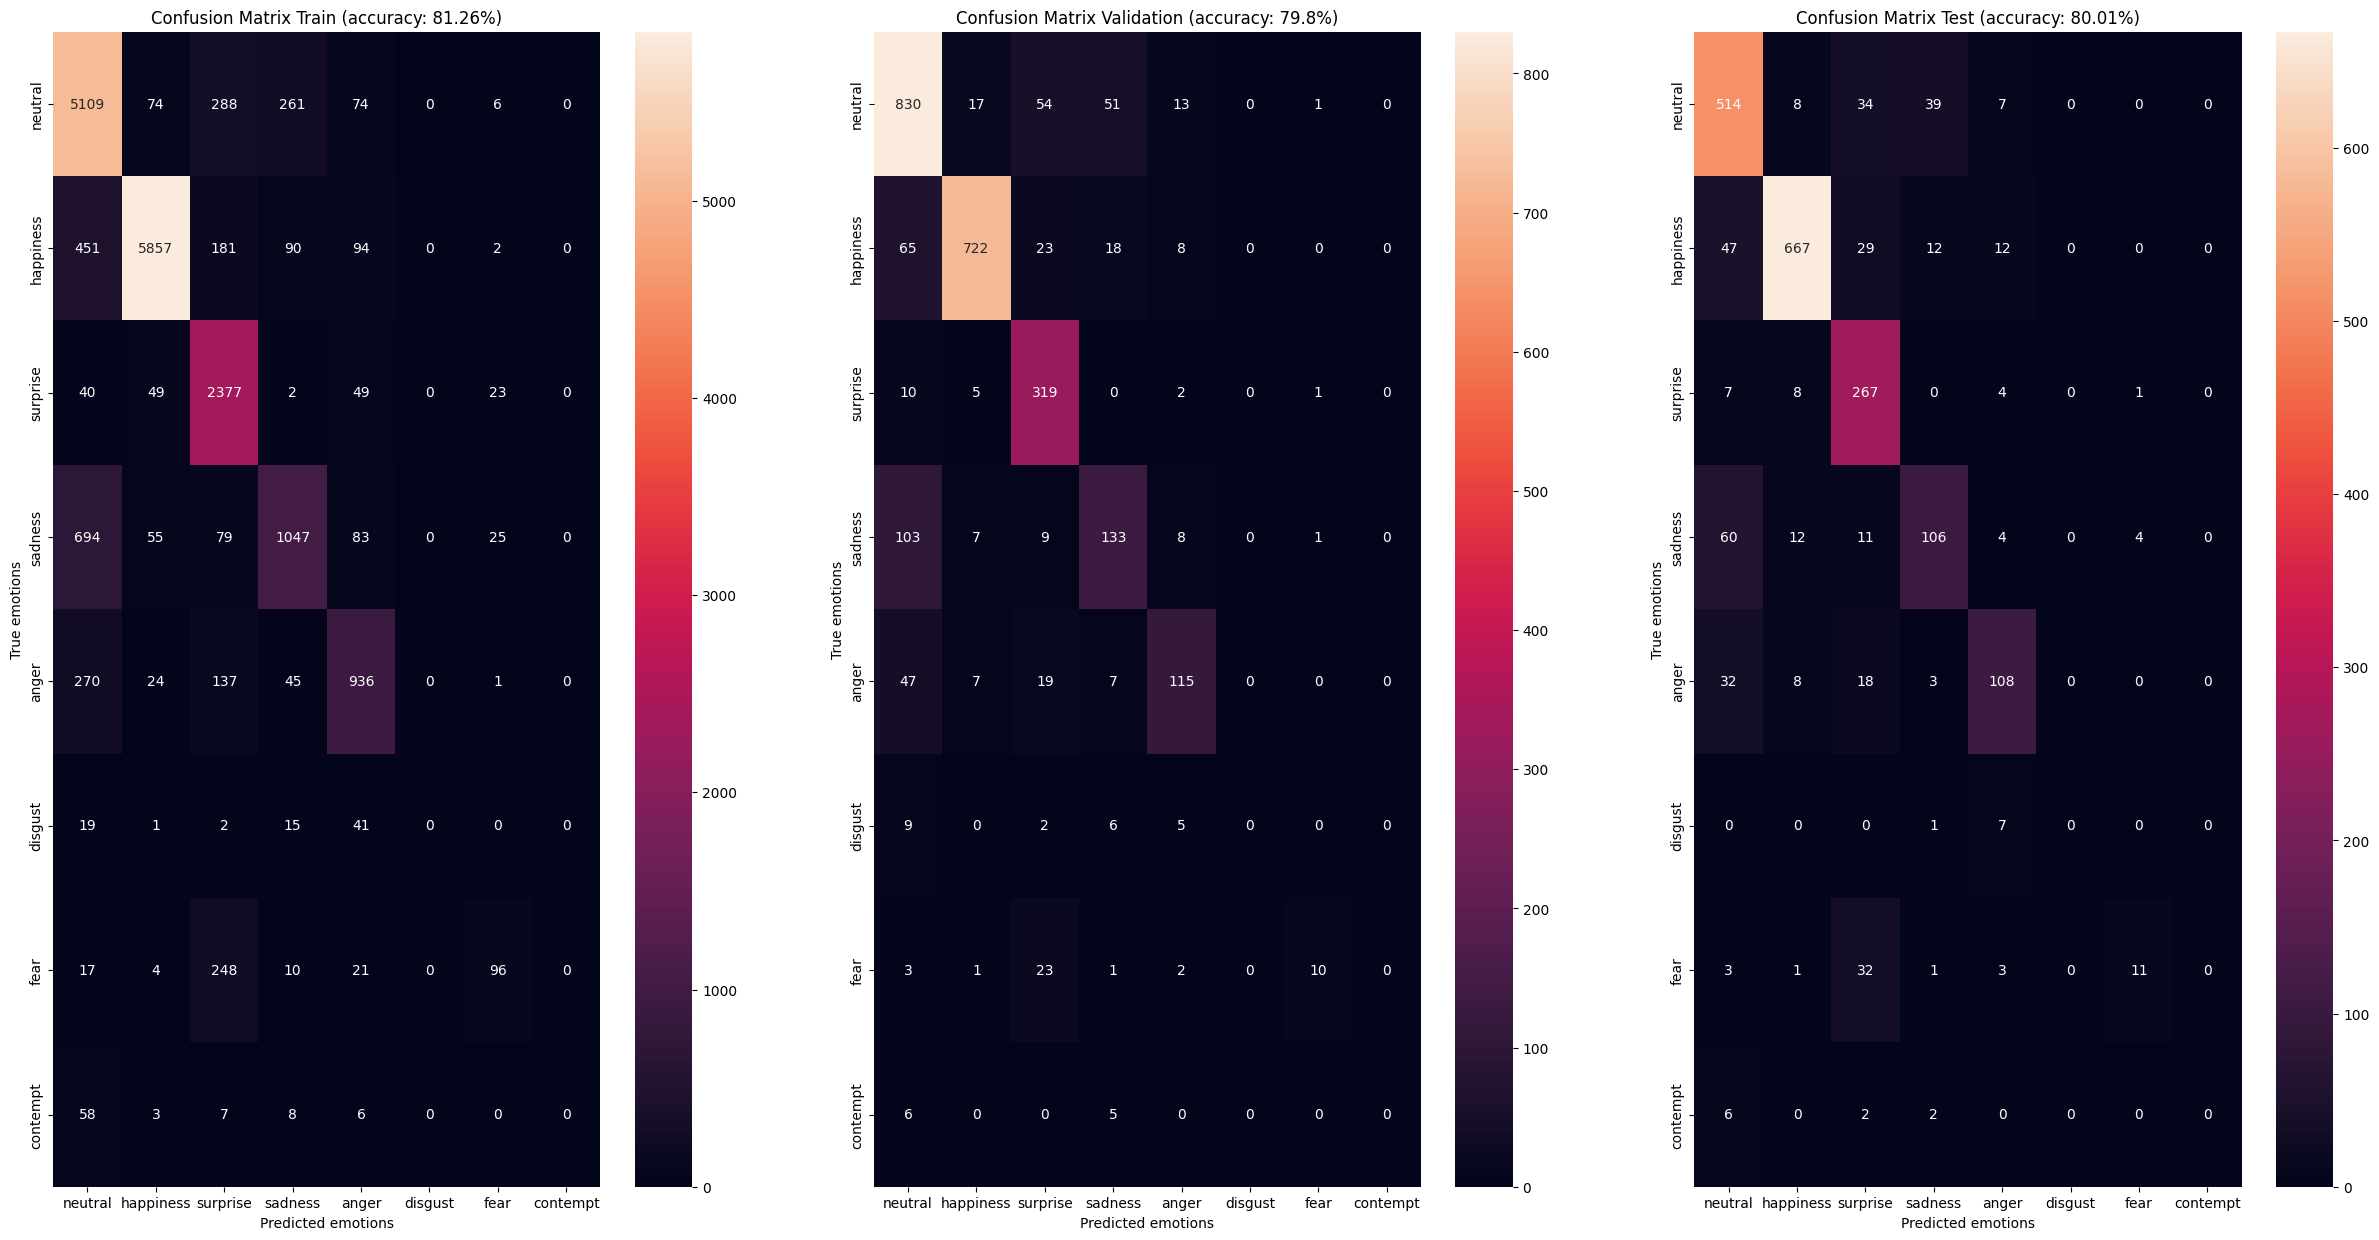

In [61]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

In [62]:
# model = load_model('models/custom+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(horizontal_flip=True,
#                                    shear_range=10)
# train_datagen.fit(X_train_plus)

# history = model.fit(train_datagen.flow(X_train_plus, y_train_plus),
#                               epochs=5,
#                               validation_data=ds_val_plus)
# model.save('models/augmented2+.h5')
# with open('models/history_augmented2+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
594/594 [==============================] - 55s 90ms/step - loss: 18.7299 - accuracy: 0.6918 - val_loss: 14.8537 - val_accuracy: 0.7549
Epoch 2/5
594/594 [==============================] - 52s 88ms/step - loss: 13.9220 - accuracy: 0.7538 - val_loss: 12.4083 - val_accuracy: 0.7916
Epoch 3/5
594/594 [==============================] - 53s 89ms/step - loss: 12.5901 - accuracy: 0.7635 - val_loss: 11.4243 - val_accuracy: 0.7931
Epoch 4/5
594/594 [==============================] - 52s 88ms/step - loss: 11.8166 - accuracy: 0.7787 - val_loss: 10.7537 - val_accuracy: 0.8017
Epoch 5/5
594/594 [==============================] - 52s 88ms/step - loss: 11.6994 - accuracy: 0.7794 - val_loss: 12.9590 - val_accuracy: 0.7511


In [63]:
model = load_model('models/augmented2+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented2+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 12s 41ms/step
Calculating validation results:
42/42 [==============================] - 2s 42ms/step
Calculating test results:
33/33 [==============================] - 1s 42ms/step


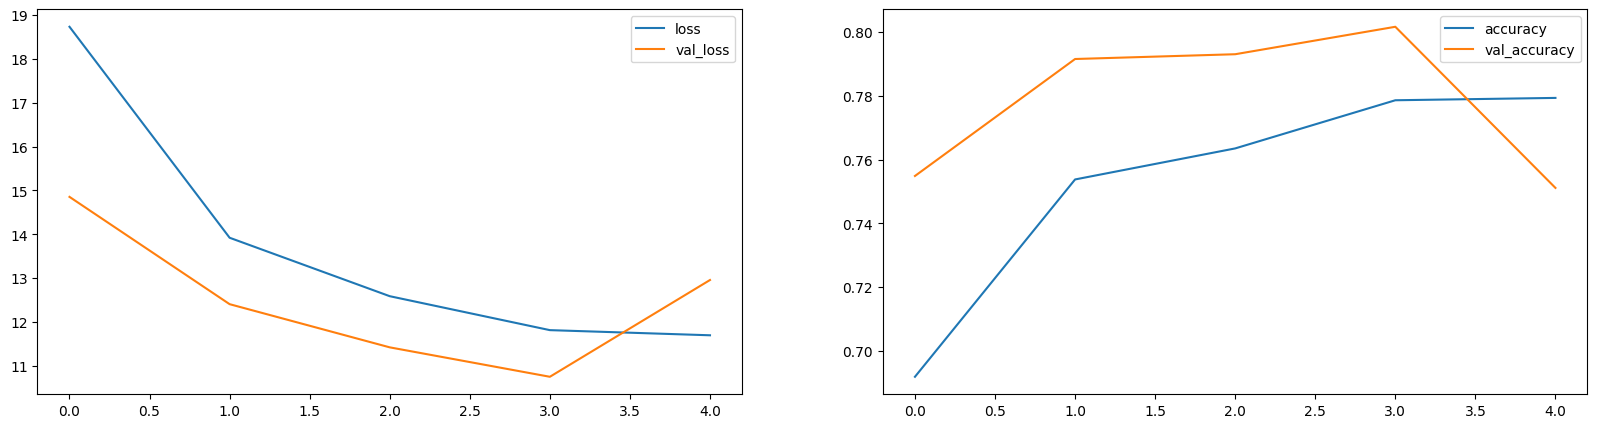

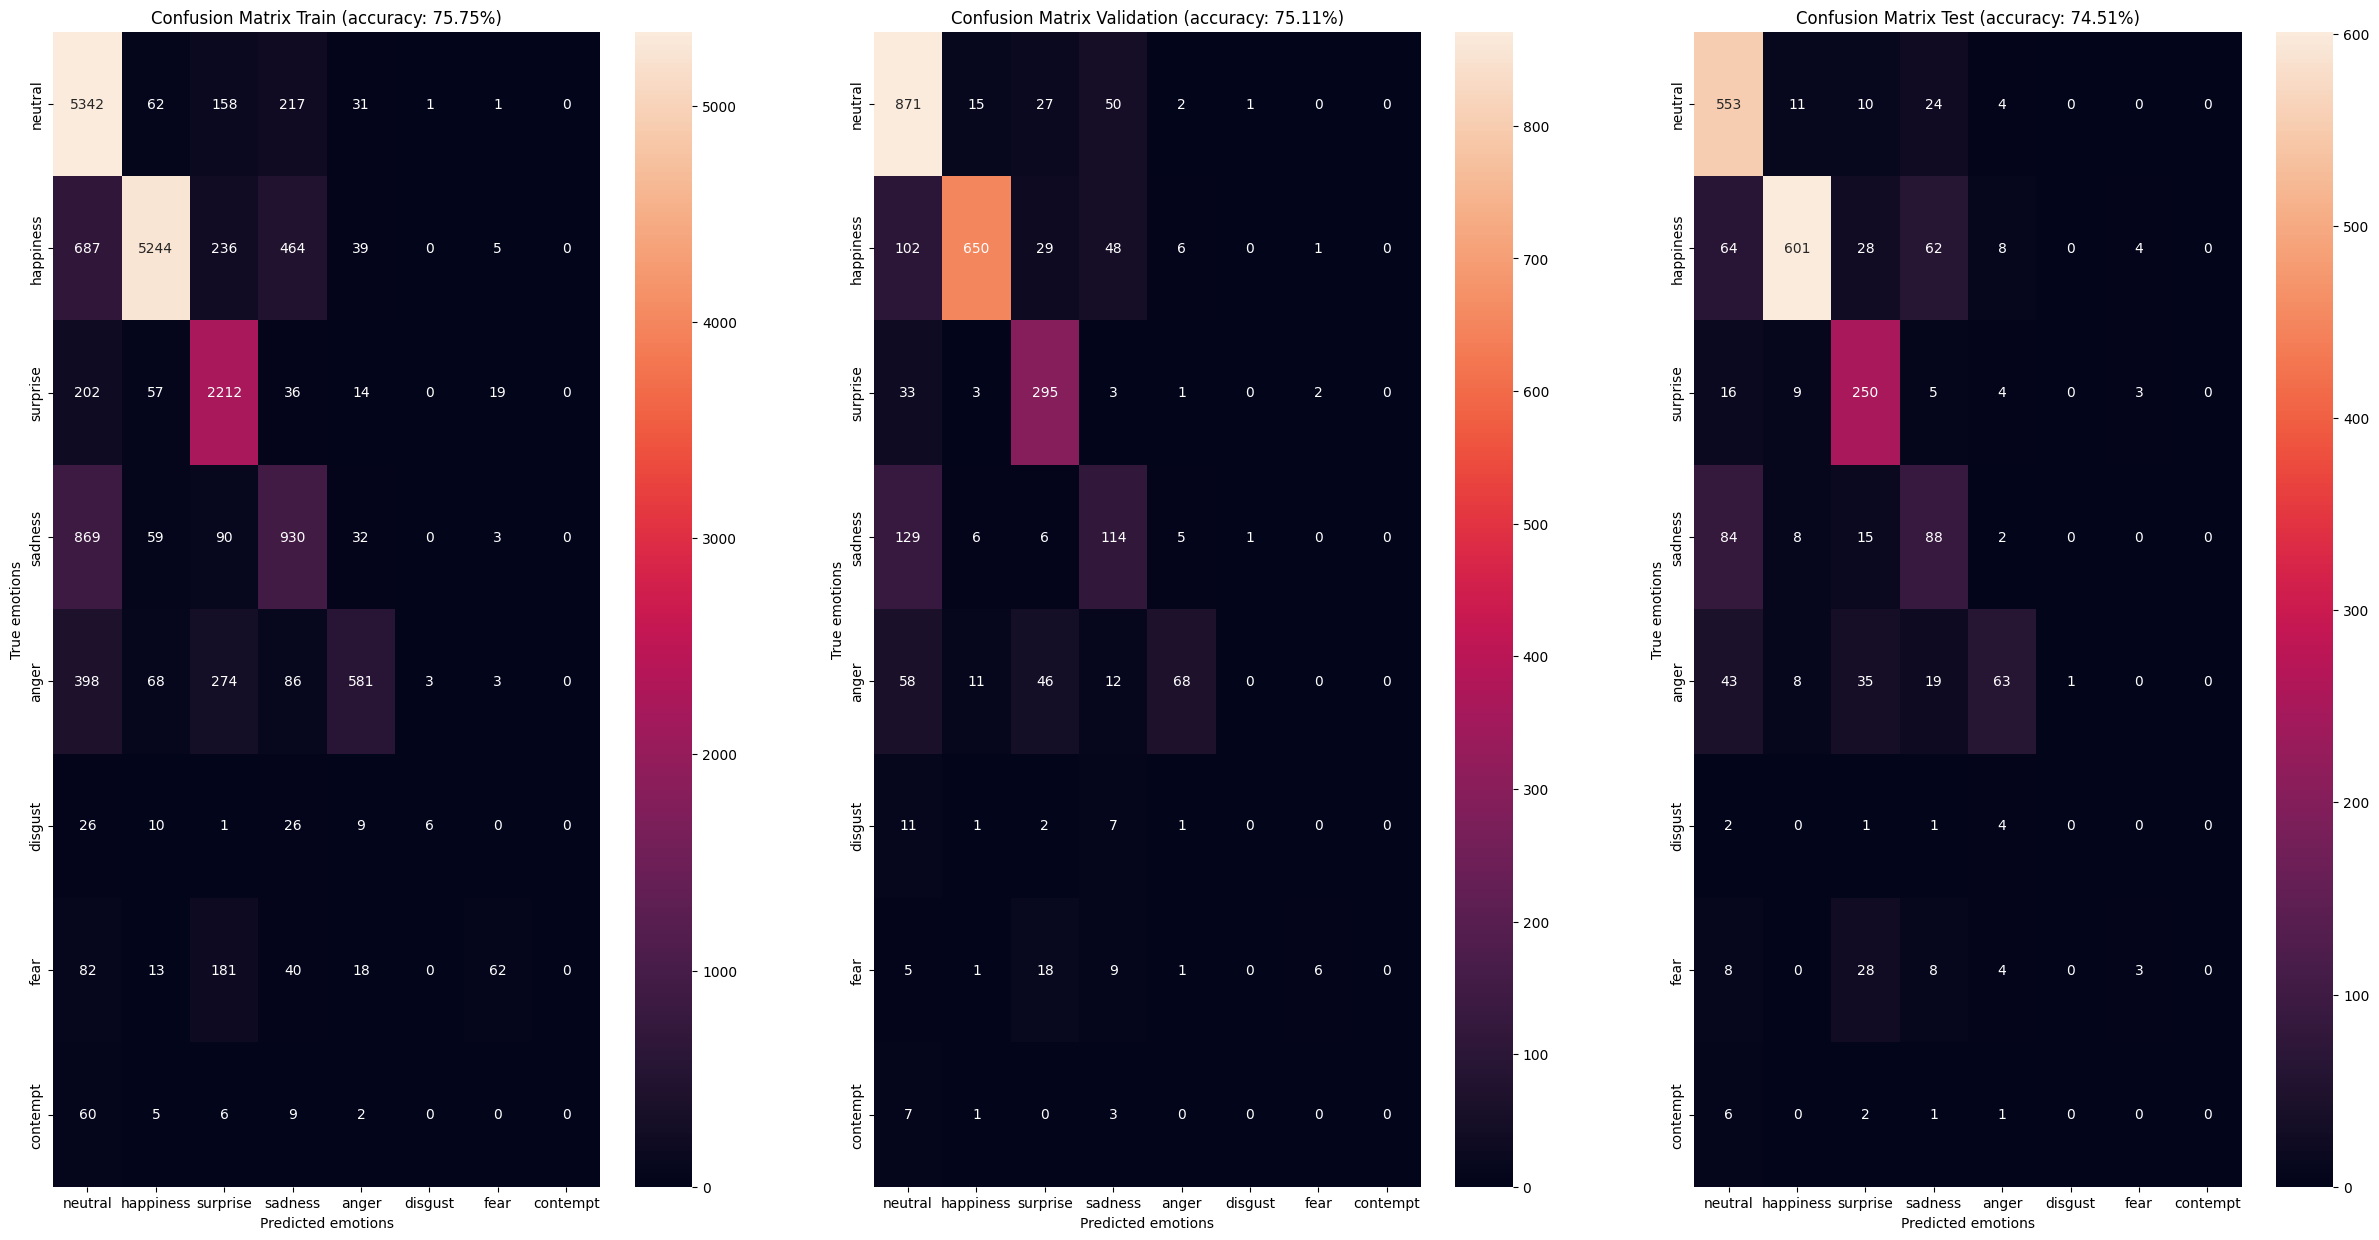

In [64]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

In [22]:
# model = load_model('models/custom+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(horizontal_flip=True,
#                                    shear_range=5,
#                                    brightness_range=(0.1,0.2))
# train_datagen.fit(X_train_plus)

# history = model.fit(train_datagen.flow(X_train_plus, y_train_plus),
#                               epochs=5,
#                               validation_data=ds_val_plus)
# model.save('models/augmented3+.h5')
# with open('models/history_augmented3+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
594/594 [==============================] - 52s 87ms/step - loss: 24.1587 - accuracy: 0.3313 - val_loss: 107.2253 - val_accuracy: 0.3508
Epoch 2/5
594/594 [==============================] - 51s 85ms/step - loss: 18.9255 - accuracy: 0.3412 - val_loss: 186.8891 - val_accuracy: 0.3621
Epoch 3/5
594/594 [==============================] - 51s 85ms/step - loss: 18.4440 - accuracy: 0.3432 - val_loss: 3320.9734 - val_accuracy: 0.0060
Epoch 4/5
594/594 [==============================] - 51s 86ms/step - loss: 17.3369 - accuracy: 0.3435 - val_loss: 5067.7075 - val_accuracy: 0.0086
Epoch 5/5
594/594 [==============================] - 51s 86ms/step - loss: 17.0634 - accuracy: 0.3474 - val_loss: 3053.3274 - val_accuracy: 0.0041


In [23]:
model = load_model('models/augmented3+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented3+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 11s 36ms/step
Calculating validation results:
42/42 [==============================] - 2s 38ms/step
Calculating test results:
33/33 [==============================] - 1s 39ms/step


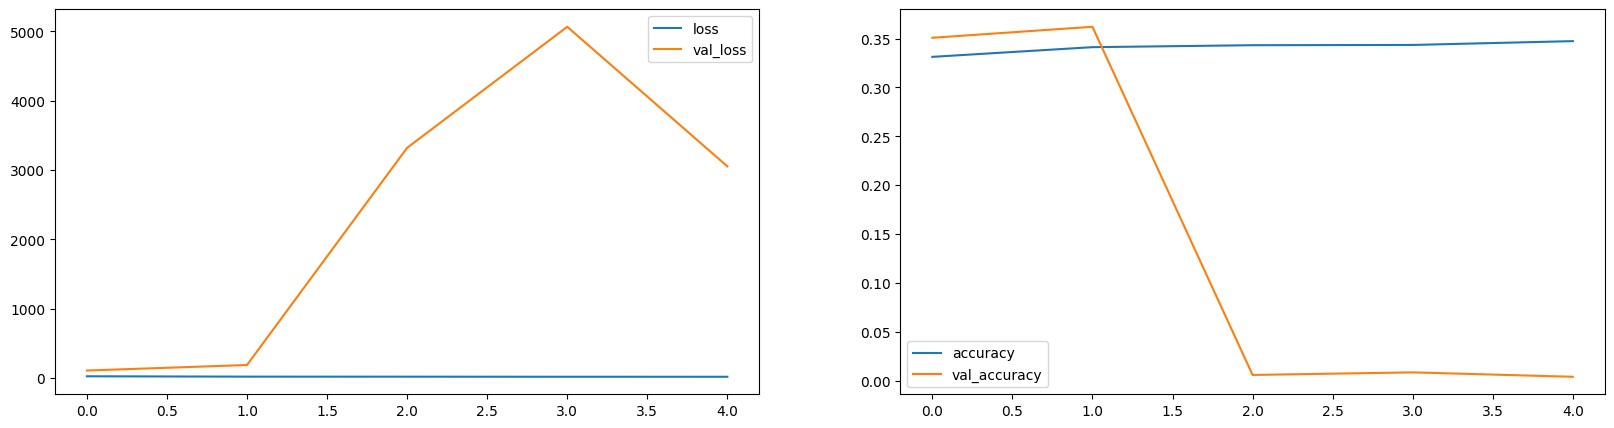

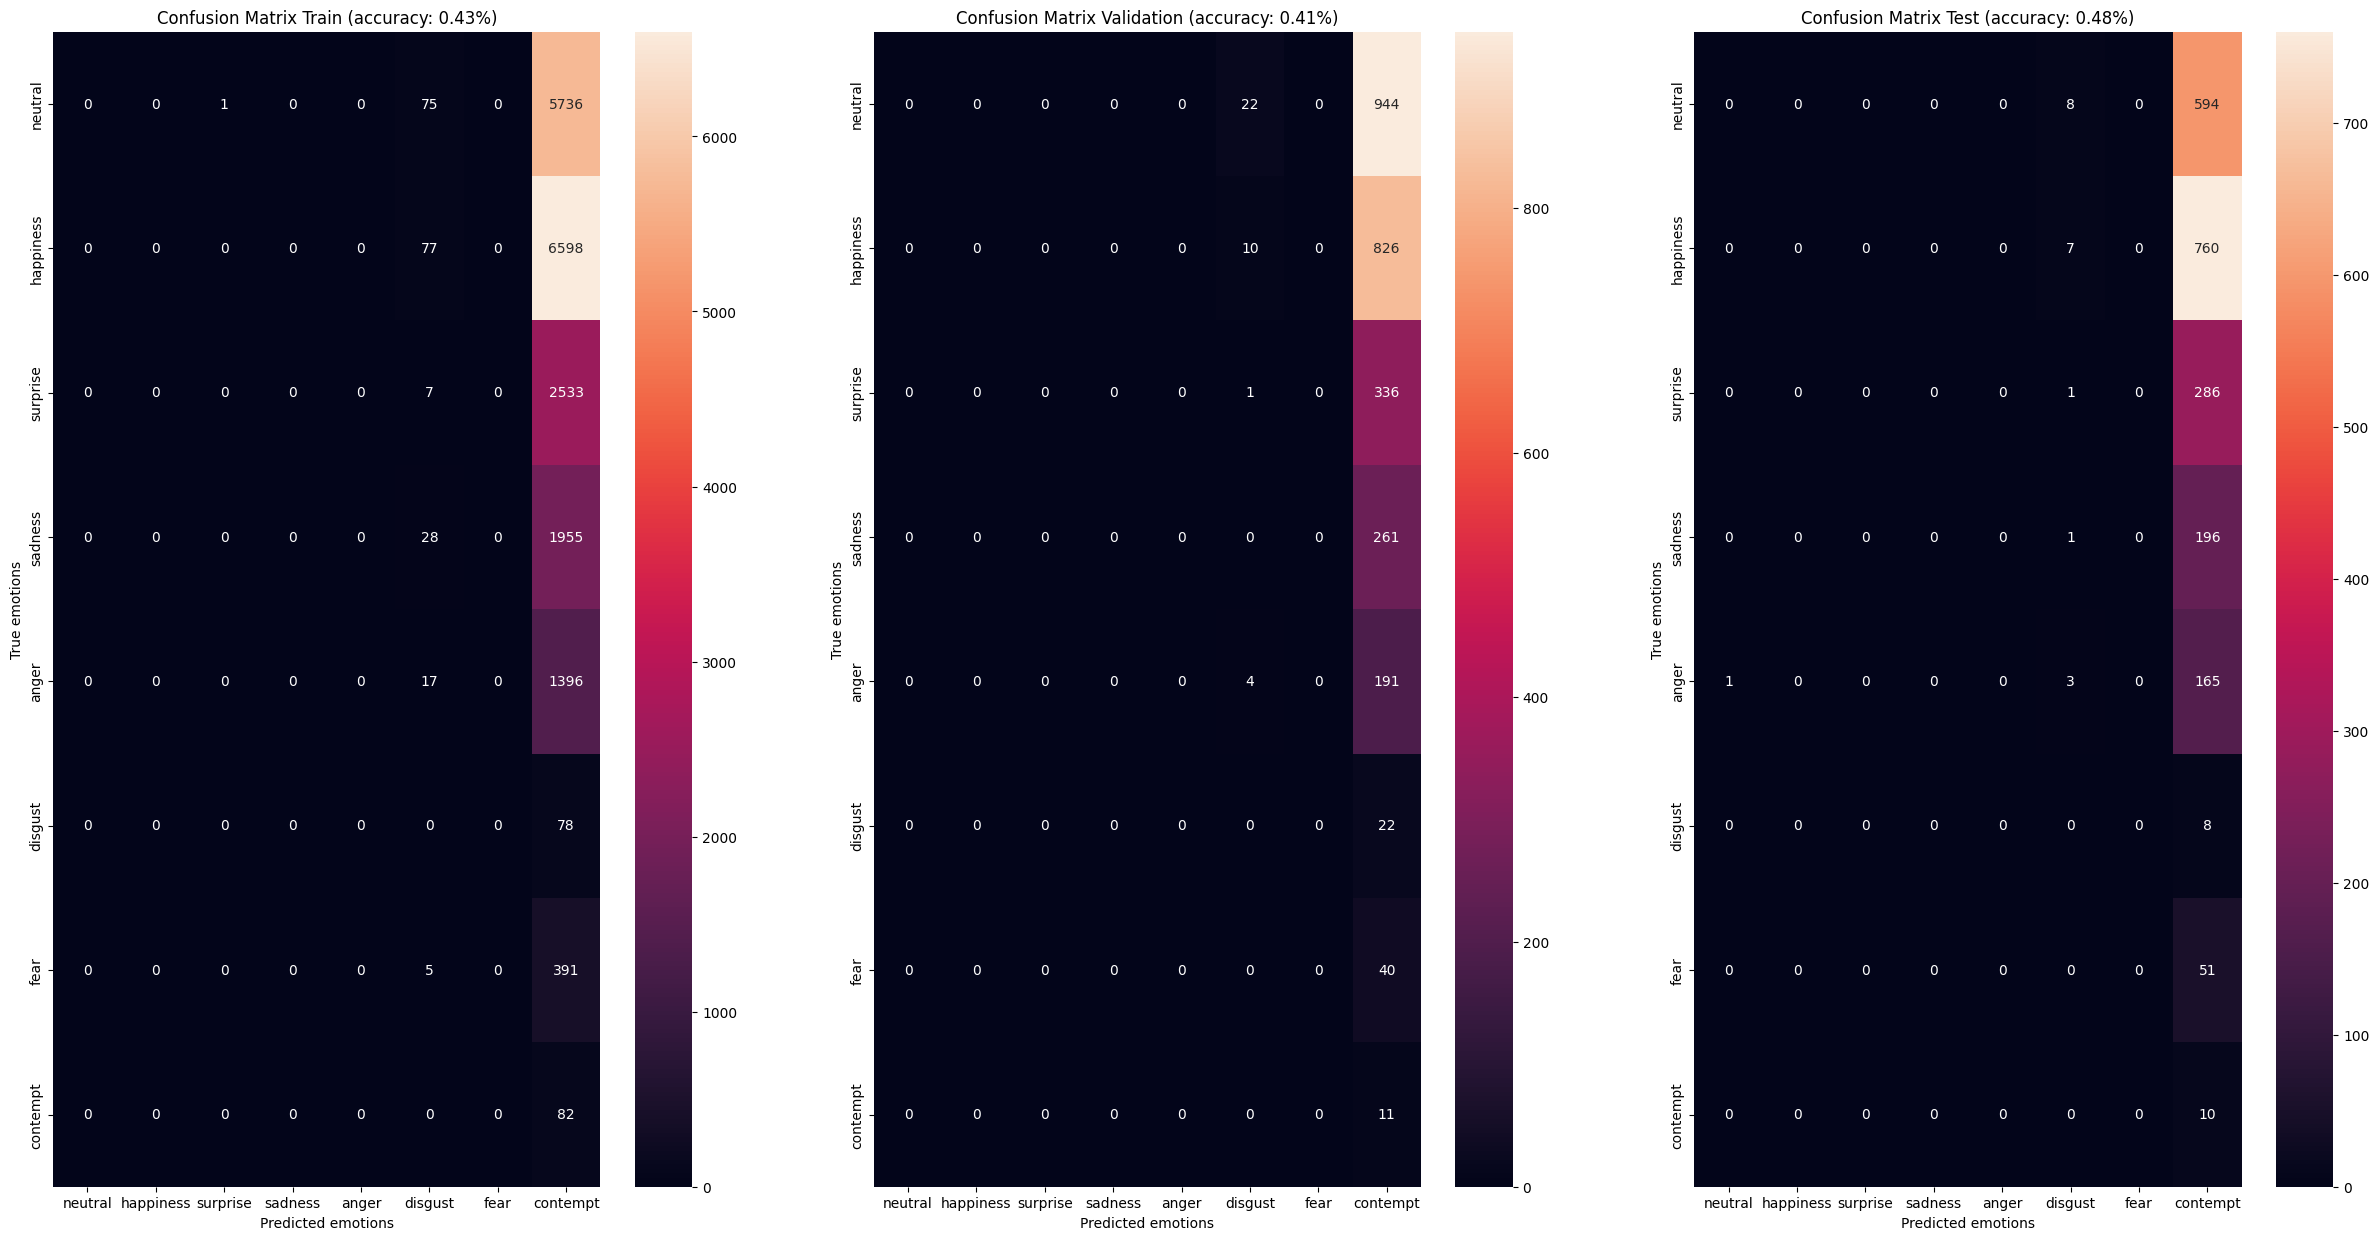

In [24]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

In [25]:
# model = load_model('models/custom+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(horizontal_flip=True,
#                                    shear_range=5,
#                                    vertical_flip=True)
# train_datagen.fit(X_train_plus)

# history = model.fit(train_datagen.flow(X_train_plus, y_train_plus),
#                               epochs=5,
#                               validation_data=ds_val_plus)
# model.save('models/augmented4+.h5')
# with open('models/history_augmented4+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
594/594 [==============================] - 51s 84ms/step - loss: 20.4517 - accuracy: 0.6087 - val_loss: 15.1375 - val_accuracy: 0.6878
Epoch 2/5
594/594 [==============================] - 49s 83ms/step - loss: 14.9645 - accuracy: 0.6981 - val_loss: 13.6017 - val_accuracy: 0.7601
Epoch 3/5
594/594 [==============================] - 50s 84ms/step - loss: 14.0060 - accuracy: 0.7141 - val_loss: 12.5747 - val_accuracy: 0.7627
Epoch 4/5
594/594 [==============================] - 50s 85ms/step - loss: 13.7226 - accuracy: 0.7285 - val_loss: 12.5625 - val_accuracy: 0.7537
Epoch 5/5
594/594 [==============================] - 51s 86ms/step - loss: 13.4998 - accuracy: 0.7381 - val_loss: 12.5149 - val_accuracy: 0.7601


In [26]:
model = load_model('models/augmented4+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented4+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 11s 36ms/step
Calculating validation results:
42/42 [==============================] - 2s 38ms/step
Calculating test results:
33/33 [==============================] - 1s 39ms/step


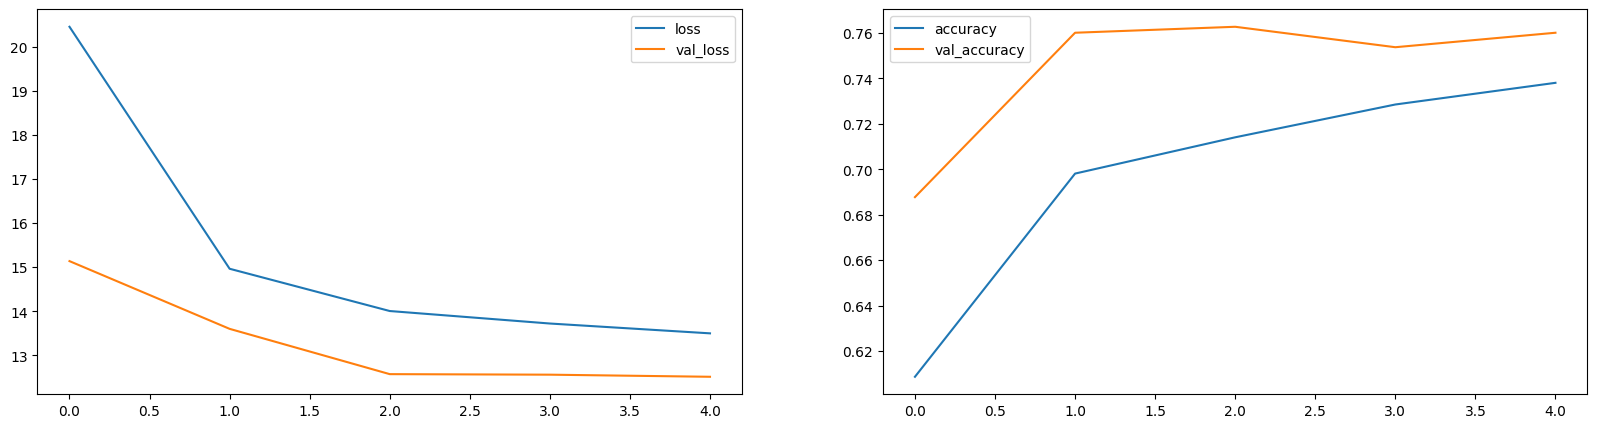

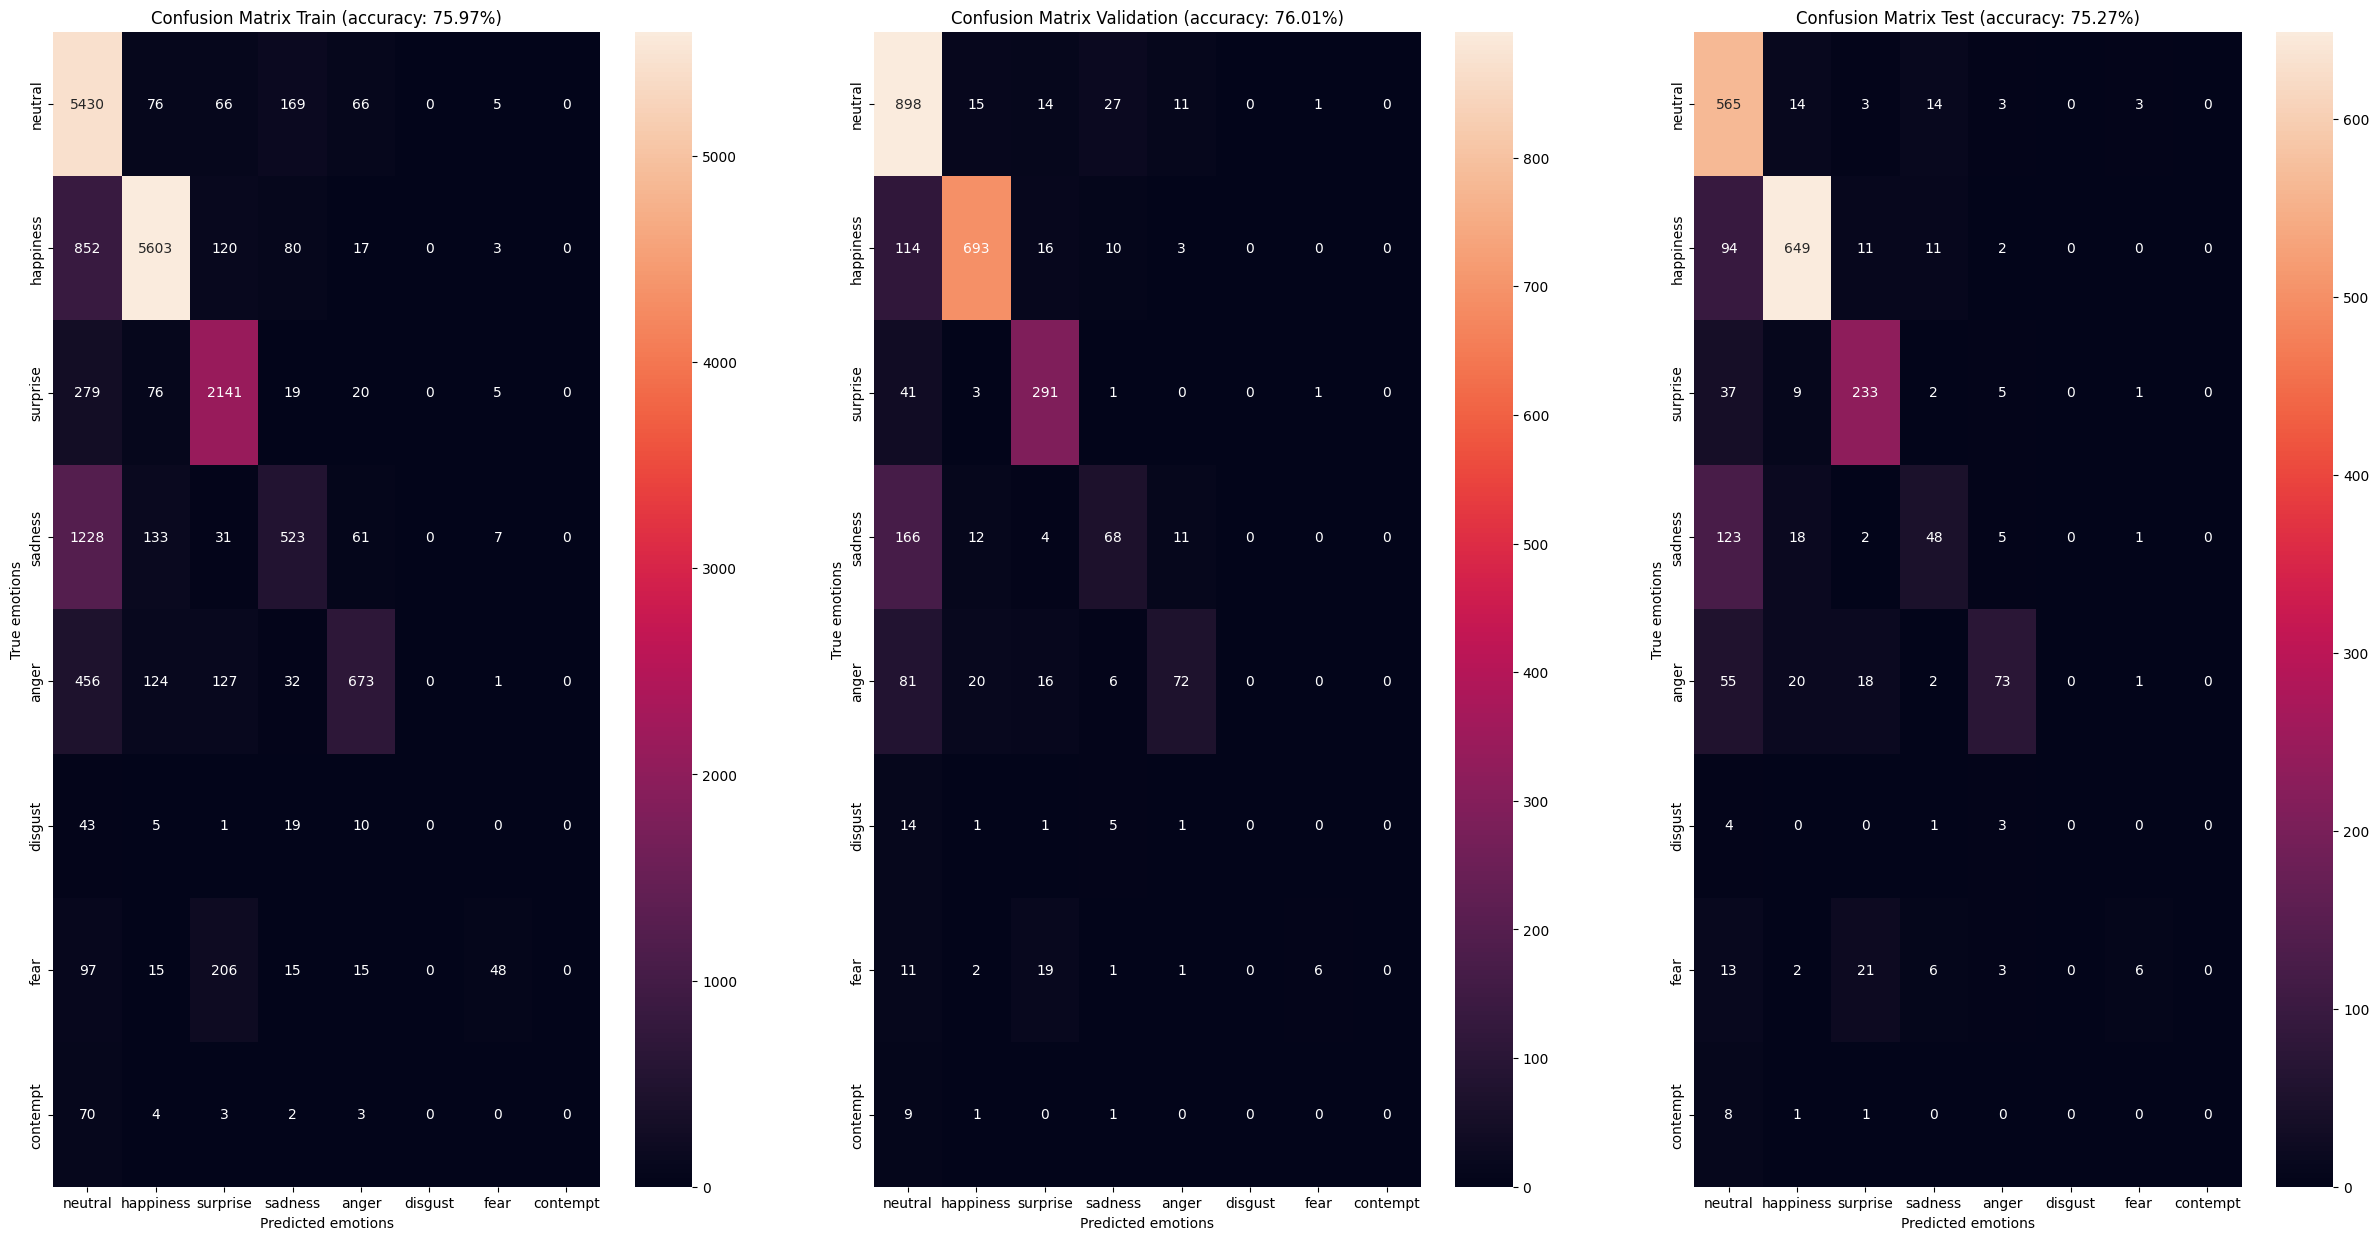

In [27]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

In [28]:
# model = load_model('models/augmented+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# train_datagen = ImageDataGenerator(horizontal_flip=True,
#                                    shear_range=5)
# train_datagen.fit(X_train_plus)

# history = model.fit(train_datagen.flow(X_train_plus, y_train_plus),
#                               epochs=3,
#                               validation_data=ds_val_plus)
# model.save('models/augmented5+.h5')
# with open('models/history_augmented5+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/3
594/594 [==============================] - 52s 85ms/step - loss: 11.3399 - accuracy: 0.7930 - val_loss: 10.9507 - val_accuracy: 0.8017
Epoch 2/3
594/594 [==============================] - 50s 84ms/step - loss: 11.5957 - accuracy: 0.7938 - val_loss: 11.6417 - val_accuracy: 0.7875
Epoch 3/3
594/594 [==============================] - 50s 85ms/step - loss: 11.3500 - accuracy: 0.7980 - val_loss: 11.0179 - val_accuracy: 0.7954


In [29]:
model = load_model('models/augmented5+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented5+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 11s 37ms/step
Calculating validation results:
42/42 [==============================] - 2s 38ms/step
Calculating test results:
33/33 [==============================] - 1s 39ms/step


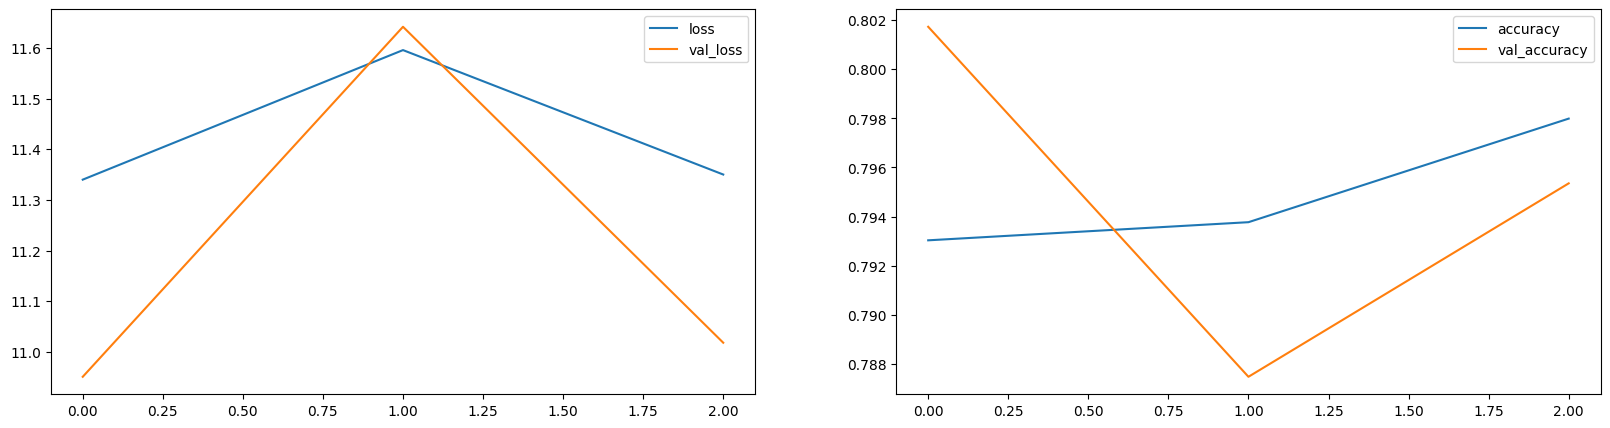

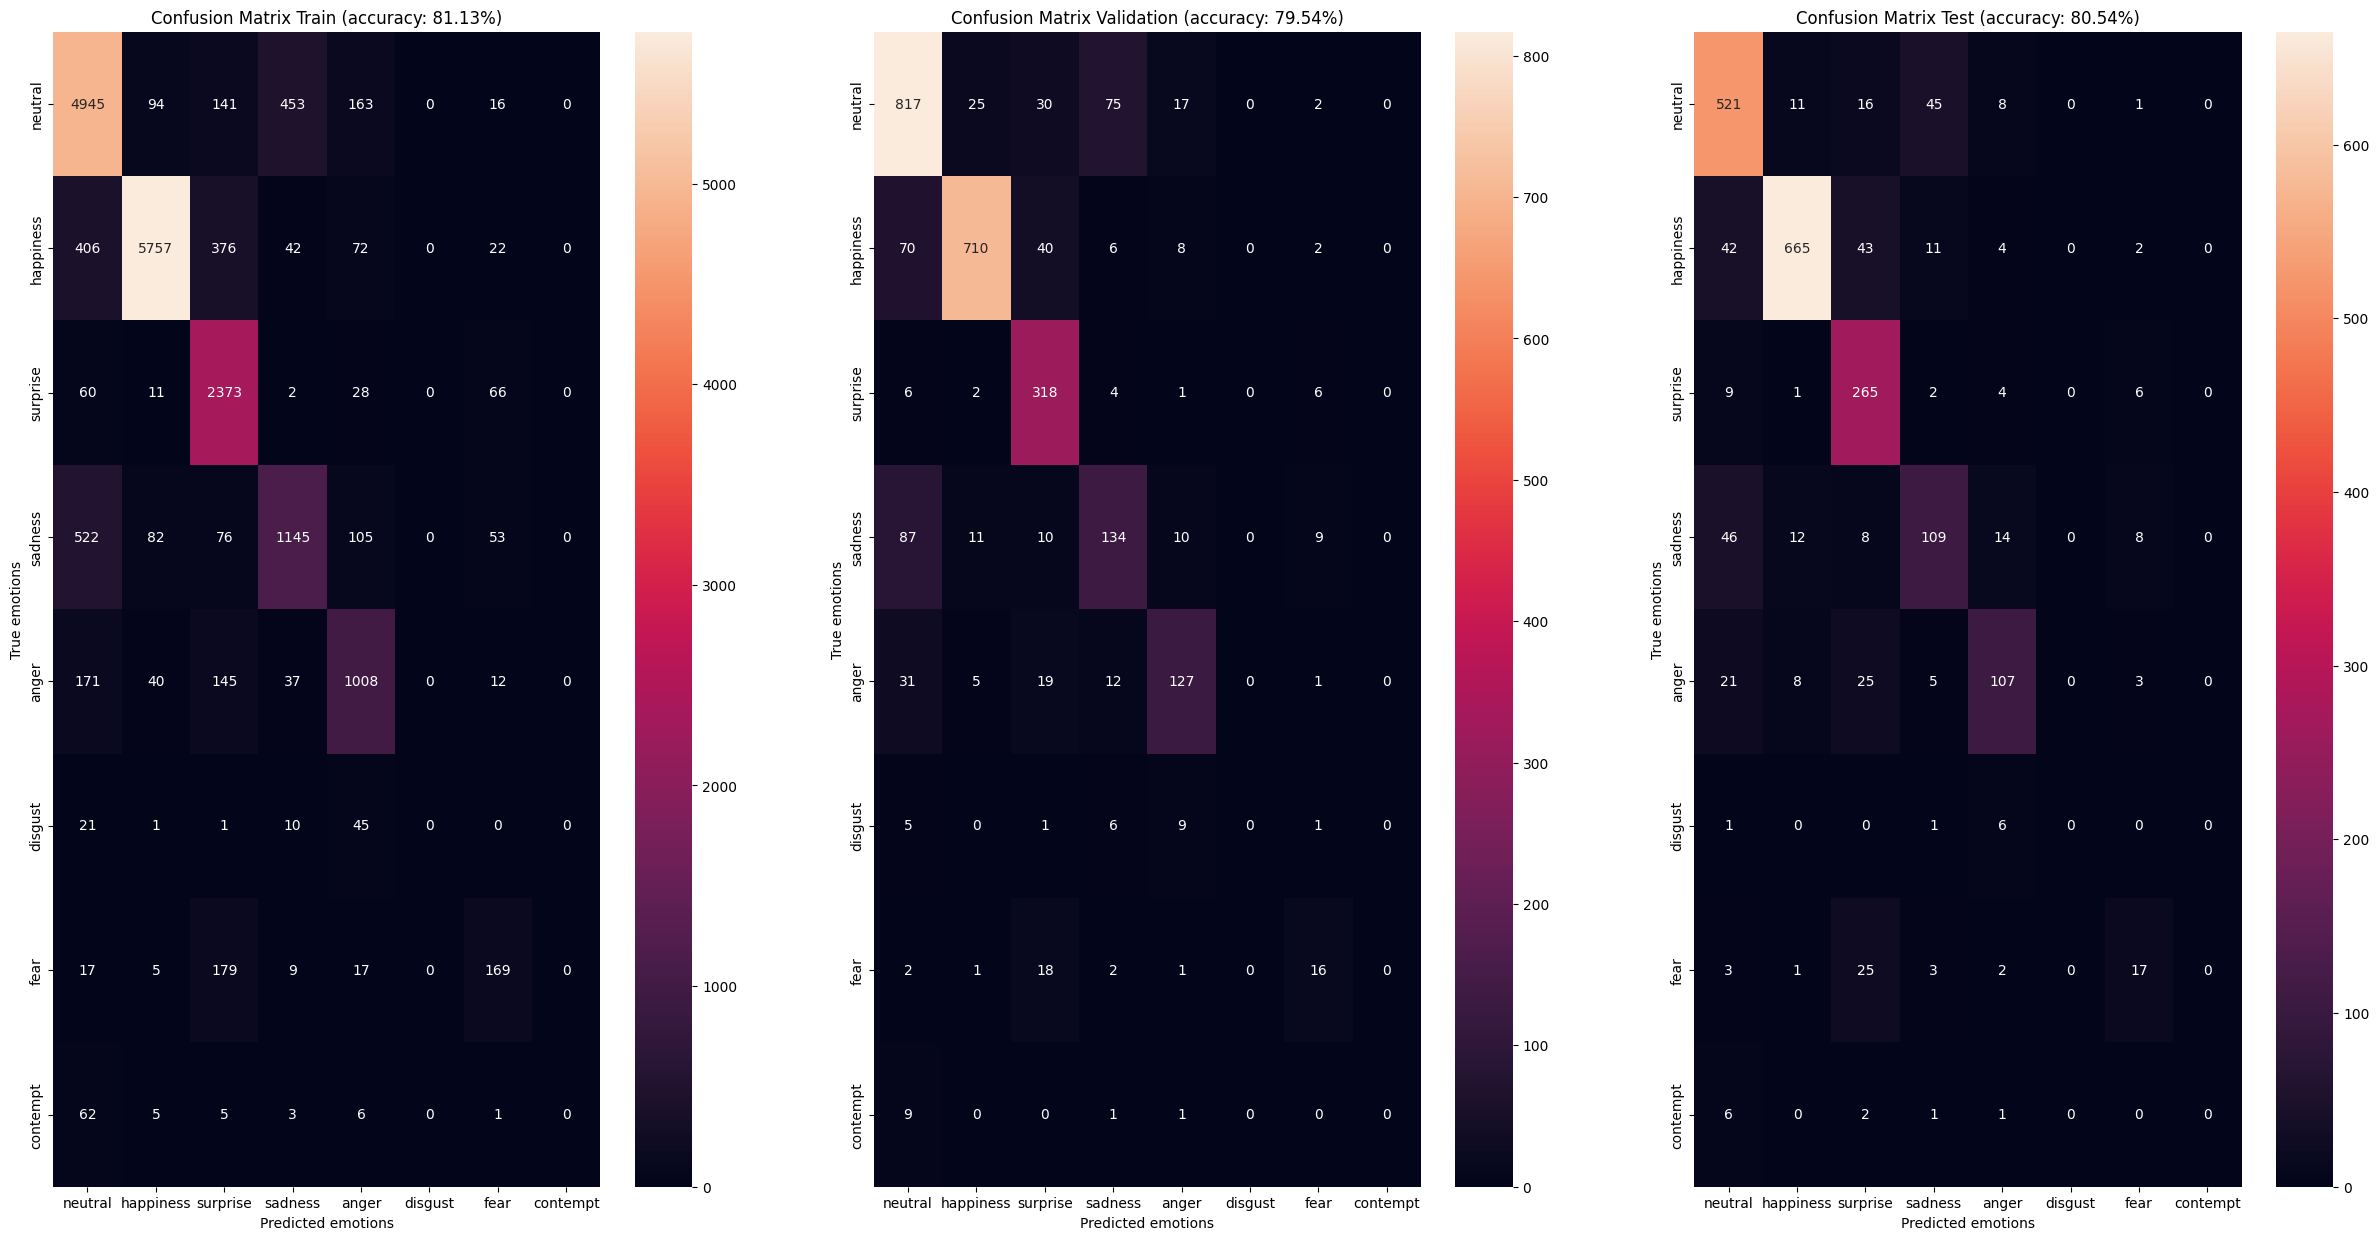

In [30]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

## Label smoothing

---

In [31]:
model = load_model('models/augmented5+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy'],
)

In [32]:
# history = model.fit(
#     ds_train_plus,
#     validation_data=ds_val_plus,
#     epochs=5,
# )
# model.save('models/label_smoothed+.h5')
# with open('models/history_label_smoothed+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
297/297 [==============================] - 41s 134ms/step - loss: 9.5366 - accuracy: 0.8320 - val_loss: 9.7785 - val_accuracy: 0.7995
Epoch 2/5
297/297 [==============================] - 39s 132ms/step - loss: 8.2131 - accuracy: 0.8877 - val_loss: 9.5270 - val_accuracy: 0.7935
Epoch 3/5
297/297 [==============================] - 39s 133ms/step - loss: 7.8350 - accuracy: 0.9021 - val_loss: 9.4079 - val_accuracy: 0.8133
Epoch 4/5
297/297 [==============================] - 40s 136ms/step - loss: 8.2765 - accuracy: 0.8993 - val_loss: 10.1940 - val_accuracy: 0.7980
Epoch 5/5
297/297 [==============================] - 41s 138ms/step - loss: 7.5973 - accuracy: 0.9180 - val_loss: 8.9916 - val_accuracy: 0.8043


In [33]:
model = load_model('models/label_smoothed+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_label_smoothed+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 11s 35ms/step
Calculating validation results:
42/42 [==============================] - 1s 36ms/step
Calculating test results:
33/33 [==============================] - 1s 36ms/step


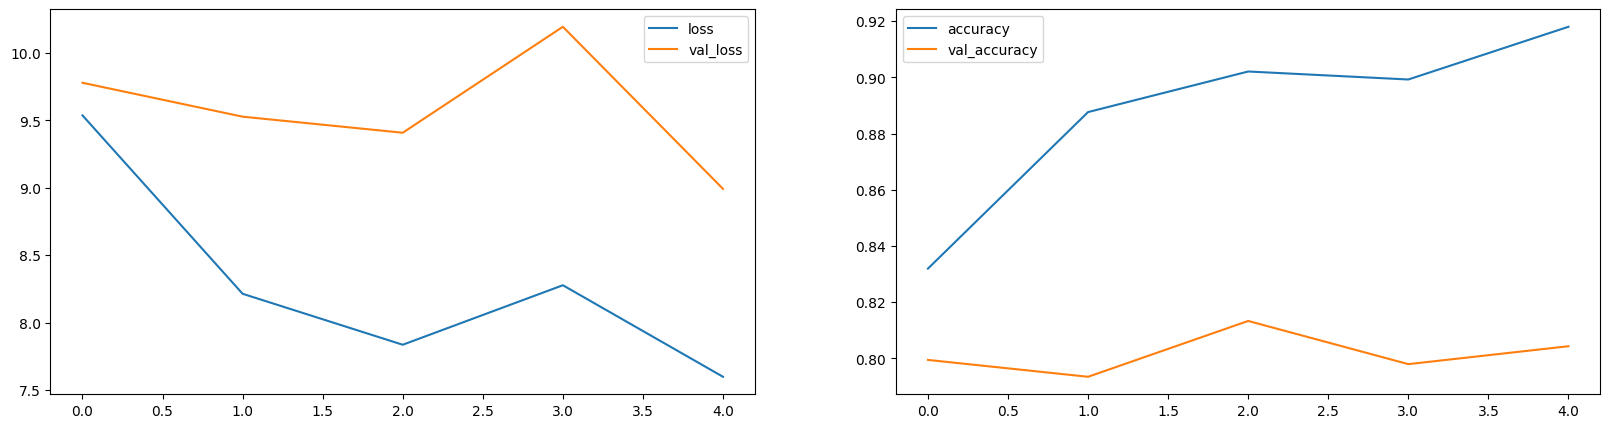

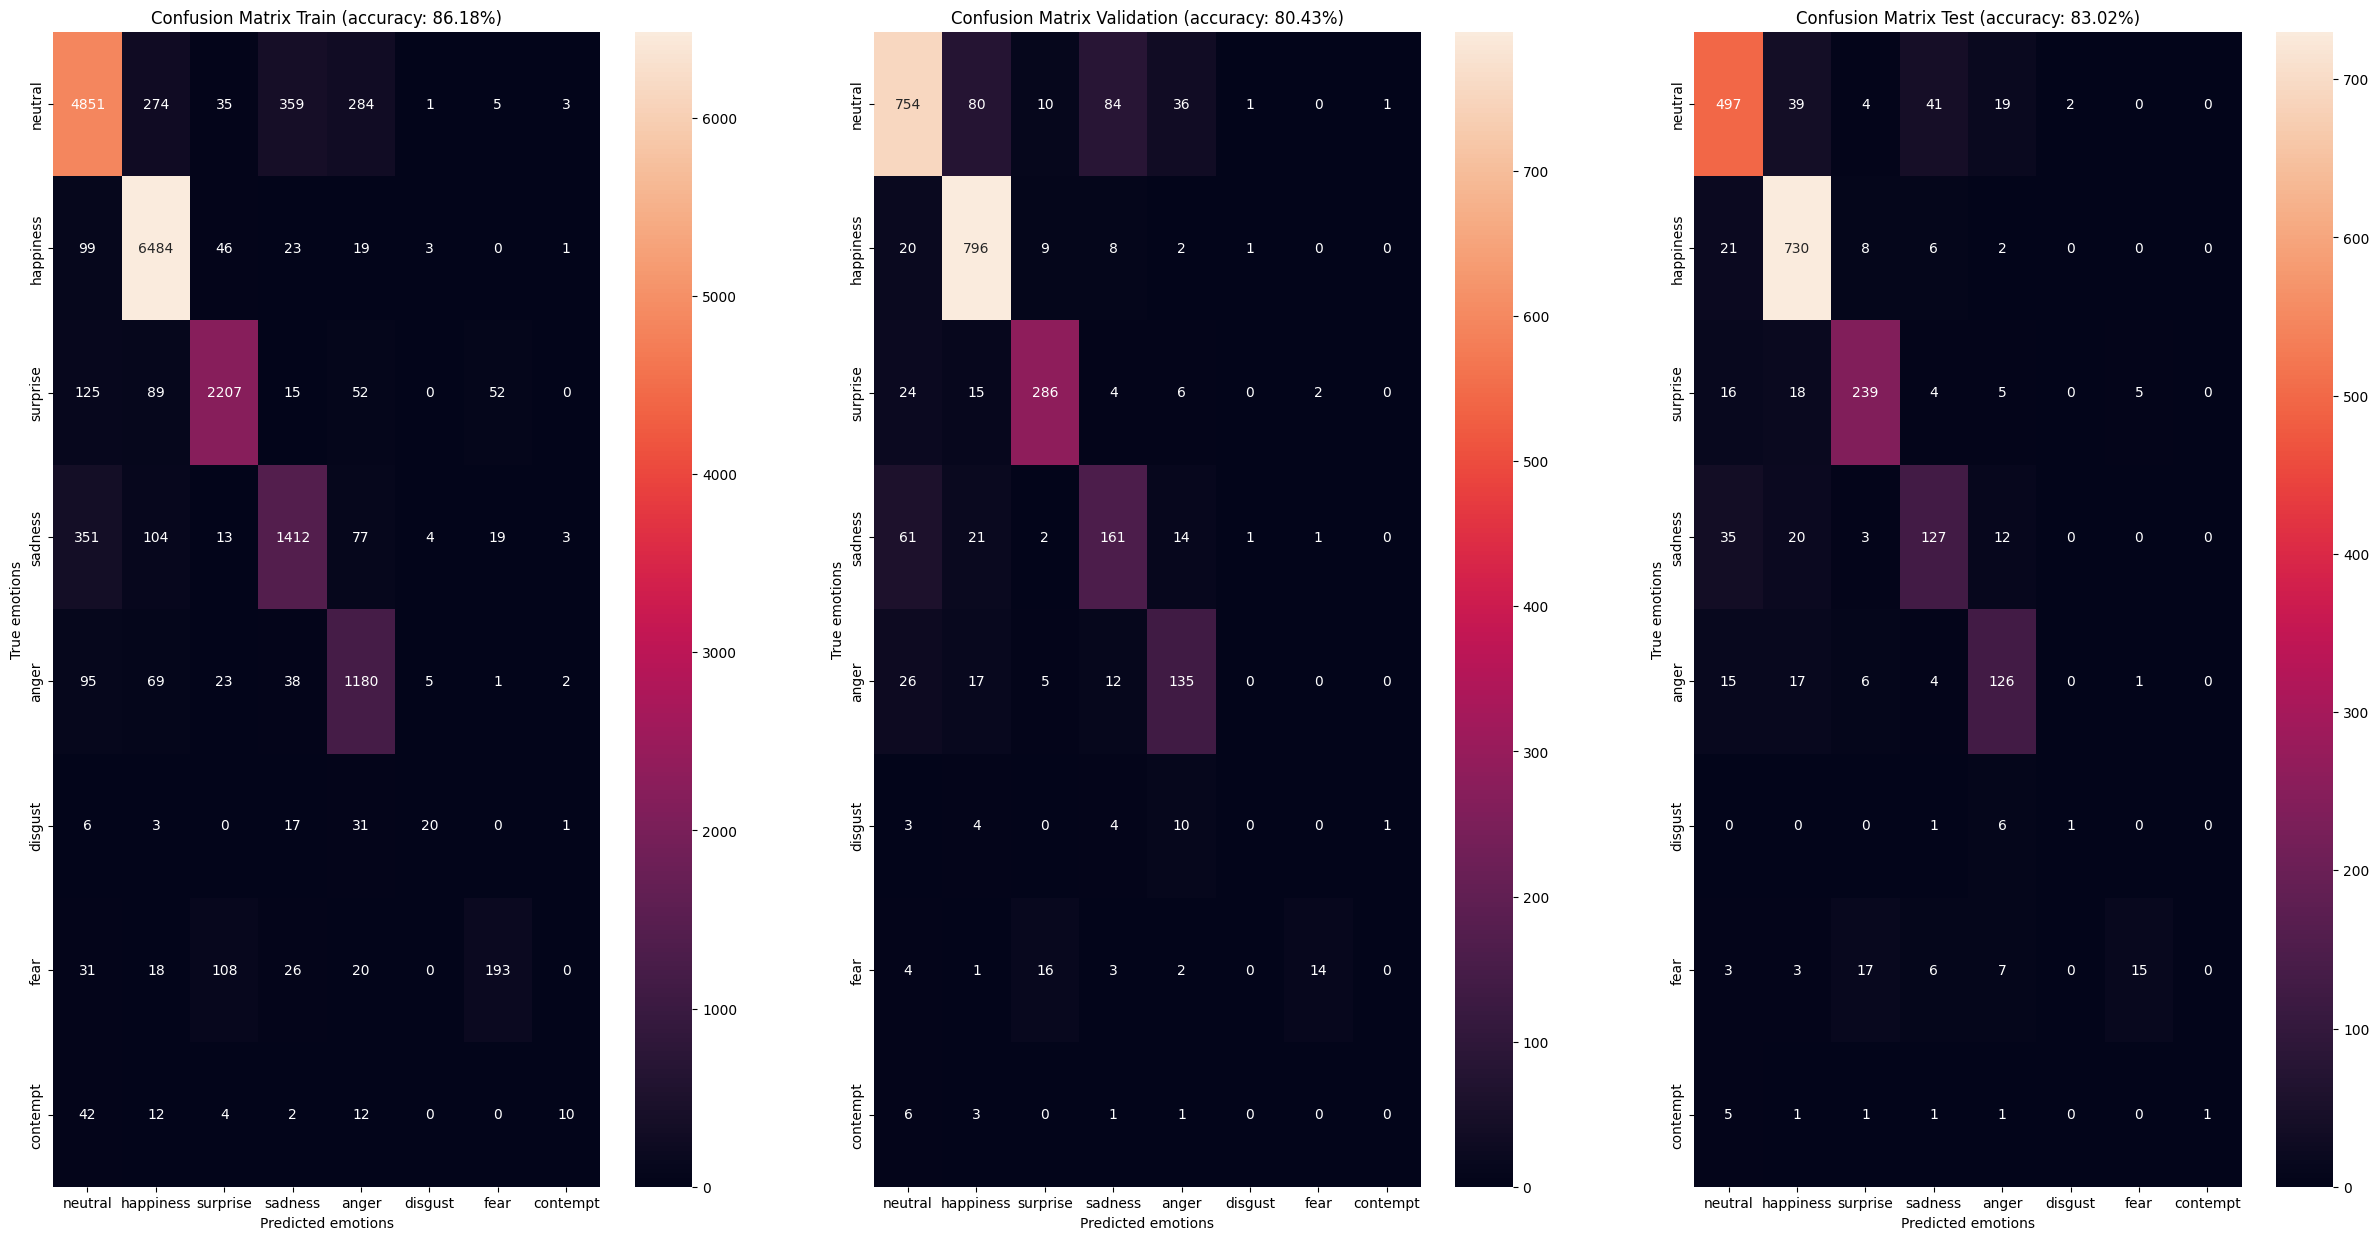

In [34]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

In [17]:
model = load_model('models/augmented5+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss=CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy'],
)

In [18]:
# history = model.fit(
#     ds_train_plus,
#     validation_data=ds_val_plus,
#     epochs=5,
# )
# model.save('models/label_smoothed2+.h5')
# with open('models/history_label_smoothed2+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
297/297 [==============================] - 41s 133ms/step - loss: 9.0453 - accuracy: 0.8313 - val_loss: 9.6688 - val_accuracy: 0.7987
Epoch 2/5
297/297 [==============================] - 39s 132ms/step - loss: 7.7693 - accuracy: 0.8857 - val_loss: 8.6967 - val_accuracy: 0.7991
Epoch 3/5
297/297 [==============================] - 39s 132ms/step - loss: 7.4090 - accuracy: 0.9013 - val_loss: 8.8834 - val_accuracy: 0.8040
Epoch 4/5
297/297 [==============================] - 40s 135ms/step - loss: 7.6265 - accuracy: 0.9013 - val_loss: 8.8335 - val_accuracy: 0.8122
Epoch 5/5
297/297 [==============================] - 41s 137ms/step - loss: 7.1951 - accuracy: 0.9154 - val_loss: 8.4948 - val_accuracy: 0.8058


In [19]:
model = load_model('models/label_smoothed2+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_label_smoothed2+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 11s 37ms/step
Calculating validation results:
42/42 [==============================] - 2s 37ms/step
Calculating test results:
33/33 [==============================] - 1s 38ms/step


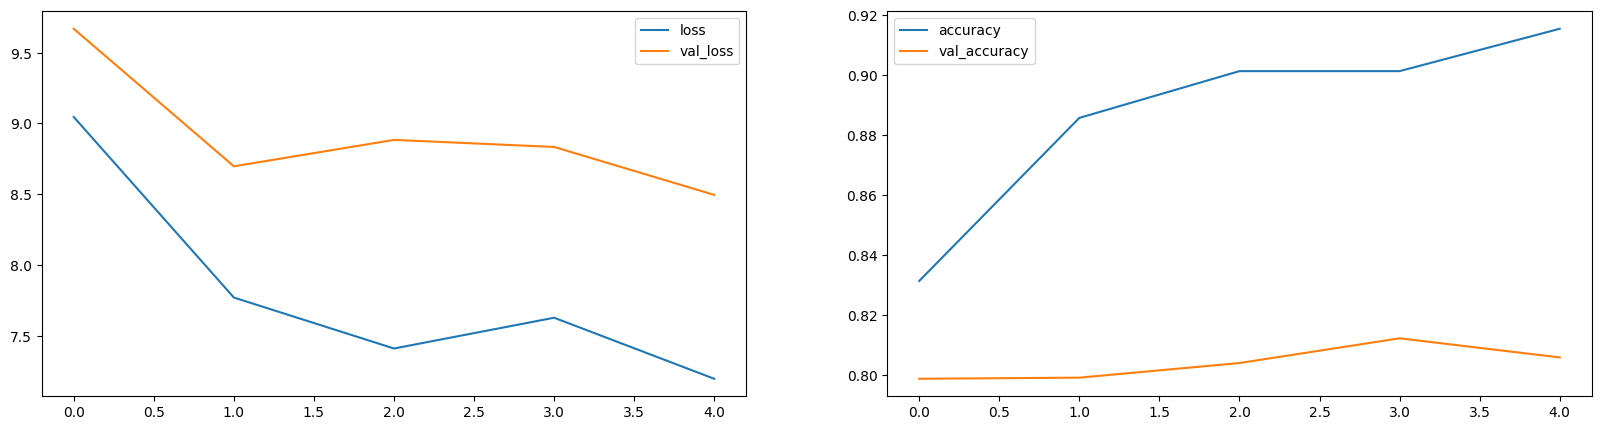

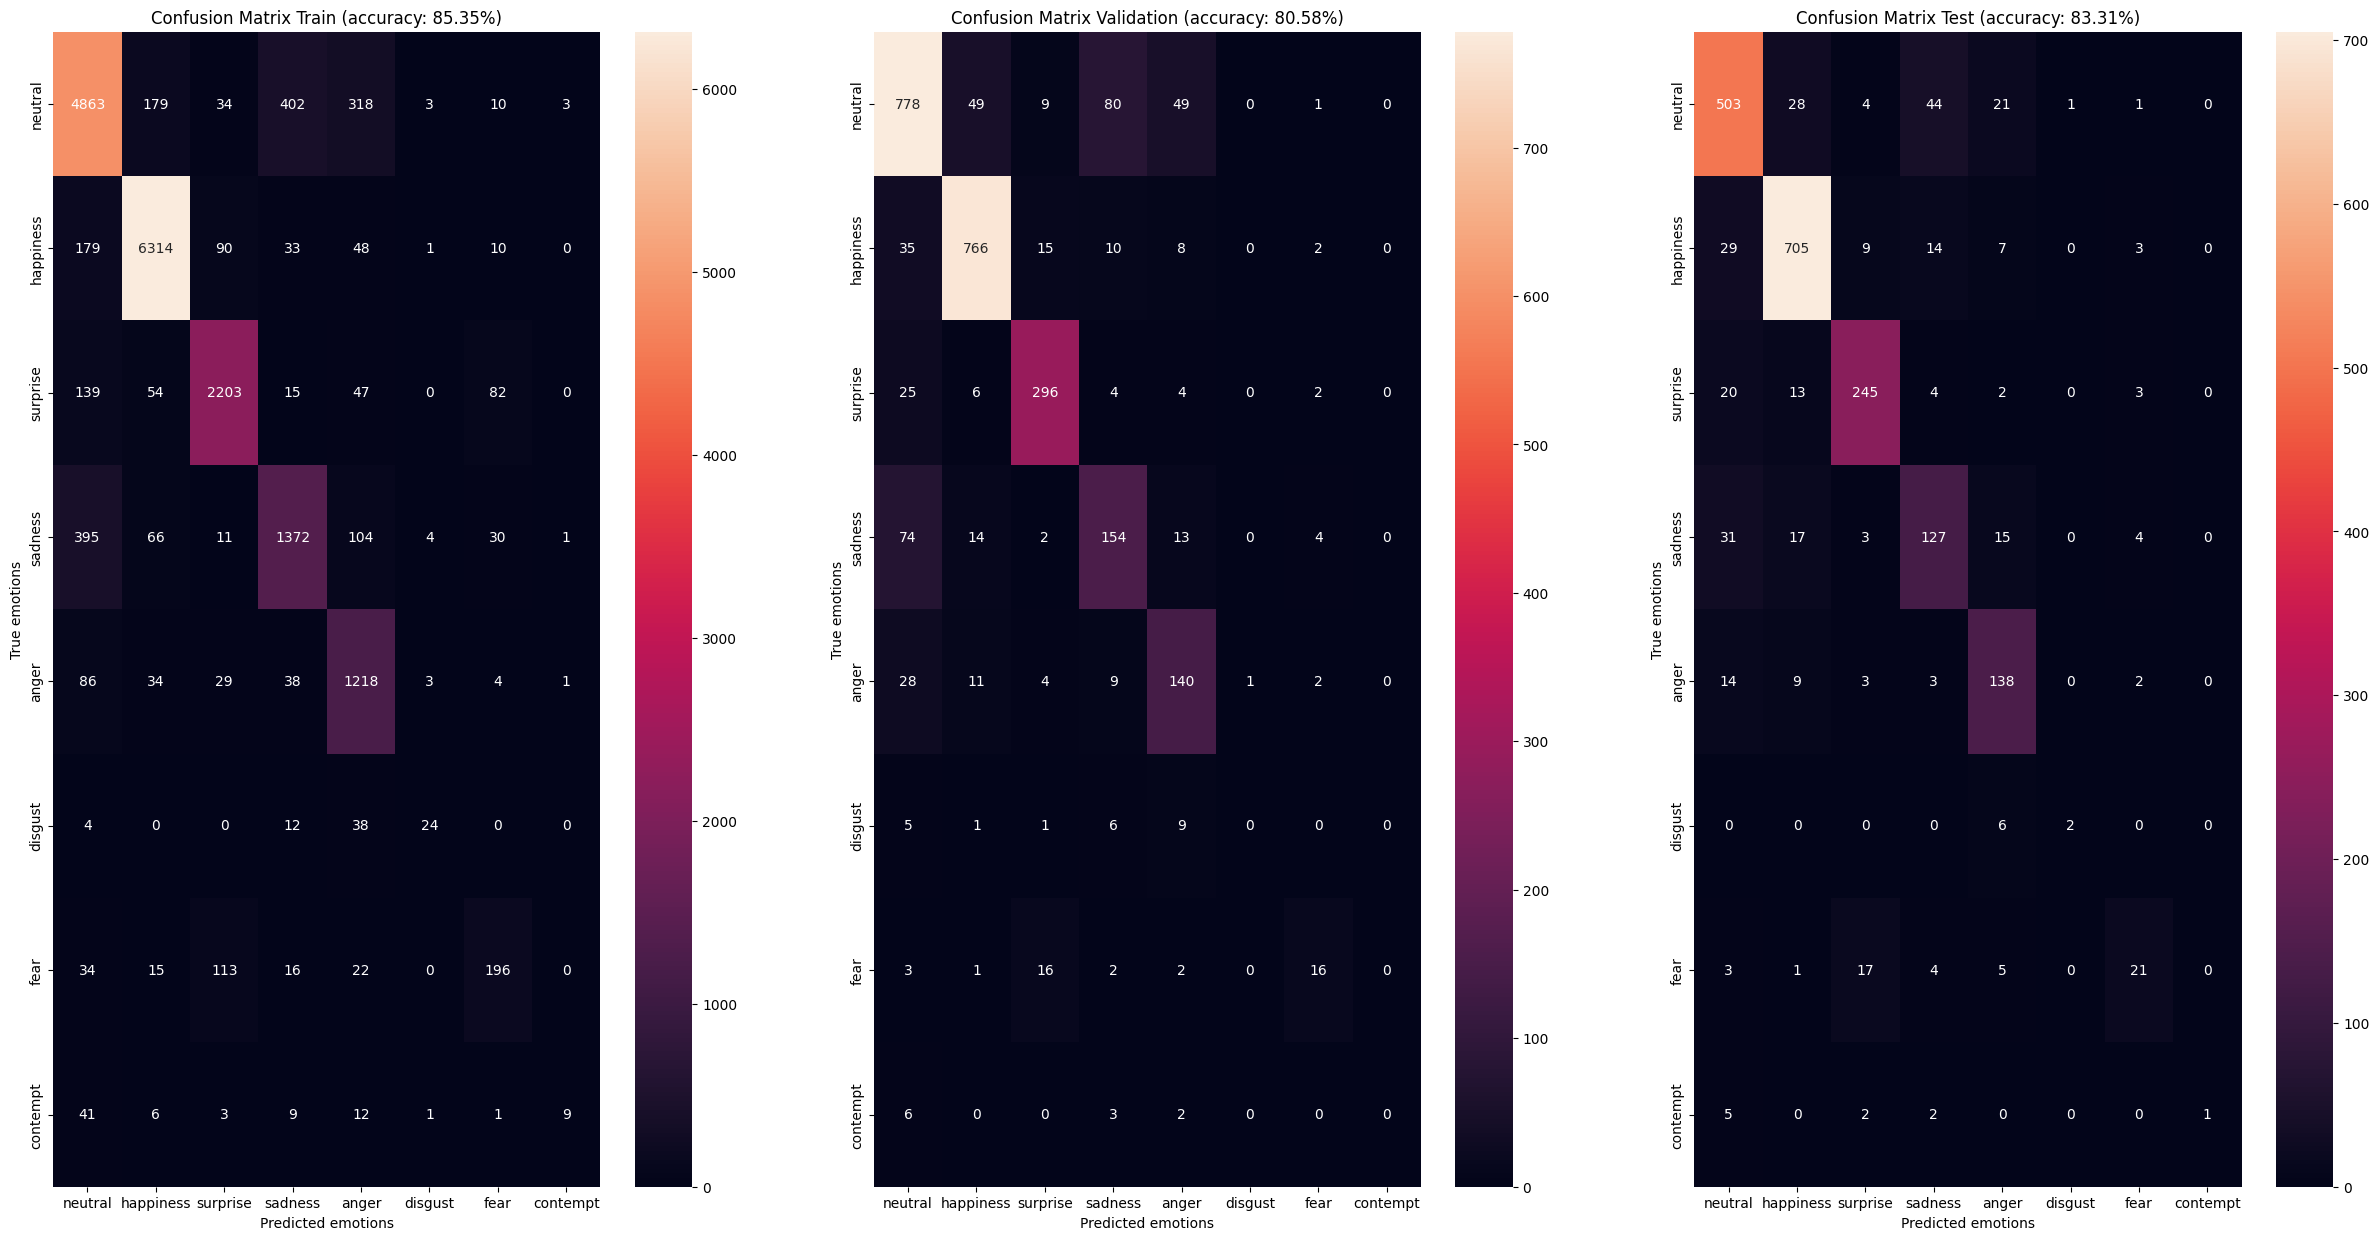

In [20]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

In [21]:
model = load_model('models/augmented5+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss=CategoricalCrossentropy(label_smoothing=0.3),
    metrics=['accuracy'],
)

In [22]:
# history = model.fit(
#     ds_train_plus,
#     validation_data=ds_val_plus,
#     epochs=5,
# )
# model.save('models/label_smoothed3+.h5')
# with open('models/history_label_smoothed3+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
297/297 [==============================] - 41s 133ms/step - loss: 8.4434 - accuracy: 0.8316 - val_loss: 8.5048 - val_accuracy: 0.8115
Epoch 2/5
297/297 [==============================] - 40s 133ms/step - loss: 7.3979 - accuracy: 0.8830 - val_loss: 8.8265 - val_accuracy: 0.7927
Epoch 3/5
297/297 [==============================] - 40s 136ms/step - loss: 7.1713 - accuracy: 0.8958 - val_loss: 8.2876 - val_accuracy: 0.7946
Epoch 4/5
297/297 [==============================] - 41s 138ms/step - loss: 7.0196 - accuracy: 0.9031 - val_loss: 8.0906 - val_accuracy: 0.8077
Epoch 5/5
297/297 [==============================] - 41s 139ms/step - loss: 6.7613 - accuracy: 0.9125 - val_loss: 7.8260 - val_accuracy: 0.8073


In [23]:
model = load_model('models/label_smoothed3+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_label_smoothed3+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 12s 36ms/step
Calculating validation results:
42/42 [==============================] - 2s 37ms/step
Calculating test results:
33/33 [==============================] - 1s 40ms/step


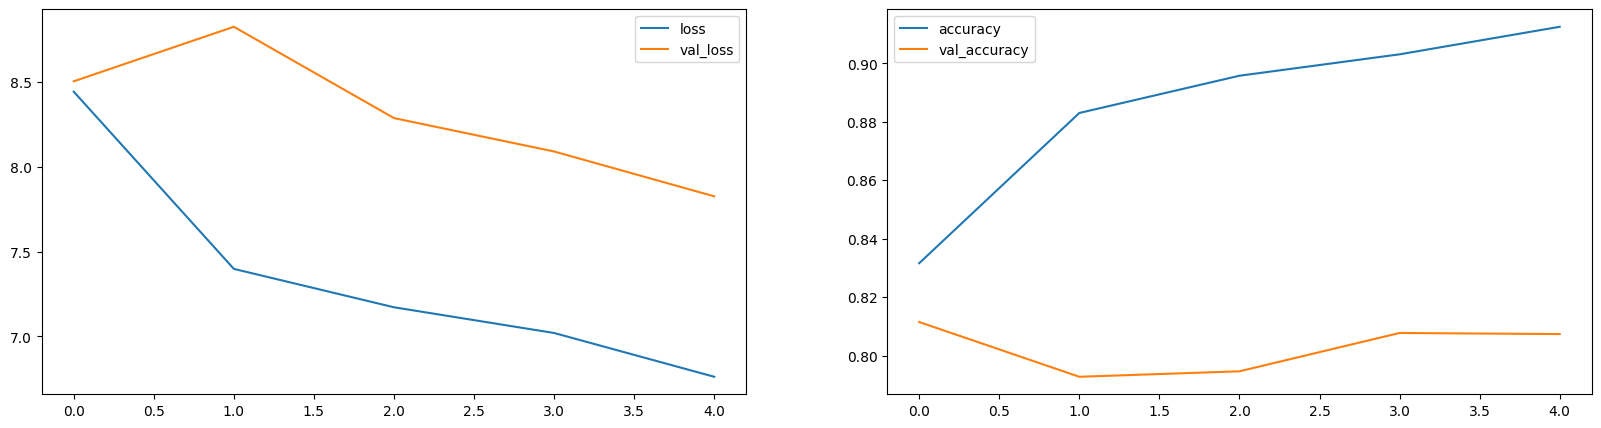

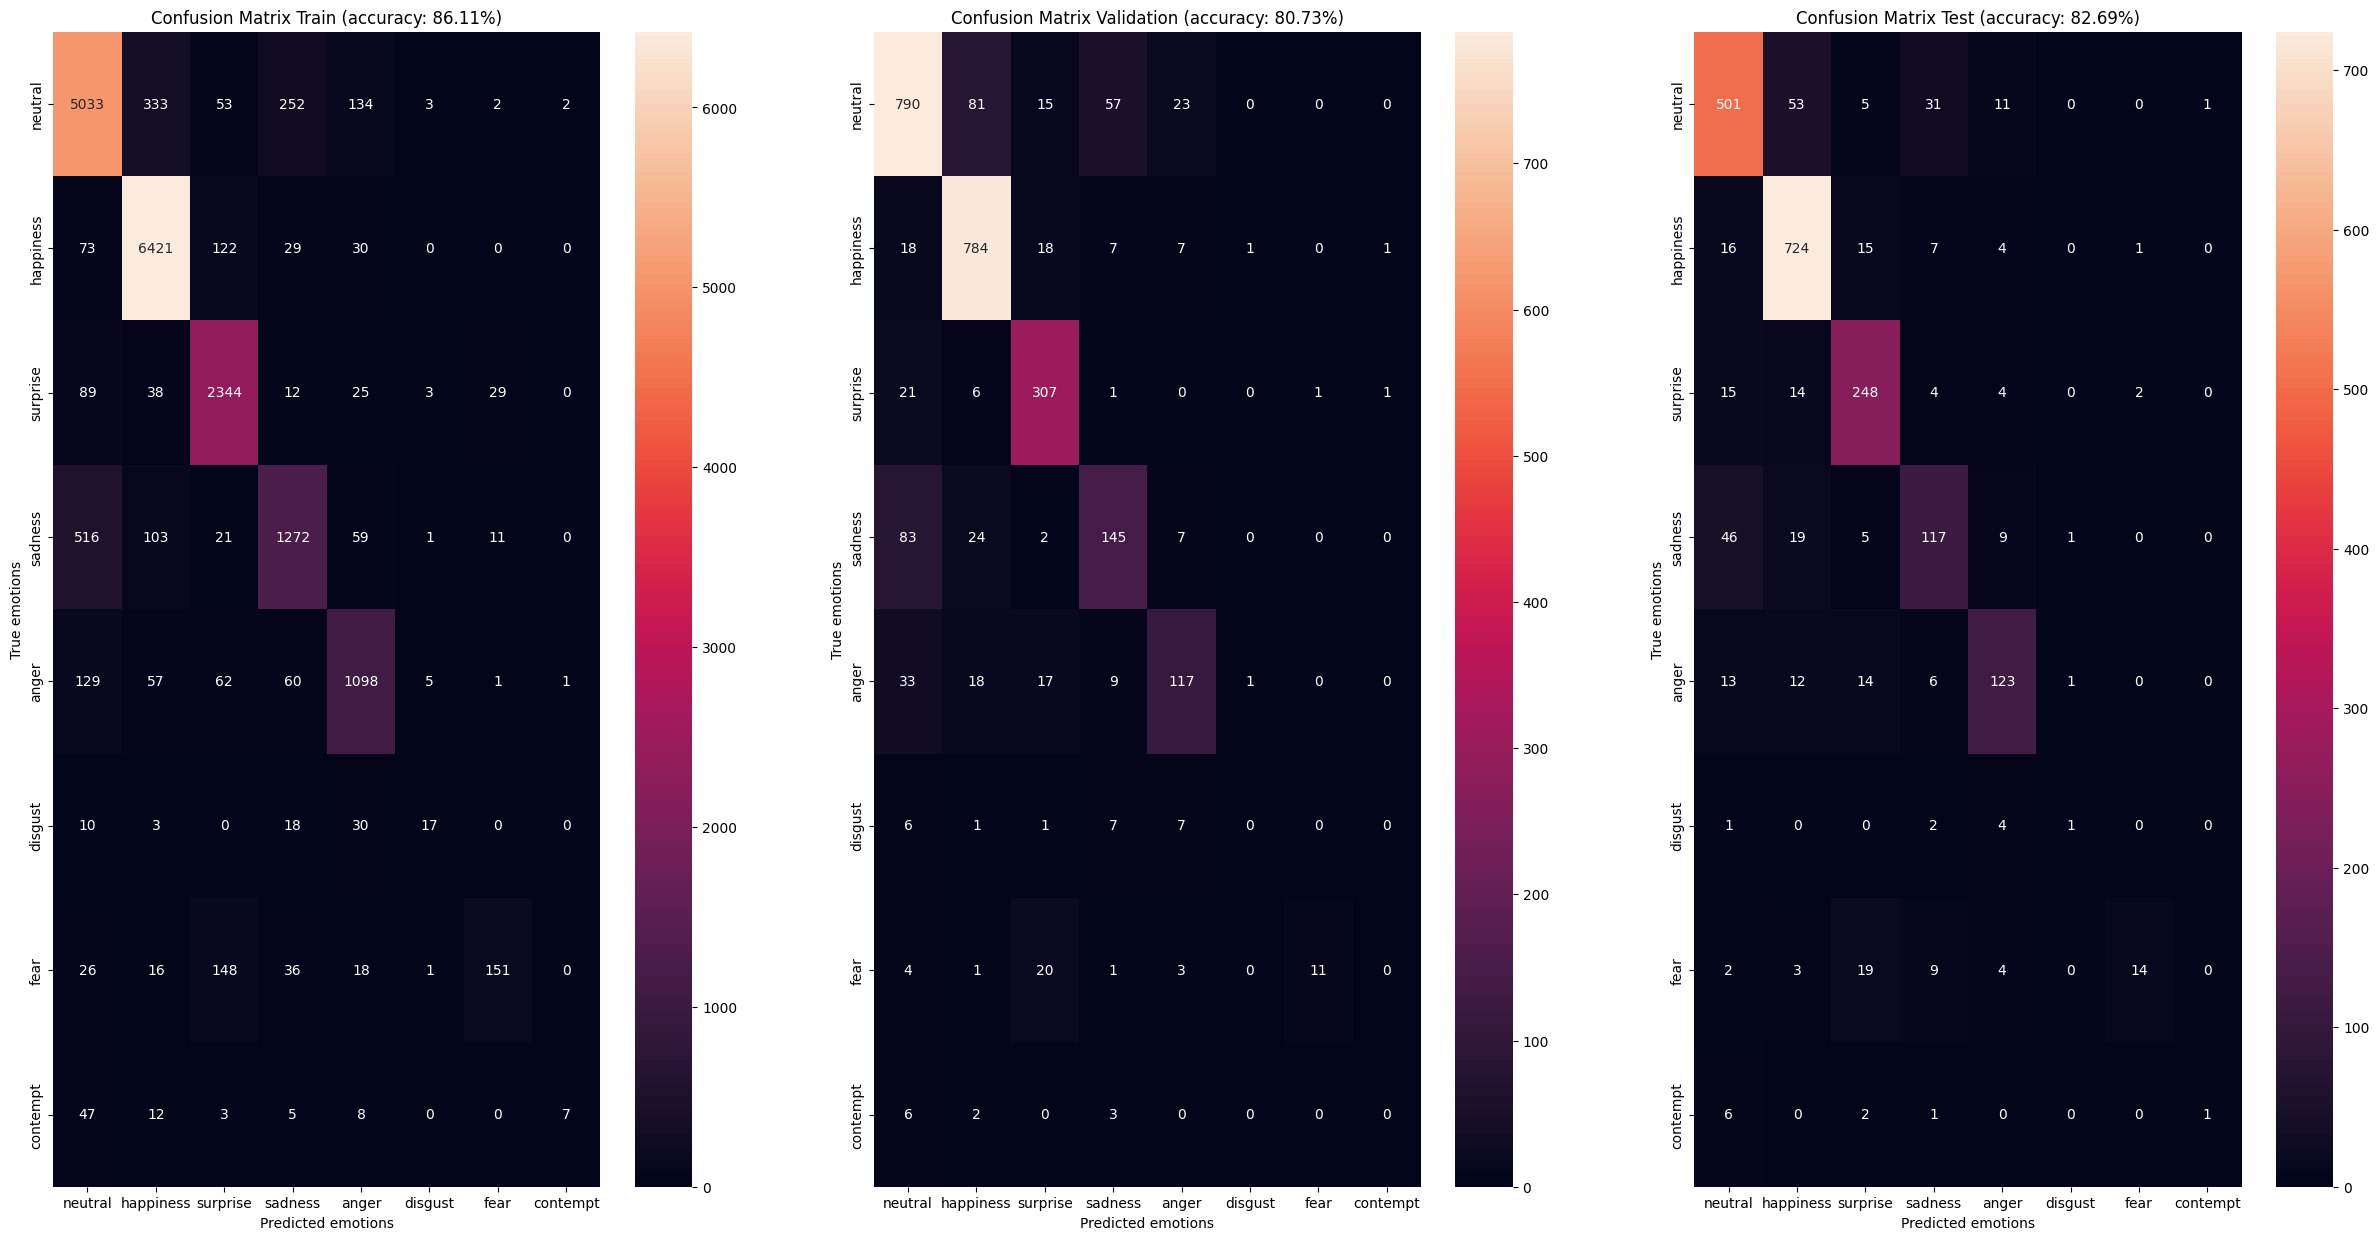

In [24]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

In [25]:
model = load_model('models/augmented5+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model.compile(
    # its default learning rate is already 0.001
    optimizer=Adam(),
    loss=CategoricalCrossentropy(label_smoothing=0.4),
    metrics=['accuracy'],
)

In [26]:
# history = model.fit(
#     ds_train_plus,
#     validation_data=ds_val_plus,
#     epochs=5,
# )
# model.save('models/label_smoothed4+.h5')
# with open('models/history_label_smoothed4+.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/5
297/297 [==============================] - 41s 134ms/step - loss: 7.9732 - accuracy: 0.8294 - val_loss: 7.8326 - val_accuracy: 0.8081
Epoch 2/5
297/297 [==============================] - 39s 131ms/step - loss: 6.8517 - accuracy: 0.8839 - val_loss: 7.4264 - val_accuracy: 0.8077
Epoch 3/5
297/297 [==============================] - 40s 134ms/step - loss: 6.6829 - accuracy: 0.8947 - val_loss: 7.7120 - val_accuracy: 0.7792
Epoch 4/5
297/297 [==============================] - 41s 138ms/step - loss: 6.7056 - accuracy: 0.8993 - val_loss: 7.6597 - val_accuracy: 0.8081
Epoch 5/5
297/297 [==============================] - 42s 140ms/step - loss: 6.4891 - accuracy: 0.9084 - val_loss: 7.7687 - val_accuracy: 0.8152


In [27]:
model = load_model('models/label_smoothed4+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_label_smoothed4+.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
297/297 [==============================] - 11s 37ms/step
Calculating validation results:
42/42 [==============================] - 2s 39ms/step
Calculating test results:
33/33 [==============================] - 1s 40ms/step


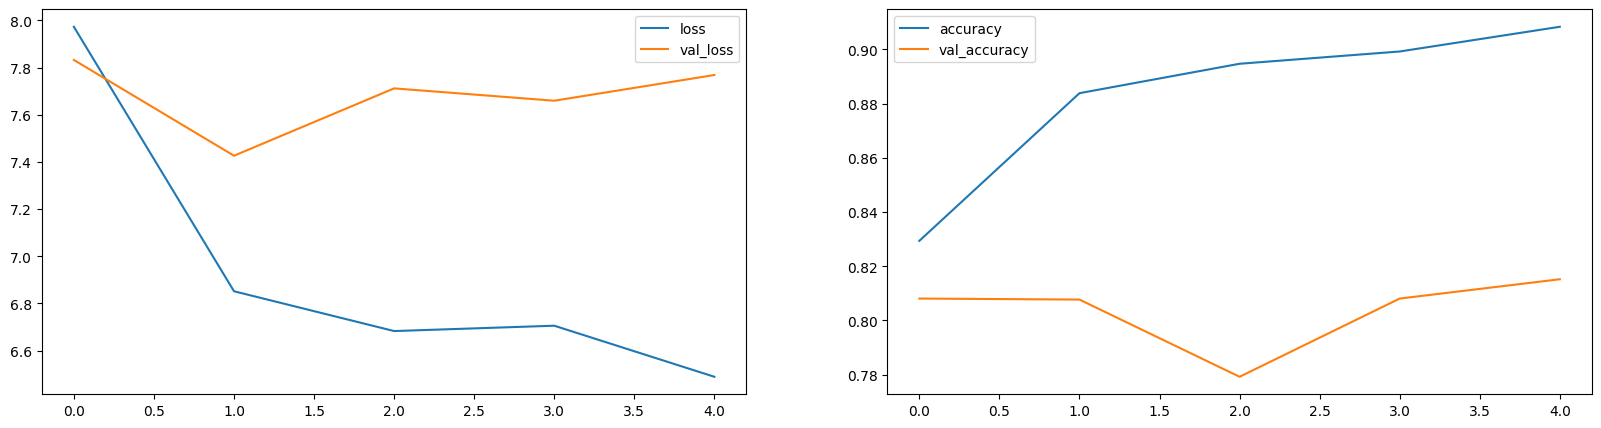

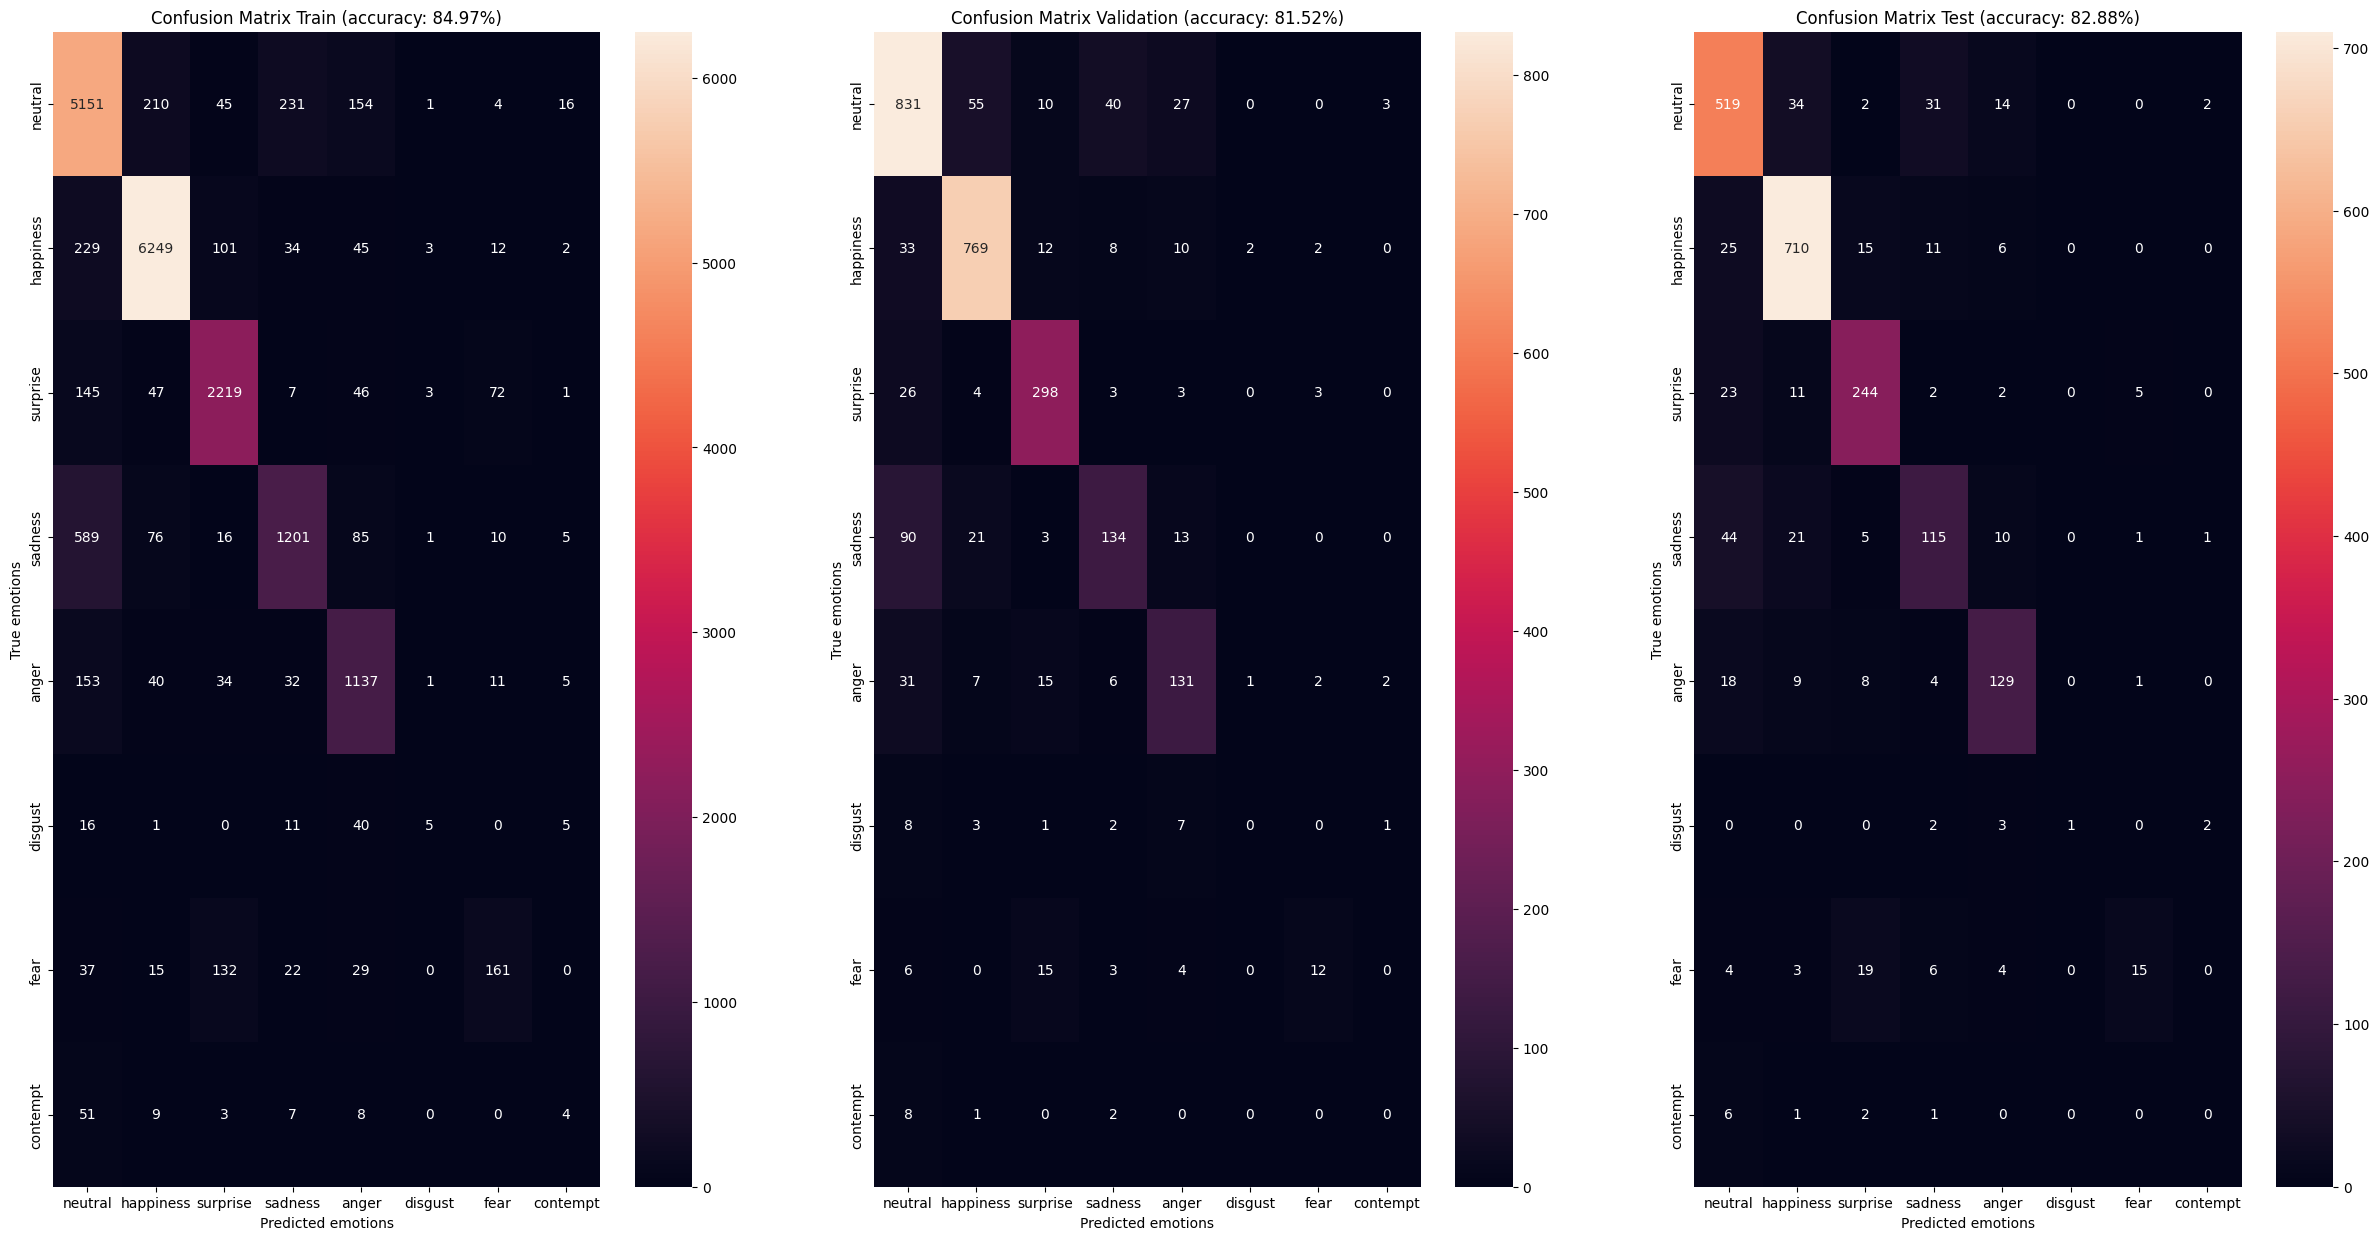

In [28]:
evaluate(model,history2,ds_train_plus,ds_val_plus,ds_test_plus,one_hot_encoded=True,isPlus=True,class_names_variable=class_names_plus)

## Test Time Augmentation

---

In [31]:
model = load_model('models/label_smoothed2+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
accuracy = calculateAccuracyWithTTA(ds_test_plus,model)

100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


In [32]:
print(f"Accuracy obtained with Test Time Augmentation is: {accuracy}%", flush=True)

Accuracy obtained with Test Time Augmentation is: 82.88%


In [33]:
model = load_model('models/label_smoothed2+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
accuracy = calculateAccuracyWithTTA(ds_test_plus,model,tta_steps=5)

100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


In [34]:
print(f"Accuracy obtained with Test Time Augmentation is: {accuracy}%", flush=True)

Accuracy obtained with Test Time Augmentation is: 82.59%


In [35]:
model = load_model('models/label_smoothed2+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
accuracy = calculateAccuracyWithTTA(ds_test_plus,model,tta_steps=10)

100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


In [36]:
print(f"Accuracy obtained with Test Time Augmentation is: {accuracy}%", flush=True)

Accuracy obtained with Test Time Augmentation is: 83.41%


In [37]:
model = load_model('models/label_smoothed2+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
accuracy = calculateAccuracyWithTTA(ds_test_plus,model,tta_steps=20)

100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


In [38]:
print(f"Accuracy obtained with Test Time Augmentation is: {accuracy}%", flush=True)

Accuracy obtained with Test Time Augmentation is: 83.31%


In [39]:
model = load_model('models/label_smoothed2+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
accuracy = calculateAccuracyWithTTA(ds_test_plus,model,tta_steps=25)

100%|██████████| 25/25 [00:44<00:00,  1.76s/it]


In [40]:
print(f"Accuracy obtained with Test Time Augmentation is: {accuracy}%", flush=True)

Accuracy obtained with Test Time Augmentation is: 83.36%


In [41]:
model = load_model('models/label_smoothed2+.h5',custom_objects={'KerasLayer':hub.KerasLayer})
accuracy = calculateAccuracyWithTTA(ds_test_plus,model,tta_steps=30)

100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


In [42]:
print(f"Accuracy obtained with Test Time Augmentation is: {accuracy}%", flush=True)

Accuracy obtained with Test Time Augmentation is: 83.55%
